# This analysis is continued from nb_TE_blueprint_HSPC_Apr23.ipynb

# import packages

In [3]:
library(DESeq2)
library(data.table)
library(dplyr)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(IRdisplay)
library(ChIPpeakAnno)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(Seurat)
library(kableExtra)
library(tidyverse)
library(clusterProfiler)
library(enrichplot)
library(readxl)
library(umap)
library(corrplot)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)
library(DT)
library(tools)
library(tidyverse)
library(maSigPro)
library(RSQLite)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene


In [4]:
source('~/script/utils.r')
setwd('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan//')
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/' 


In [46]:
cell_types = c('HSC', 'MPP', 'CMP', 'GMP', 'MEP', 'CLP', 'EB', 'MK')
sample_names = c('HSC1', 'HSC2', 'HSC3', 'MPP1', 'MPP2', 'MPP3', 'CMP1', 'CMP2', 
                 'CMP3', 'GMP1', 'GMP2', 'GMP3', 'MEP1', 'MEP2', 'MEP3', 'MEP4', 'CLP1', 'CLP2', 'CLP3', 'EB1', 
                 'EB2', 'EB3', 'MK1', 'MK2', 'MK3')
sample_names_n24 = c('HSC1', 'HSC2', 'HSC3', 'MPP1', 'MPP2', 'MPP3', 'CMP1', 'CMP2', 
                 'CMP3', 'GMP1', 'GMP2', 'GMP3', 'MEP1', 'MEP2', 'MEP3', 'MEP4', 'CLP1', 'CLP3', 'EB1', 
                 'EB2', 'EB3', 'MK1', 'MK2', 'MK3')


# import the data for partly run this notebook

In [ ]:
mtx_all_df = readRDS('data/mtx_all_df.rds')
dsn_all_df = readRDS('data/dsn_all_df.rds')

dsn_all = as.data.table(dsn_all_df, keep.rownames = T)

dge_all      = readRDS('data/dge_all_may1.rds')
fit_all      = readRDS('data/fit_all_may1.rds')
logcpm_all_t = readRDS('data/logcpm_all_t_may1.rds') 
logcpm_all   = readRDS('data/logcpm_all_may1.rds') 

dge_coding      = readRDS('data/dge_coding_may1.rds') 
fit_coding      = readRDS('data/fit_coding_may1.rds') 
deg_coding_dt   = readRDS('data/fit_coding_may1.rds') 
logcpm_coding_t = readRDS('data/logcpm_coding_t_may1.rds') 
logcpm_coding   = readRDS('data/logcpm_coding_may1.rds') 


dge_te      = readRDS('data/dge_te_may1.rds')
fit_te      = readRDS('data/fit_te_may1.rds')
deg_te_dt   = readRDS('data/fit_te_may1.rds')
logcpm_te_t = readRDS('data/logcpm_te_t_may1.rds')
logcpm_te   = readRDS('data/logcpm_te_may1.rds')

coding_genes = read.table('coding_gene_list', header = F)$V1
te_genes = read.table('te_gene_list', header = F)$V1

mtx_coding_df = mtx_all_df[coding_genes, ]
mtx_te_df = mtx_all_df[!rownames(mtx_all_df) %in% coding_genes, ]

te_dt = readRDS('data/te_dt_may08.rds')

dsn6 = fread('data/organized_sample_table.xls')


In [8]:
ls()

[1] "base_dir"        "cell_types"      "coding_genes"    "deg_coding_dt"  
 [5] "deg_te_dt"       "dge_all"         "dge_coding"      "dge_te"         
 [9] "dsn_all"         "dsn_all_df"      "fit_all"         "fit_coding"     
[13] "fit_te"          "logcpm_all"      "logcpm_all_t"    "logcpm_coding"  
[17] "logcpm_coding_t" "logcpm_te"       "logcpm_te_t"     "mtx_all_df"     
[21] "mtx_coding_df"   "mtx_te_df"       "pathway_fun"     "sample_names"   
[25] "scale_fun"       "te_dt"           "te_genes"        "txdb"

# compared with the paper

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
qc = as.data.table(enframe(apply(mtx_all_df, 2, sum)) )
qc[, name := factor(name, levels = sample_names)] 
ggplot(qc, aes(name, value)) + geom_bar(stat = 'identity') + theme_pubr() + theme(axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1))


In [ ]:
sample_names

In [ ]:
st_1 = as.data.table(read_xlsx('1251033s.xlsx', sheet = 1, skip = 1, n_max = 25) )
head(st_1)


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
st_1 = as.data.table(read_xlsx('1251033s.xlsx', sheet = 1, skip = 1, n_max = 25) )
setnames(st_1, 5, 'reads')
st_1[, Sample := factor(Sample, levels = sample_names)]
st_1 = st_1[order(Sample), ]
ggplot(st_1, aes(Sample, reads)) +  geom_bar(stat = 'identity') + theme_pubr() + theme(axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1))

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
qc[, value2 := value / 1000000] 
plotdat = merge(st_1[, .(Sample, reads)], qc, by.x = 'Sample', by.y = 'name')
plotdat[, Sample := factor(Sample, levels = sample_names) ]
plotdat = plotdat[order(Sample)]
plotdat[, cell_type := sub('\\d+', '', Sample)] 
ggplot(plotdat, aes(reads, value2)) + geom_point() + theme_pubr() + xlab('online: Reads after trimming x10^6') + ylab('ours: aligned counted x10^6') +
  stat_smooth(method = "lm",  formula = y ~ x,  geom = "smooth")  + stat_cor(p.accuracy = 0.001, r.accuracy = 0.01)



In [ ]:
head(st_1)
head(qc)

# PCA

In [ ]:
rsum = rowSums(logcpm_coding)
rsd  = rowSds(logcpm_coding)
summary(rsum)
summary(rsd)

In [ ]:
logcpm_coding[1:10,1:10]

In [ ]:
plotdat = logcpm_coding[rsum > 41 & rsd > .75, ]
plotdat = scale(plotdat, scale = F, center = T)
plotdat = prcomp(t(plotdat))
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)
plot(plotdat, main = '')


In [ ]:
plotdat_x = as.data.table(plotdat$x, keep.rownames = T)
plotdat_x[, cell_type := sub('\\d+', '', rn)]


In [ ]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
ggplot(plotdat_x, aes(PC1, PC2, label = rn, color = cell_type)) + geom_point() + theme_pubr() + geom_text_repel()

In [ ]:
plotdat[1:3, 1:3]

In [ ]:
# cluster analysis
options(repr.plot.width = 14, repr.plot.height = 14, repr.plot.res = 200)
plotdat = logcpm_coding[rsum > 41 & rsd > .75, ]
plotdat = cor(plotdat)
plotdat = round(plotdat, 2)
corrplot.mixed(plotdat, order = 'AOE') 


In [ ]:
mtx_coding_df = mtx_all_df[coding_genes, ]
mtx_te_df = mtx_all_df[!rownames(mtx_all_df) %in% coding_genes, ]
dsn_all_df$cell_type


# organize coding and TE genes

In [14]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"


In [15]:
coding_genes = read.table('coding_gene_list', header = F)$V1
te_genes = read.table('te_gene_list', header = F)$V1


In [11]:
dim(logcpm_all)

[1] 43658    24

# coding gene DEG

In [ ]:
logcpm_coding = log1p(cpm(dge_coding, normalize = T))
logcpm_coding_t = merge(as.data.table(t(logcpm_coding), keep.rownames = T), dsn_all, by.x = 'rn', by.y = 'sample_name', all.x = T)
head(logcpm_coding_t)


In [ ]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
ggplot(logcpm_coding_t, aes(cell_type, RPL9P32)) + geom_boxplot() + theme_pubr()


In [12]:
head(mtx_coding_df)

CLP1 CLP2 CLP3 CMP1 CMP2 CMP3 EB1 EB2 EB3 GMP1 ⋯ MEP1 MEP2 MEP3 MEP4
A1BG       29 87   276   630 1635 692   18   8   6 103  ⋯ 446  1820  465  103
A1BG-AS1    1  0   288     0  909 656   33  24  17  28  ⋯ 139   480 1044  113
A1CF        0  0     0     0    0   0  103 135  38 269  ⋯   0     0    0    0
A2M      1072  1   166  3874 2383 485  133 272  58 534  ⋯ 802   562  241 2504
A2M-AS1  1826  0     0   841  501 991    6   0   4 165  ⋯ 989  1131    0  833
A2ML1       0  0   219     0    3   0  128 178 128 670  ⋯   0     0  130    0
         MK1 MK2 MK3 MPP1 MPP2 MPP3
A1BG      88  72  71   95 1261   39
A1BG-AS1 215 139  79  171   52    0
A1CF      62 123  89    9    0  125
A2M      161 864 379 1230 1842 1168
A2M-AS1    5  16   3  133   17   87
A2ML1     74 184 650  440    3    0

In [16]:
row_sum = rowSums(mtx_coding_df)
row_sd  = rowSds(mtx_coding_df)
summary(row_sum)
summary(row_sd)


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0       32      384    40734     4276 72494389 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.0       3.6      36.9    1256.4     259.9 1616161.9 

In [21]:
gene_sel = rownames(mtx_coding_df)[row_sum > 40734 & row_sd > 1256.4]
length(gene_sel)


[1] 6894

In [22]:
deg_coding_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    mtx_ranged = mtx_coding_df[gene_sel, rownames(dsn_all_df)]

    dge = DGEList(counts=mtx_ranged, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})


In [23]:
names(deg_coding_list) = cell_types
deg_coding_dt = rbindlist(deg_coding_list, idcol = T)
deg_coding_dt = deg_coding_dt[order(PValue), ]
head(deg_coding_dt)


.id rn           logFC     logCPM   PValue       FDR      
1 HSC MECOM         2.833586 5.642943 8.603776e-05 0.4973527
2 HSC LOC101927745  2.755068 5.094870 1.796906e-04 0.4973527
3 HSC SETBP1        2.899563 5.104086 2.164285e-04 0.4973527
4 HSC LRBA          1.483922 6.795728 4.907392e-04 0.5324078
5 HSC ADAM28        2.581699 5.832010 6.456399e-04 0.5324078
6 HSC PIP4K2A      -1.945506 9.696436 6.540788e-04 0.5324078

In [27]:
saveRDS(dge_coding, file = 'data/dge_coding_May28.rds')
saveRDS(fit_coding, file = 'data/fit_coding_May28.rds')
saveRDS(deg_coding_dt, file = 'data/fit_coding_May28.rds')
saveRDS(logcpm_coding_t, file = 'data/logcpm_coding_t_May28.rds')
saveRDS(logcpm_coding, file = 'data/logcpm_coding_May28.rds')


# TE gene DEG


In [28]:
row_sum = rowSums(mtx_te_df)
row_sd  = rowSds(mtx_te_df)
summary(row_sum)
summary(row_sd)


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0    13798    56173   450593   196386 48363862 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.0     501.7    1583.9   10761.3    4990.3 1076894.6 

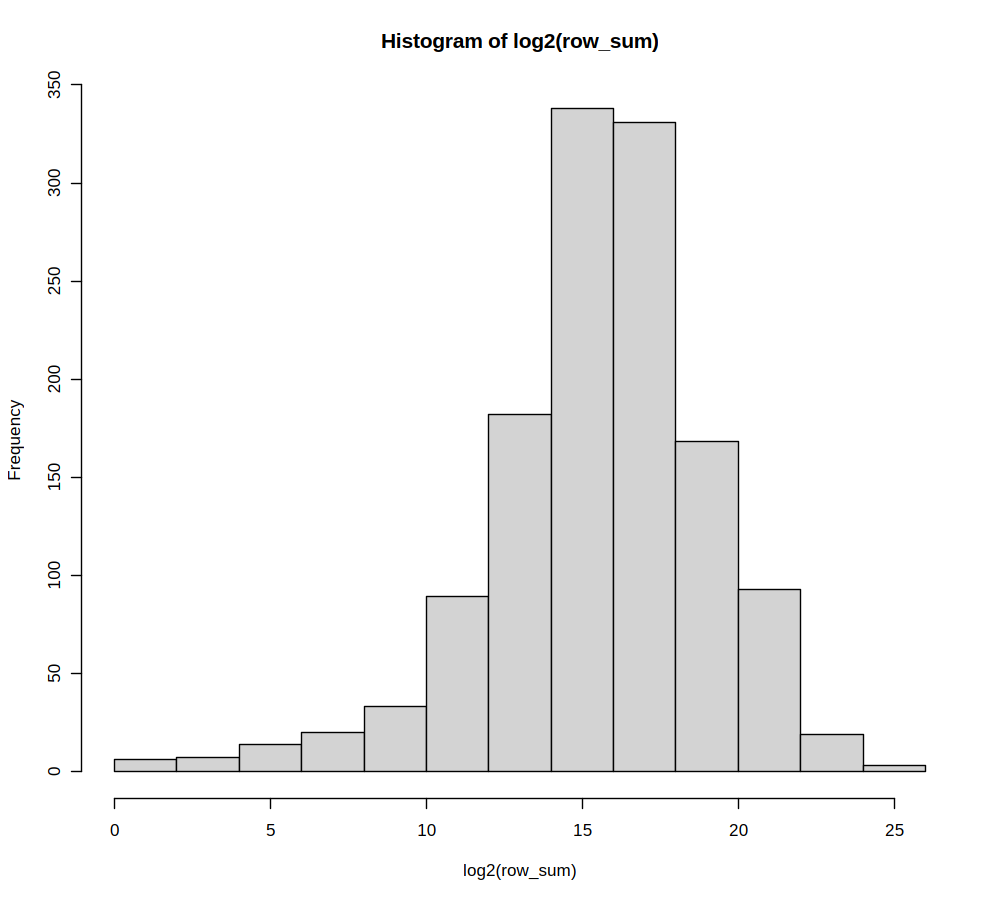

In [59]:
hist(log2(row_sum))

In [60]:
2^5

[1] 32

In [32]:
dim(mtx_te_df)

[1] 1310   25

In [61]:
gene_sel = rownames(mtx_te_df)[row_sum > 2^10]
length(gene_sel)


[1] 1223

In [62]:
deg_te_list = lapply(cell_types, function(cc){
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype, levels = c('Other', cc))
    mtx_arranged = mtx_te_df[gene_sel, rownames(dsn_all_df)]

    dge = DGEList(counts=mtx_arranged, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})



In [63]:
names(deg_te_list) = cell_types
deg_te_dt = rbindlist(deg_te_list, idcol = T)
deg_te_dt = deg_te_dt[order(PValue), ]
head(deg_te_dt)


.id rn                      logFC      logCPM   PValue       FDR         
1 CMP UCON28b:Unknown:Unknown  -8.814440 3.694313 5.838190e-14 7.140106e-11
2 CMP MER92D:ERV1:LTR         -11.851777 4.025914 1.570117e-09 9.601264e-07
3 CMP LTR35B:ERV1:LTR          -8.011572 4.518548 2.525518e-08 1.029569e-05
4 CMP LTR48B:ERV1:LTR          -1.501265 7.159887 1.682623e-07 5.144618e-05
5 CMP UCON16:Unknown:Unknown  -10.548174 2.734939 2.903848e-07 7.102812e-05
6 CMP MST-int:ERVL-MaLR:LTR    -3.356113 4.905069 4.055150e-07 8.265747e-05

In [64]:
saveRDS(dge_te, file = 'data/dge_te_May28.rds')
saveRDS(fit_te, file = 'data/fit_te_May28.rds')
saveRDS(deg_te_dt, file = 'data/fit_te_May28.rds')
saveRDS(logcpm_te_t, file = 'data/logcpm_te_t_May28.rds')
saveRDS(logcpm_te, file = 'data/logcpm_te_May28.rds')


# heatmap

## based on the gene list from the paper

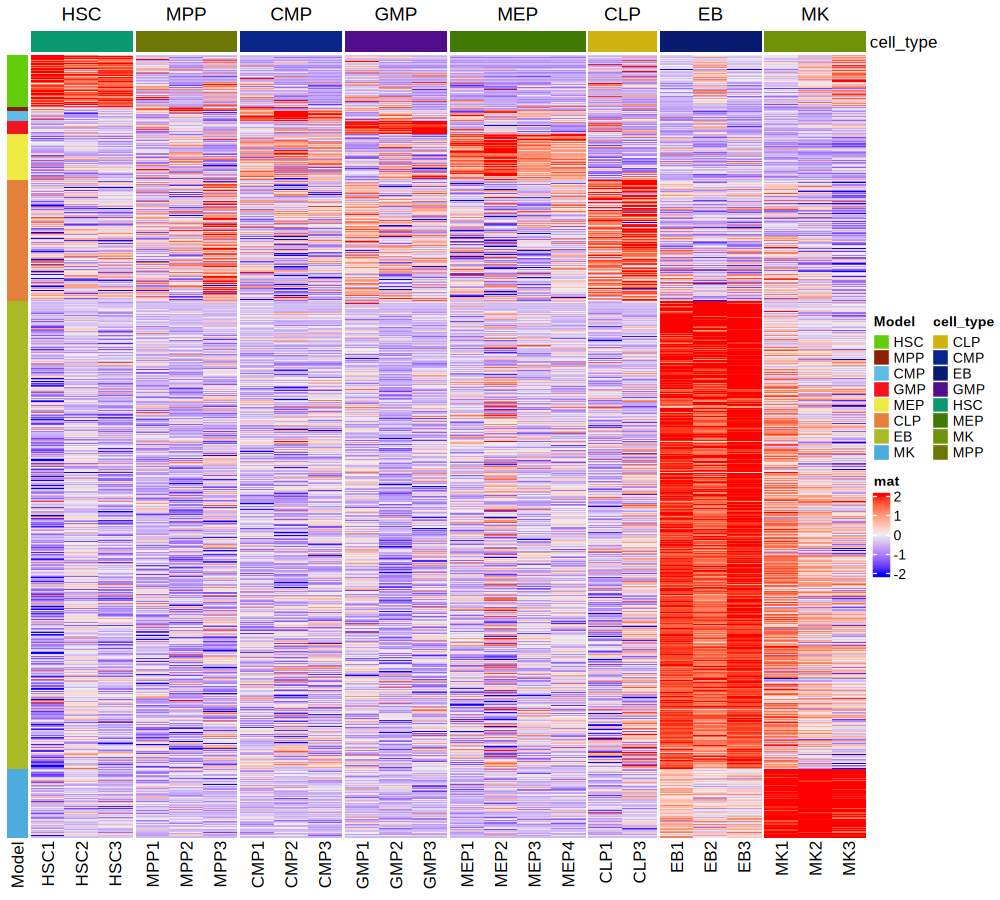

In [66]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

st_4 = as.data.table(read_xlsx('data/1251033s.xlsx', sheet = 4, skip = 1)  )
setnames(st_4, 9, 'pval')
sig_genes = st_4$External_gene_id
sig_genes = intersect(sig_genes, rownames(logcpm_coding))

st_4_sel = st_4[External_gene_id %in% sig_genes, ]
st_4_sel[, ctype_gene := paste0(Model, '_', External_gene_id)]
st_4_sel[, Model := factor(Model, levels = cell_types)]
st_4_sel = st_4_sel[order(Model), ]

plotdat = logcpm_coding[st_4_sel$External_gene_id, rownames(dsn_all_df)]
rownames(plotdat) = st_4_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = st_4_sel[, .(Model)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


In [67]:
st_4 = as.data.table(read_xlsx('data/1251033s.xlsx', sheet = 4, skip = 1)  )
setnames(st_4, 9, 'pval')
st_4_sel = st_4 %>% group_by(Model) %>% slice_min(order_by = pval, n = 20)
dim(st_4_sel)
head(st_4_sel)

[1] 145   9

Model Ensembl_gene_id Gene_biotype   External_gene_id
1 CLP   ENSG00000226979 protein_coding LTA             
2 CLP   ENSG00000141556 protein_coding TBCD            
3 CLP   ENSG00000234608 lincRNA        MAPKAPK5-AS1    
4 CLP   ENSG00000147905 protein_coding ZCCHC7          
5 CLP   ENSG00000102606 protein_coding ARHGEF7         
6 CLP   ENSG00000180011 protein_coding ZADH2           
  Description                                                                          
1 lymphotoxin alpha (TNF superfamily, member 1) [Source:HGNC Symbol;Acc:6709]          
2 tubulin folding cofactor D [Source:HGNC Symbol;Acc:11581]                            
3 MAPKAPK5 antisense RNA 1 [Source:HGNC Symbol;Acc:24091]                              
4 zinc finger, CCHC domain containing 7 [Source:HGNC Symbol;Acc:26209]                 
5 Rho guanine nucleotide exchange factor (GEF) 7 [Source:HGNC Symbol;Acc:15607]        
6 zinc binding alcohol dehydrogenase domain containing 2 [Source:HGNC Symbol;Acc:28697]
  Model posterior probability log(FC)  Second model pval        
1 0.9998567                   7.431380 ZERO         5.502297e-05
2 0.9988962                   1.521150 ZERO         7.807155e-04
3 0.9987265                   0.771894 ZERO         1.036097e-03
4 0.9982218                   1.331880 ZERO         1.272343e-03
5 0.9948035                   0.897202 ZERO         3.195232e-03
6 0.9941627                   0.783446 ZERO         3.608838e-03

In [68]:
sig = deg_coding_dt[FDR < .1, rn]

In [69]:
dsn_all_df = data.frame(cell_type = sub('\\d+', '', sample_names_n24), row.names = sample_names_n24)
dim(dsn_all_df)

[1] 24  1

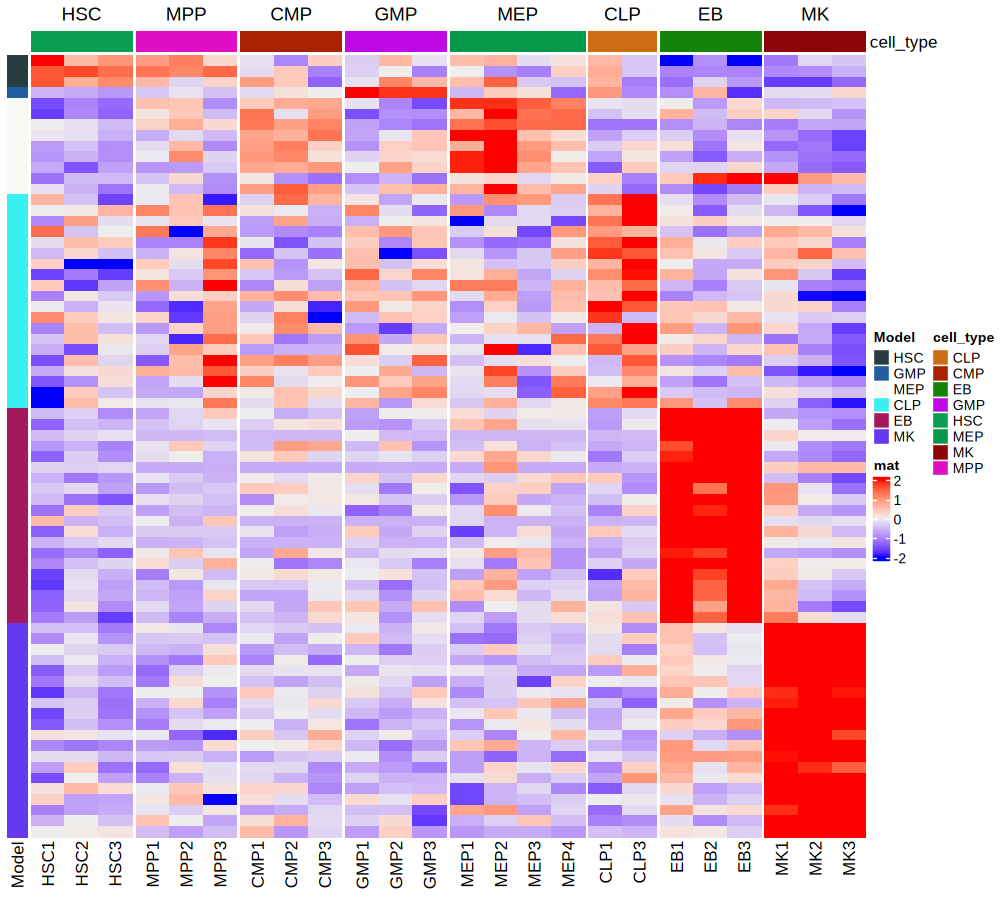

In [70]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

st_4 = as.data.table(read_xlsx('data/1251033s.xlsx', sheet = 4, skip = 1)  )
st_4 = st_4[External_gene_id %in% deg_coding_dt[FDR < 0.05, rn], ]
setnames(st_4, 9, 'pval')
st_4_sel = st_4 %>% group_by(Model) %>% slice_min(order_by = pval, n = 20)
st_4_sel = as.data.table(st_4_sel)

sig_genes = intersect(sig_genes, rownames(logcpm_coding))

st_4_sel = st_4_sel[External_gene_id %in% sig_genes, ]
st_4_sel[, ctype_gene := paste0(Model, '_', External_gene_id)]
st_4_sel[, Model := factor(Model, levels = cell_types)]
st_4_sel = st_4_sel[order(Model), ]

plotdat = logcpm_coding[st_4_sel$External_gene_id, rownames(dsn_all_df)]
rownames(plotdat) = st_4_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = st_4_sel[, .(Model)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


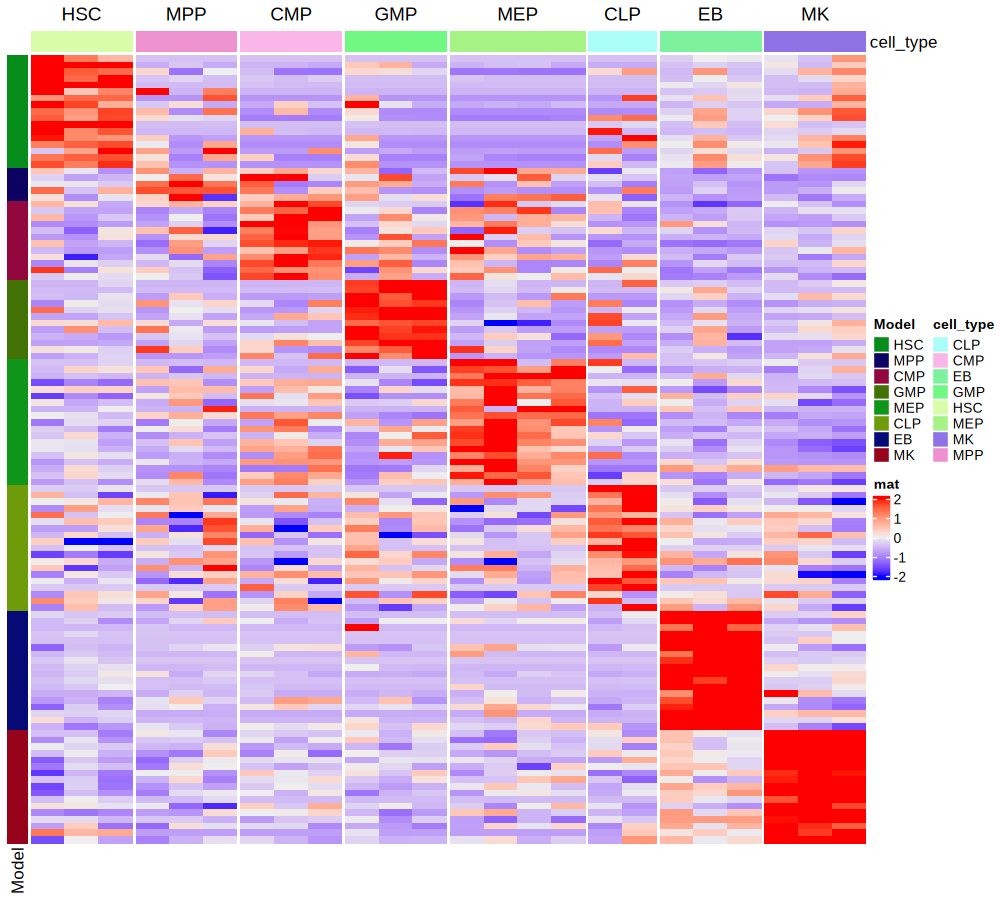

In [71]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

st_4 = as.data.table(read_xlsx('data/1251033s.xlsx', sheet = 4, skip = 1)  )
setnames(st_4, 9, 'pval')
st_4_sel = st_4 %>% group_by(Model) %>% slice_min(order_by = pval, n = 20)
st_4_sel = as.data.table(st_4_sel)

sig_genes = intersect(sig_genes, rownames(logcpm_coding))

st_4_sel = st_4_sel[External_gene_id %in% sig_genes, ]
st_4_sel[, ctype_gene := paste0(Model, '_', External_gene_id)]
st_4_sel[, Model := factor(Model, levels = cell_types)]
st_4_sel = st_4_sel[order(Model), ]

plotdat = logcpm_coding[st_4_sel$External_gene_id, rownames(dsn_all_df)]
rownames(plotdat) = st_4_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = st_4_sel[, .(Model)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, cluster_rows = F,  
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


### based on the sig genes from this analysis

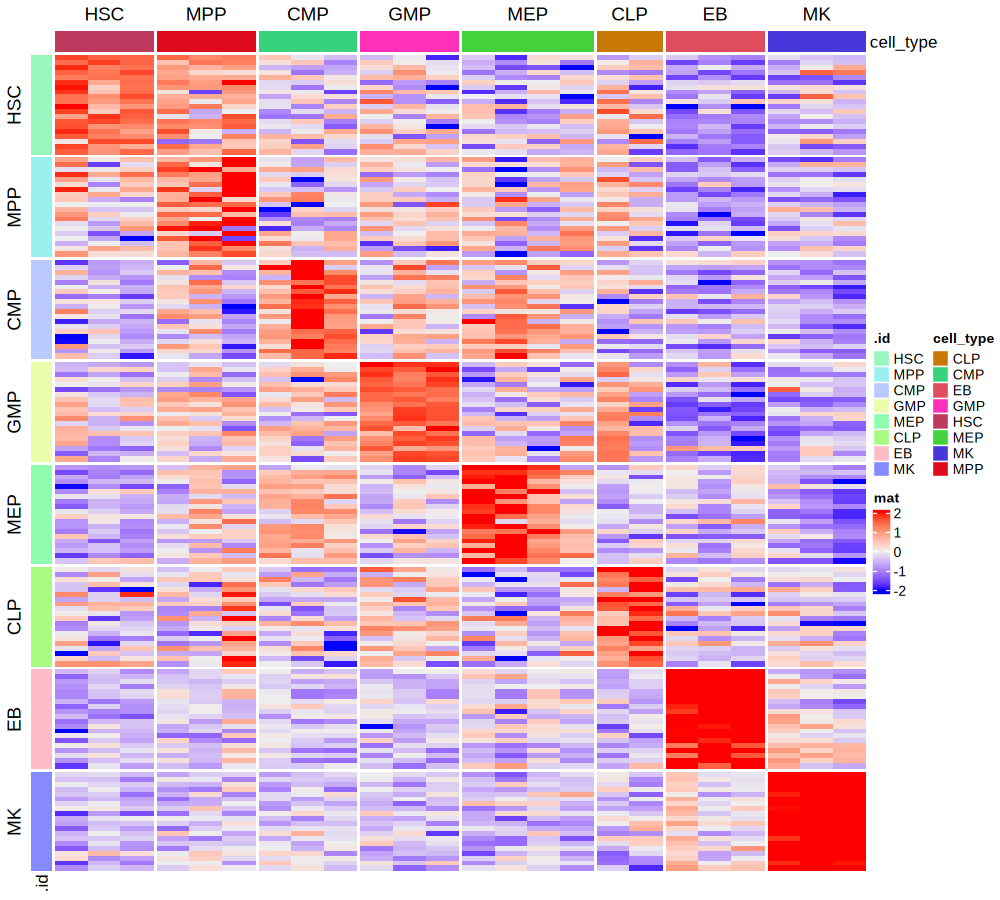

In [72]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_coding_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_coding))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_coding[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

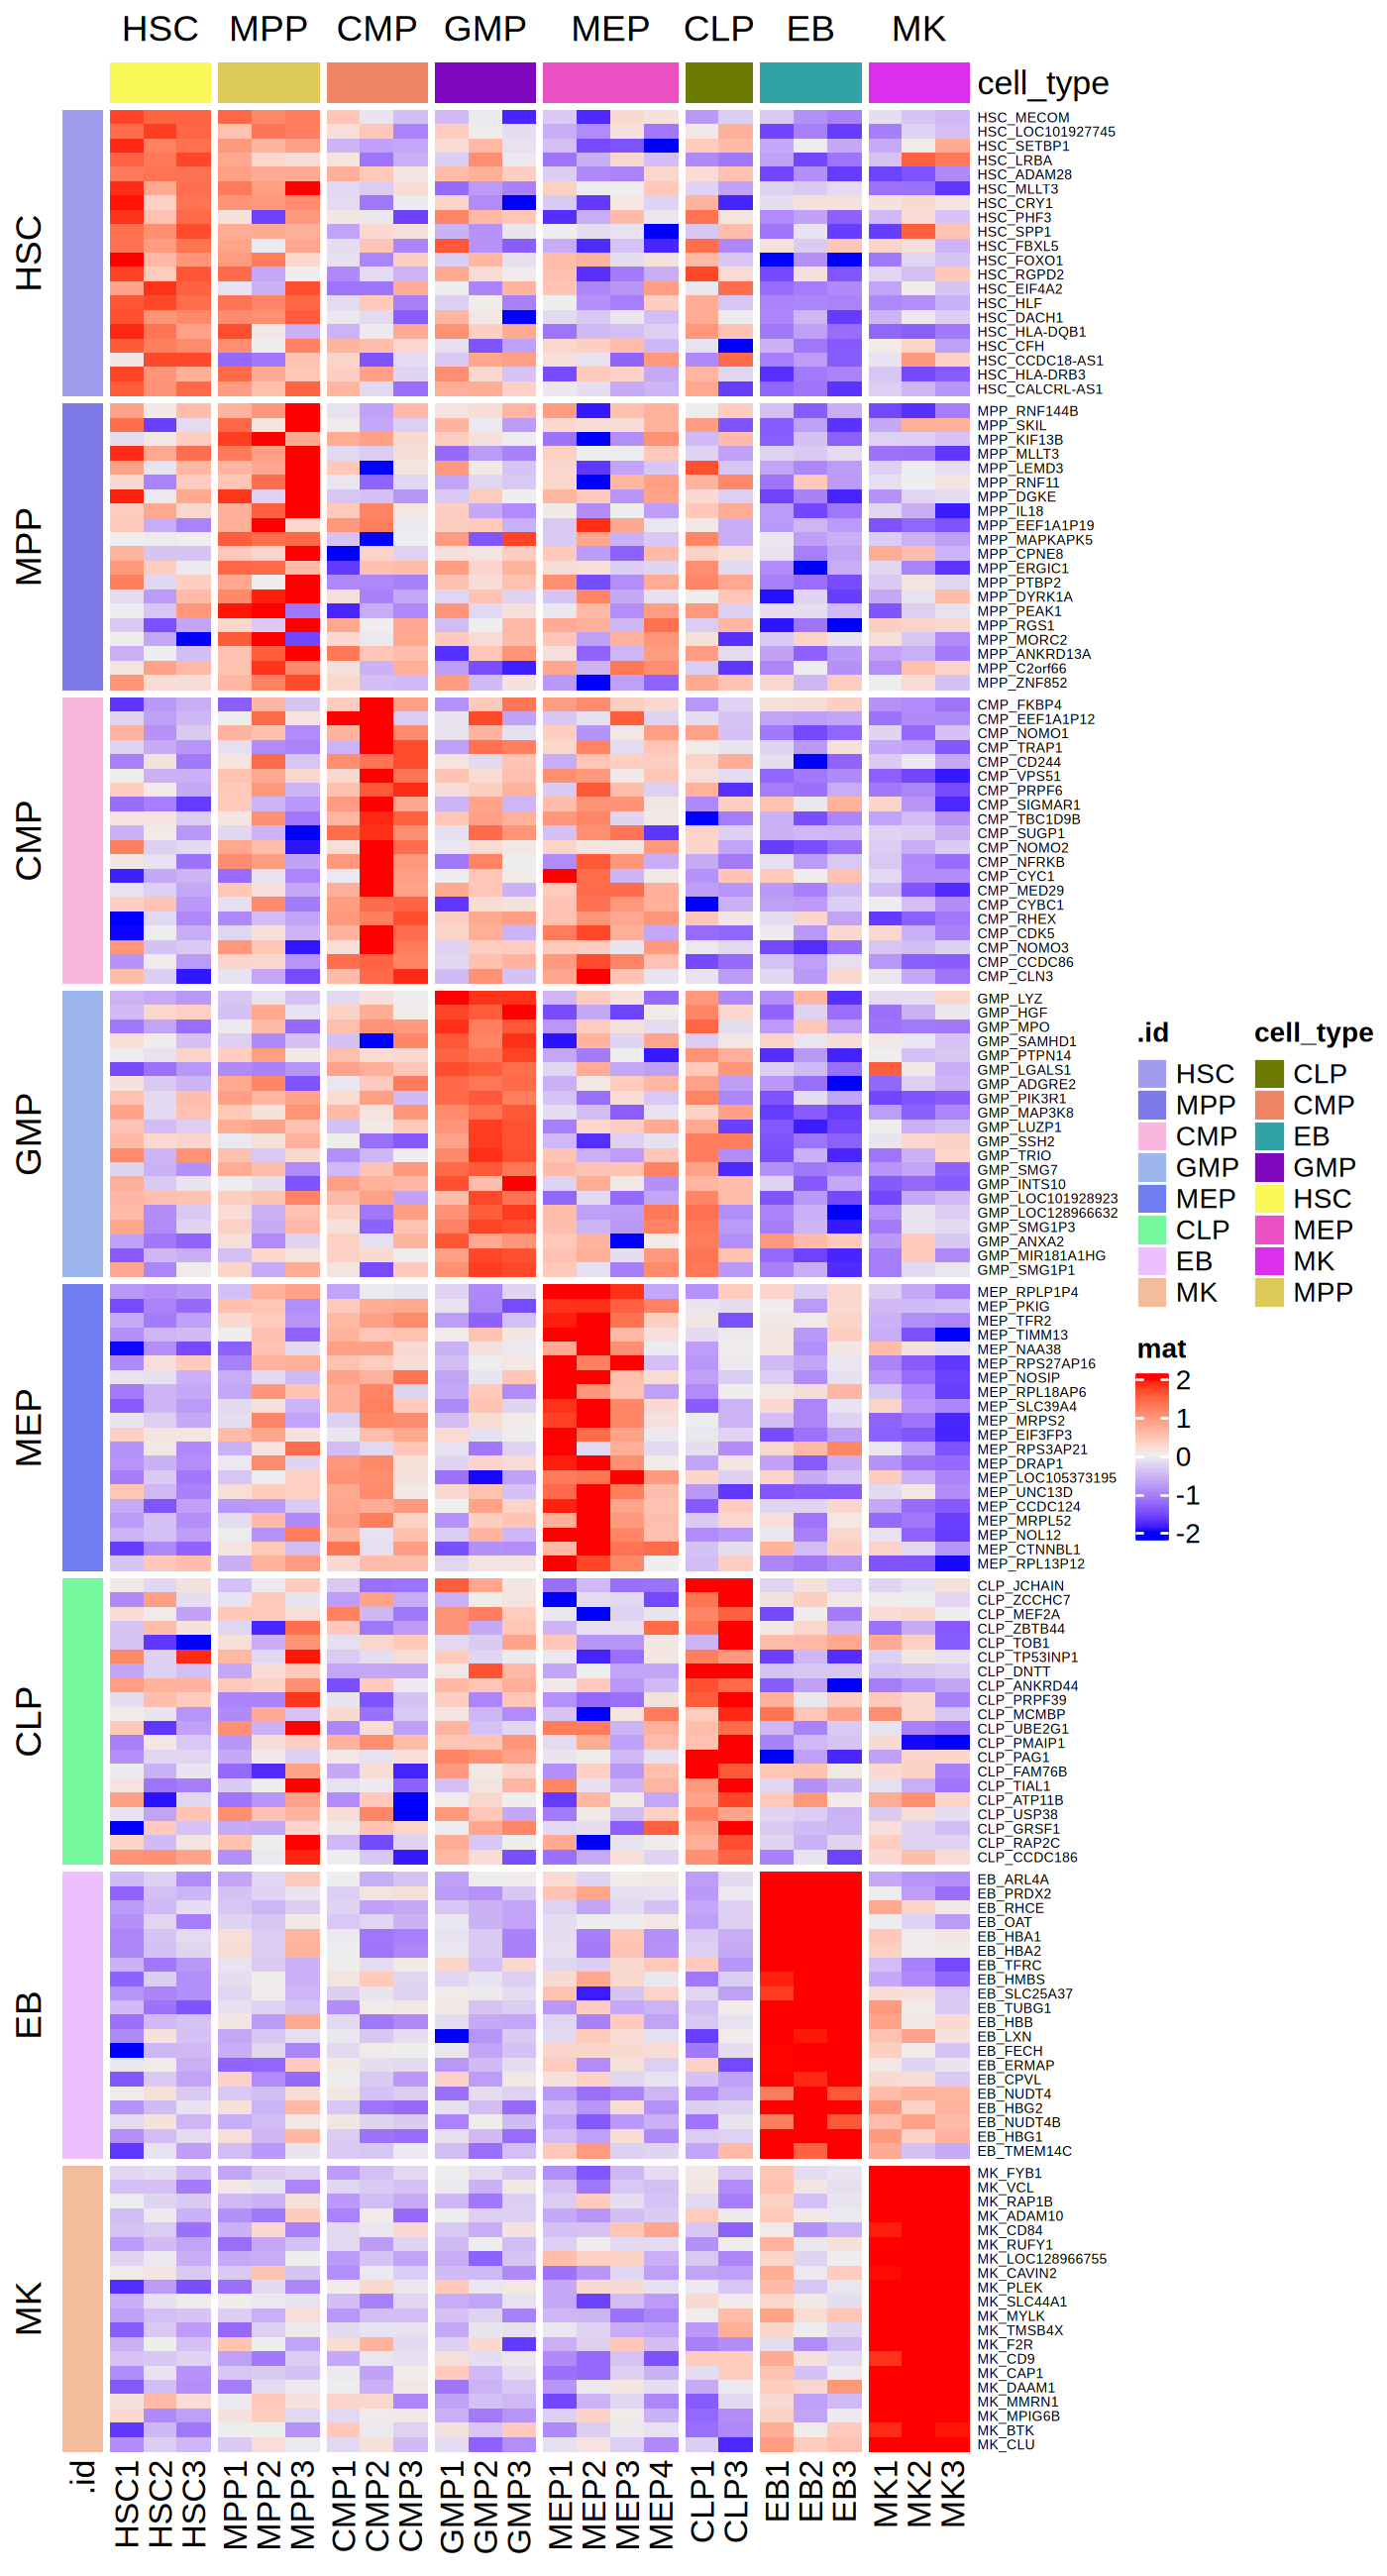

In [73]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 7, repr.plot.height = 13, repr.plot.res = 200)

row_sel = deg_coding_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_coding))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_coding[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id,   row_names_gp = grid::gpar(fontsize = 5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


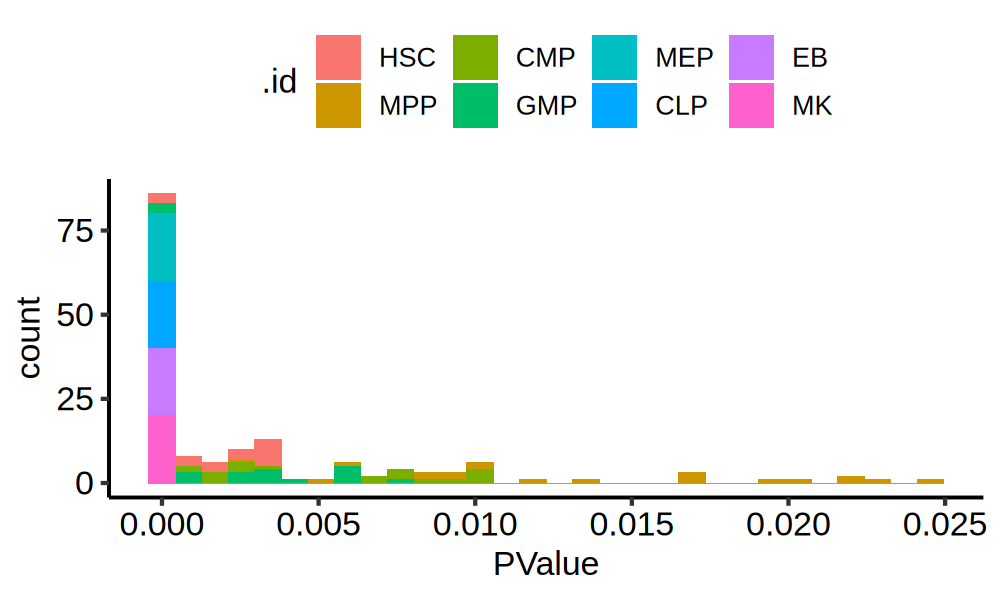

In [74]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = PValue, fill = .id)) + geom_histogram() + theme_pubr()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


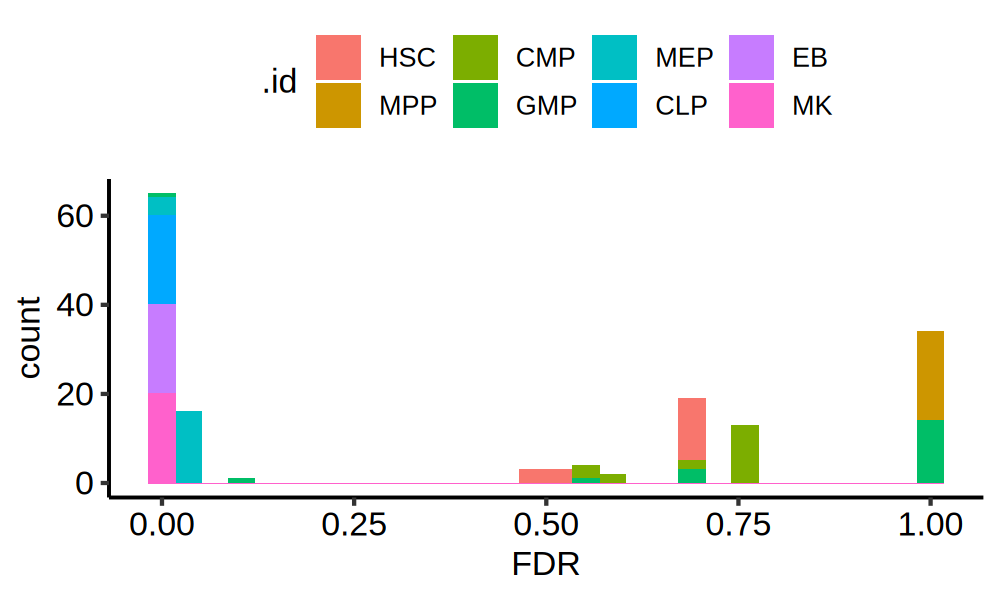

In [75]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = FDR, fill = .id)) + geom_histogram() + theme_pubr()


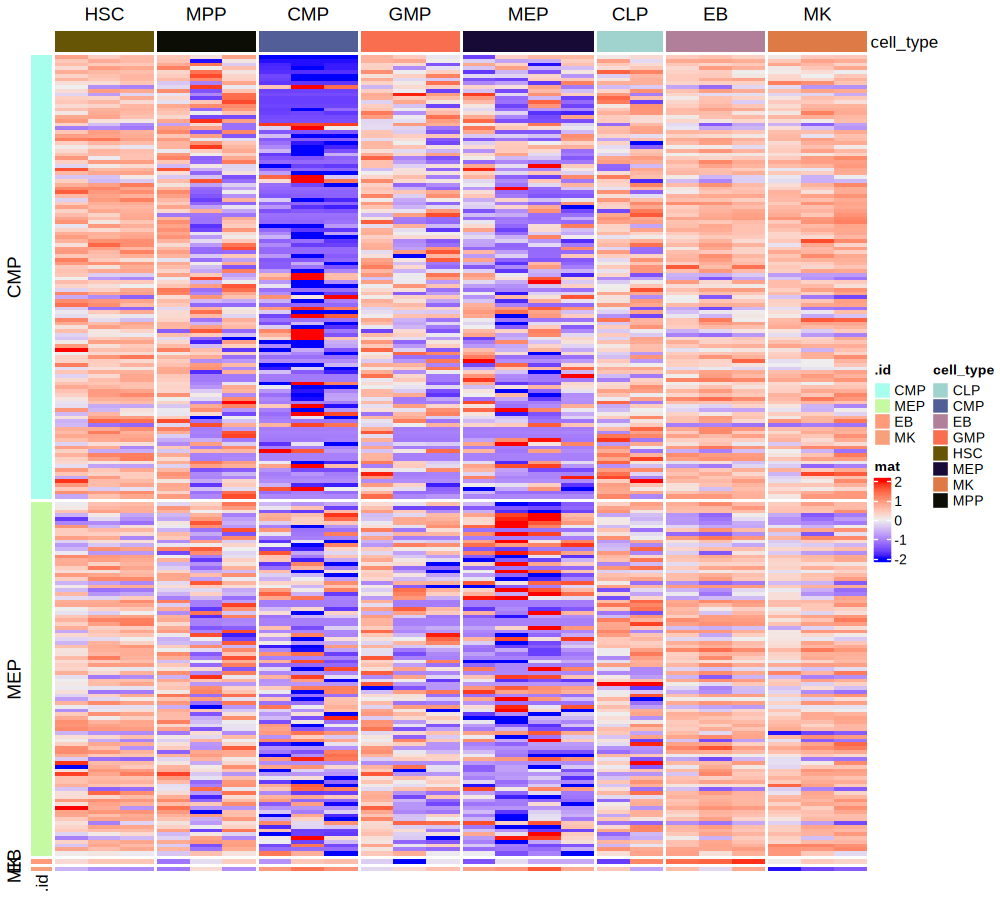

In [76]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_te))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

In [77]:
table(sign(row_sel$logFC))


 -1   1 
162  52 

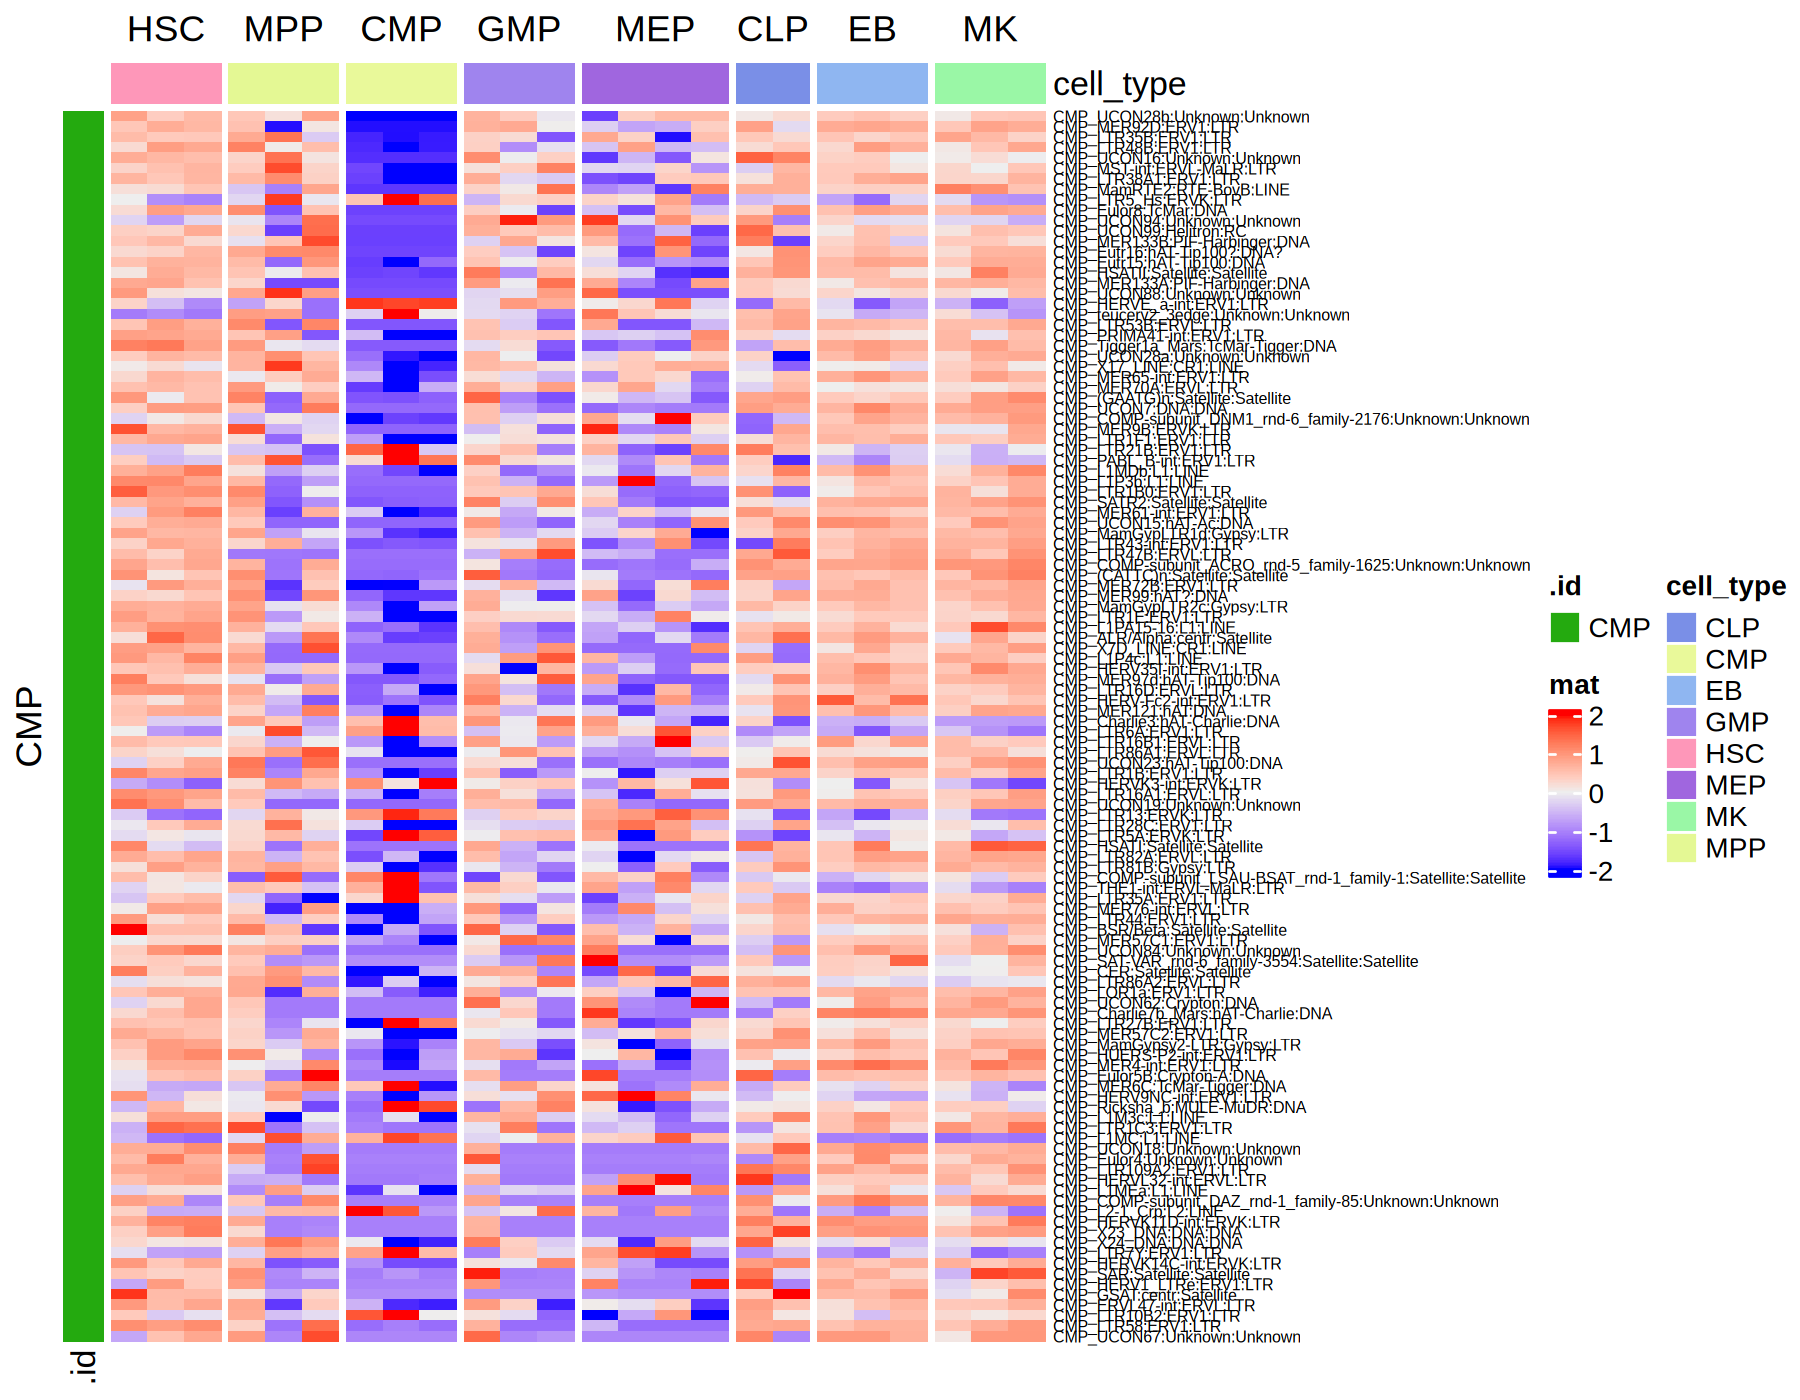

In [78]:
# significant TEs
options(repr.plot.width = 9, repr.plot.height = 7, repr.plot.res = 200)

row_sel = deg_te_dt[abs(logFC) > 1 & FDR < 0.1, ]
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_te))
row_sel = row_sel[rn %in% ov, ][.id == 'CMP', ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id,   row_names_gp = grid::gpar(fontsize = 5.5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

In [79]:
table(sign(row_sel$logFC))


-1  1 
98 20 

In [80]:
nrow( deg_te_dt[.id == 'MK' & logFC > 0 & FDR < 0.1, ] )

[1] 0

In [81]:
mk = deg_te_dt[logFC > 0 & .id == 'MK', ] %>% slice_min(order_by = PValue, n = 20)


In [82]:
head(deg_te_dt)

.id rn                      logFC      logCPM   PValue       FDR         
1 CMP UCON28b:Unknown:Unknown  -8.814440 3.694313 5.838190e-14 7.140106e-11
2 CMP MER92D:ERV1:LTR         -11.851777 4.025914 1.570117e-09 9.601264e-07
3 CMP LTR35B:ERV1:LTR          -8.011572 4.518548 2.525518e-08 1.029569e-05
4 CMP LTR48B:ERV1:LTR          -1.501265 7.159887 1.682623e-07 5.144618e-05
5 CMP UCON16:Unknown:Unknown  -10.548174 2.734939 2.903848e-07 7.102812e-05
6 CMP MST-int:ERVL-MaLR:LTR    -3.356113 4.905069 4.055150e-07 8.265747e-05

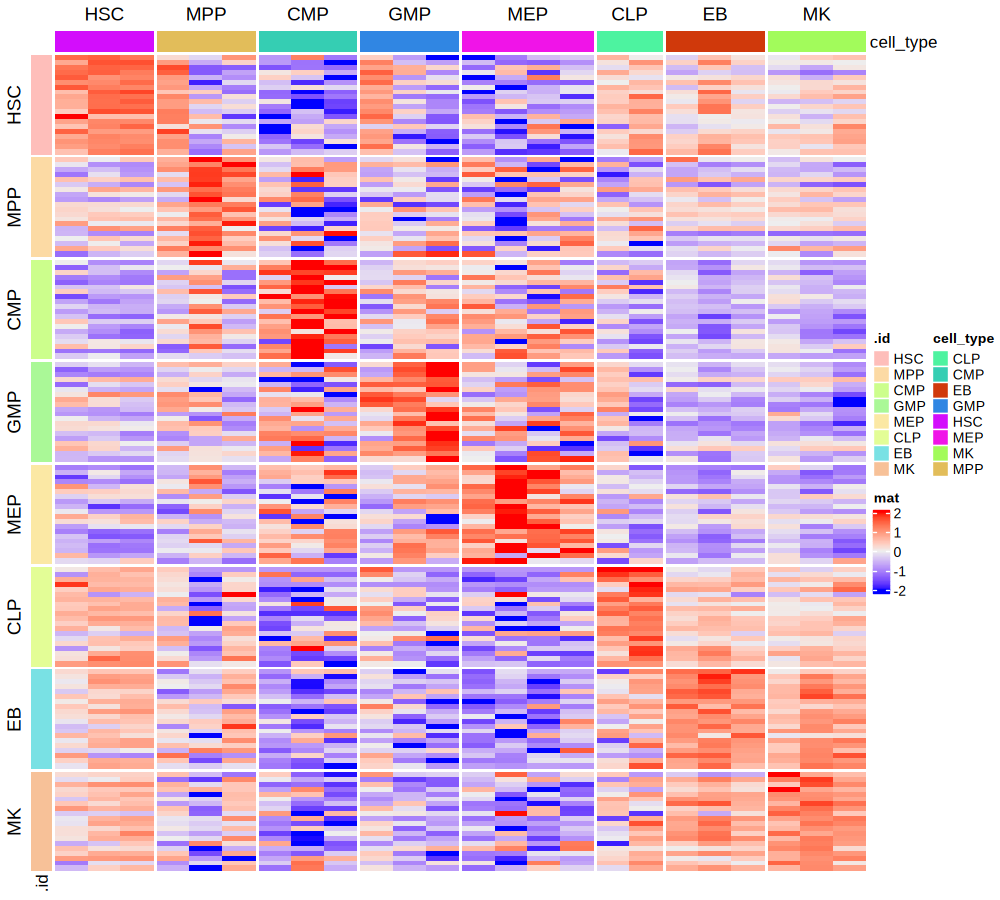

In [83]:
# top 20 up-regulated te genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_te))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

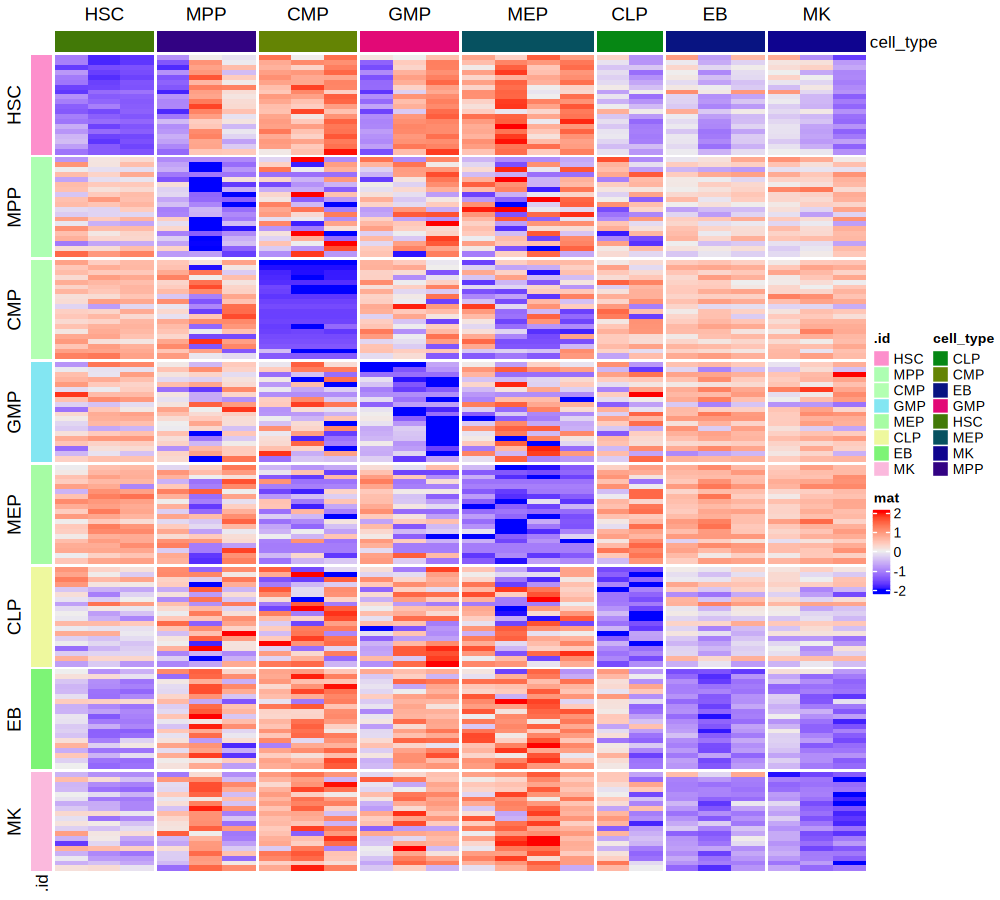

In [84]:
# top 20 up-regulated te genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_te_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_te))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


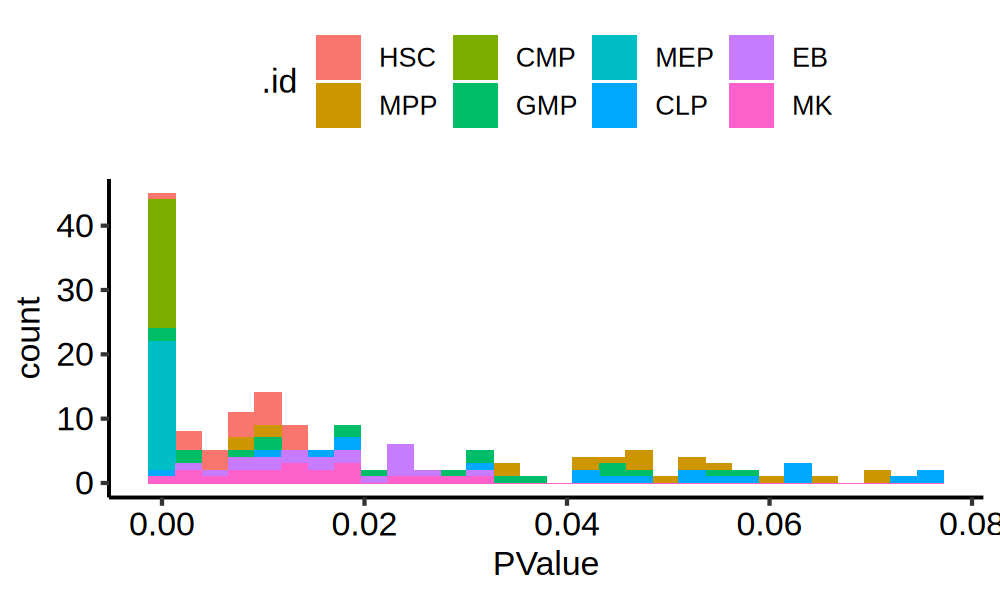

In [86]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = PValue, fill = .id)) + geom_histogram() + theme_pubr()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


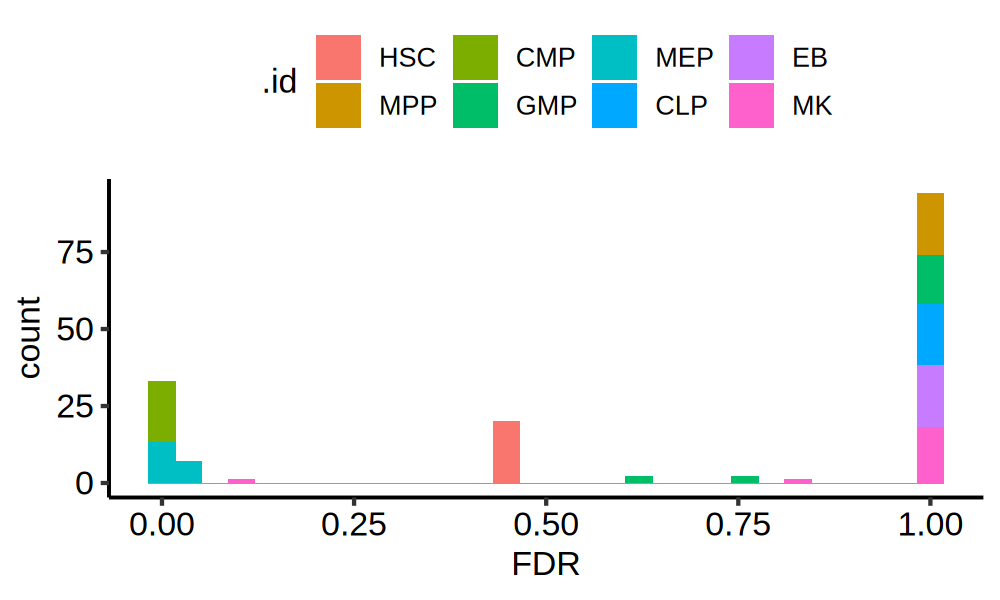

In [85]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = FDR, fill = .id)) + geom_histogram() + theme_pubr()


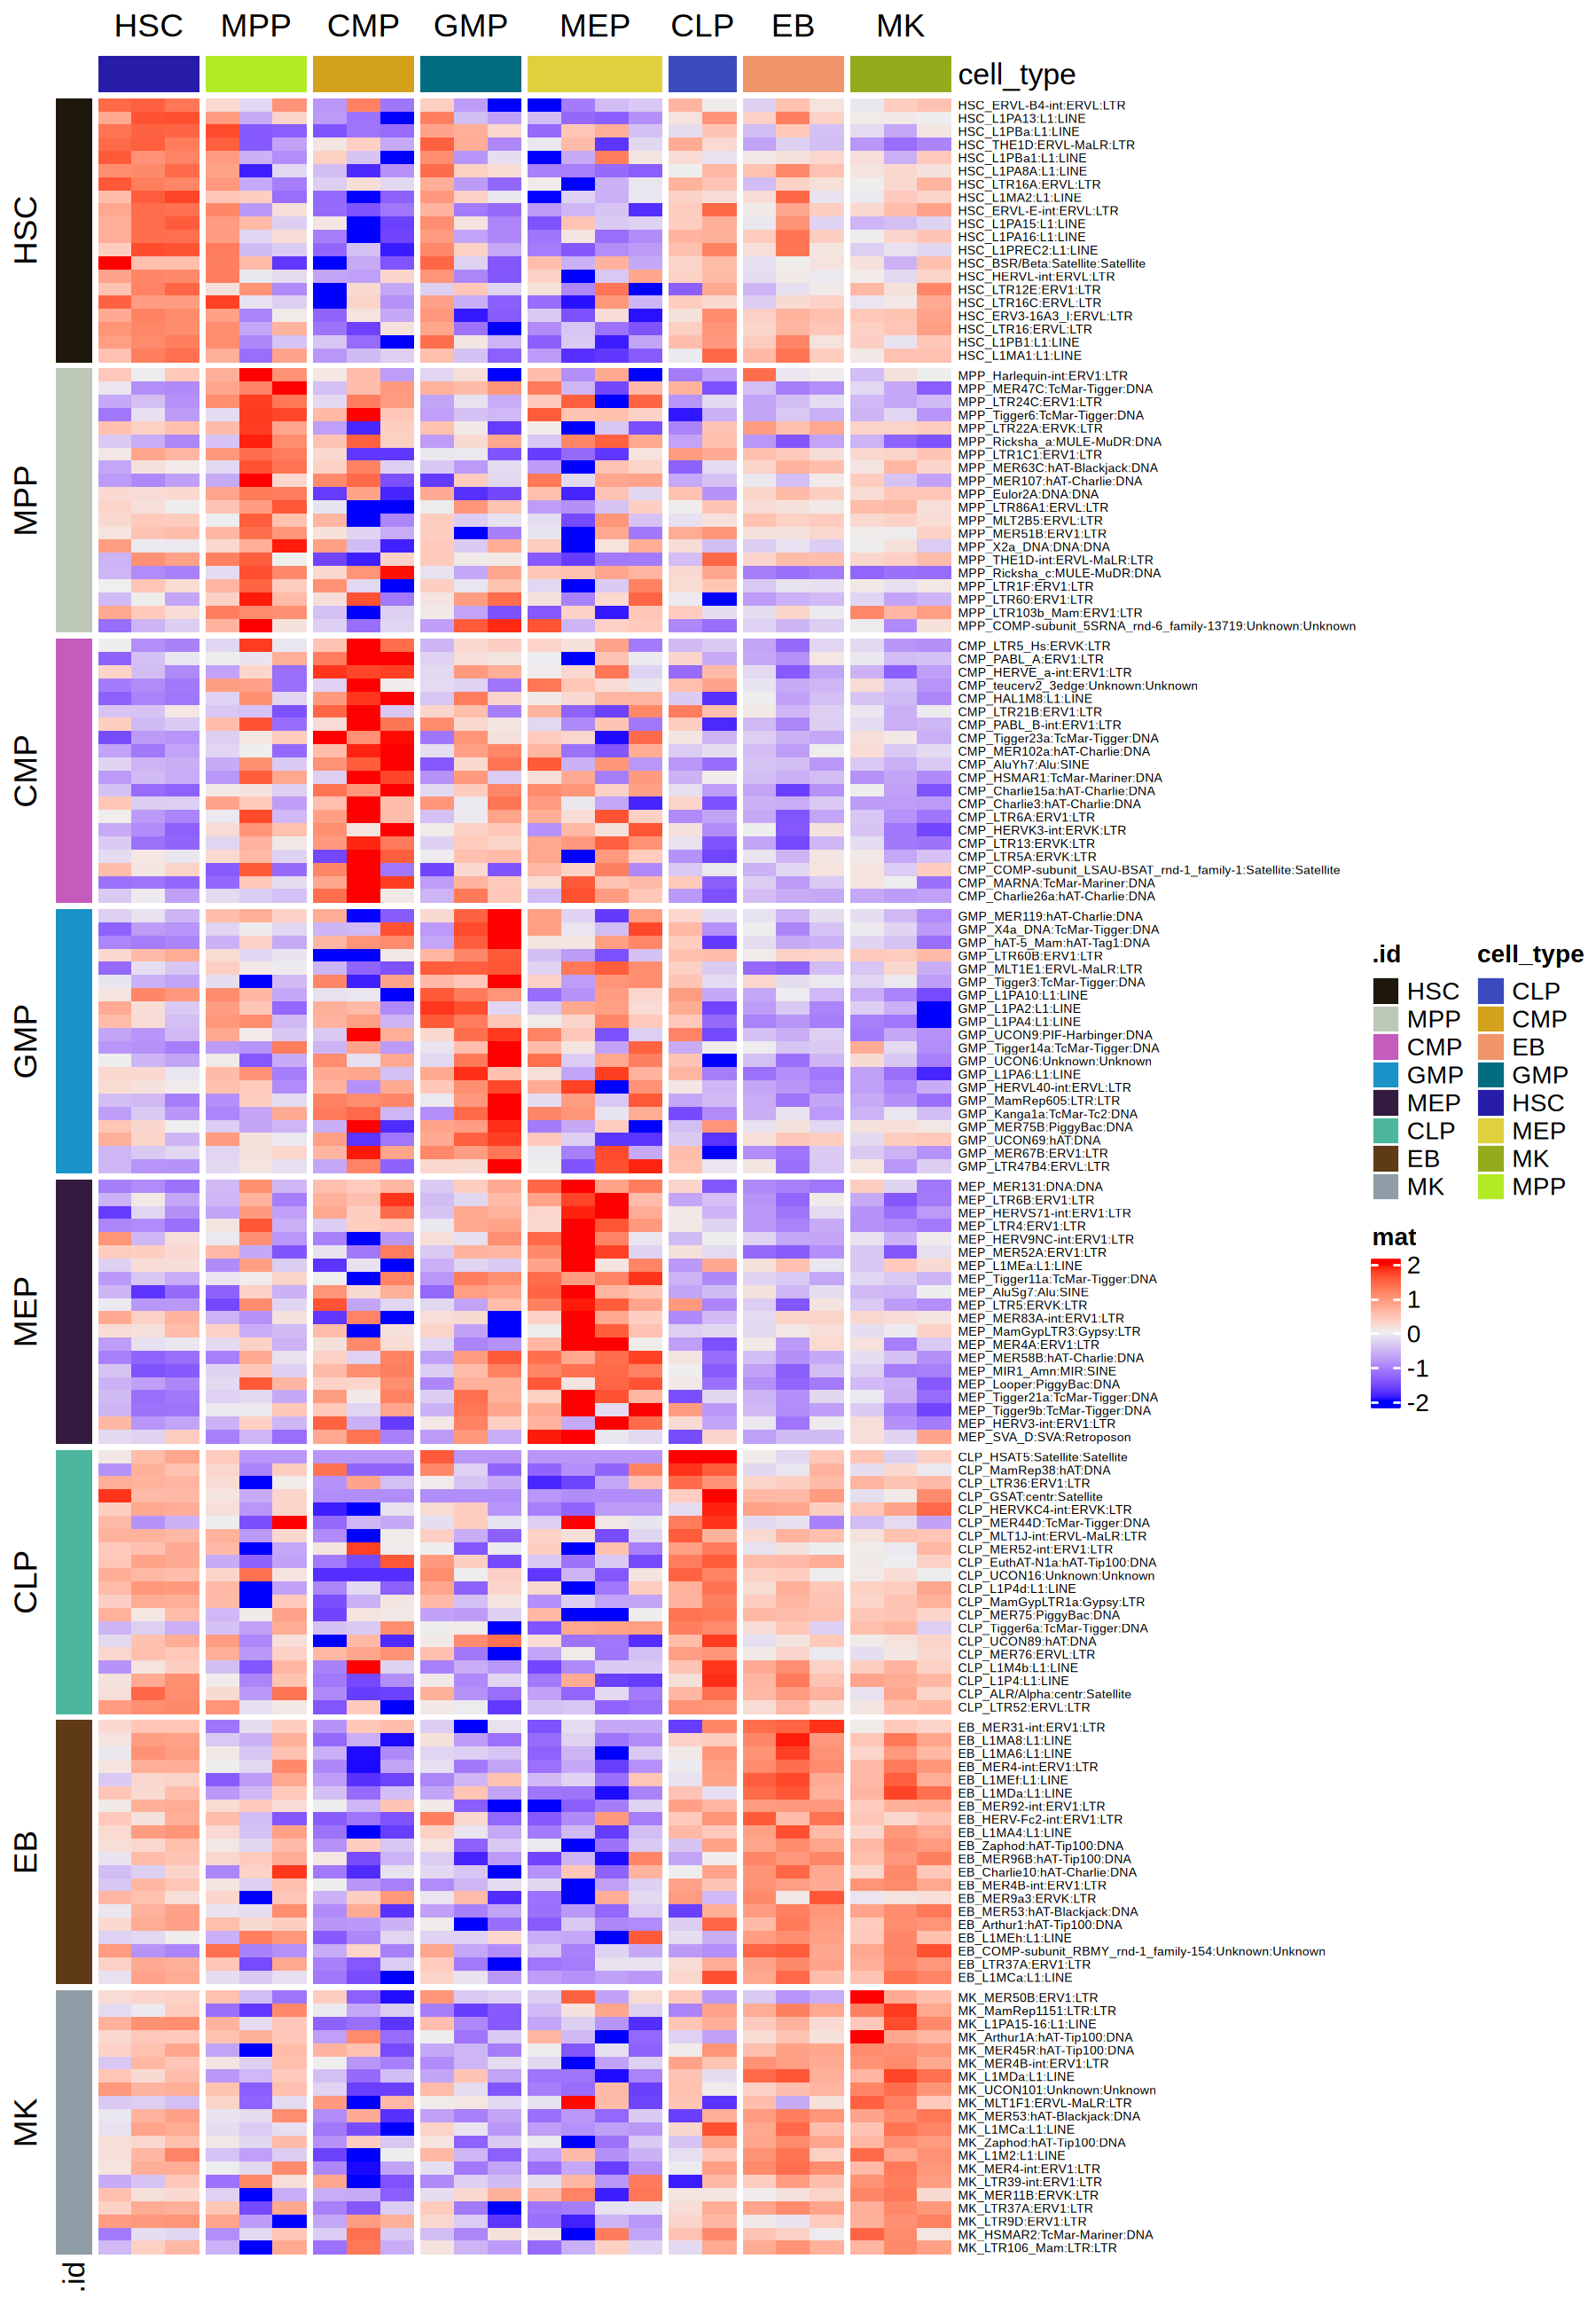

In [87]:
# top 20 up-regulated te genes for each cell type
options(repr.plot.width = 9, repr.plot.height = 13, repr.plot.res = 200)

row_sel = deg_te_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_te))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, row_names_gp = grid::gpar(fontsize = 5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


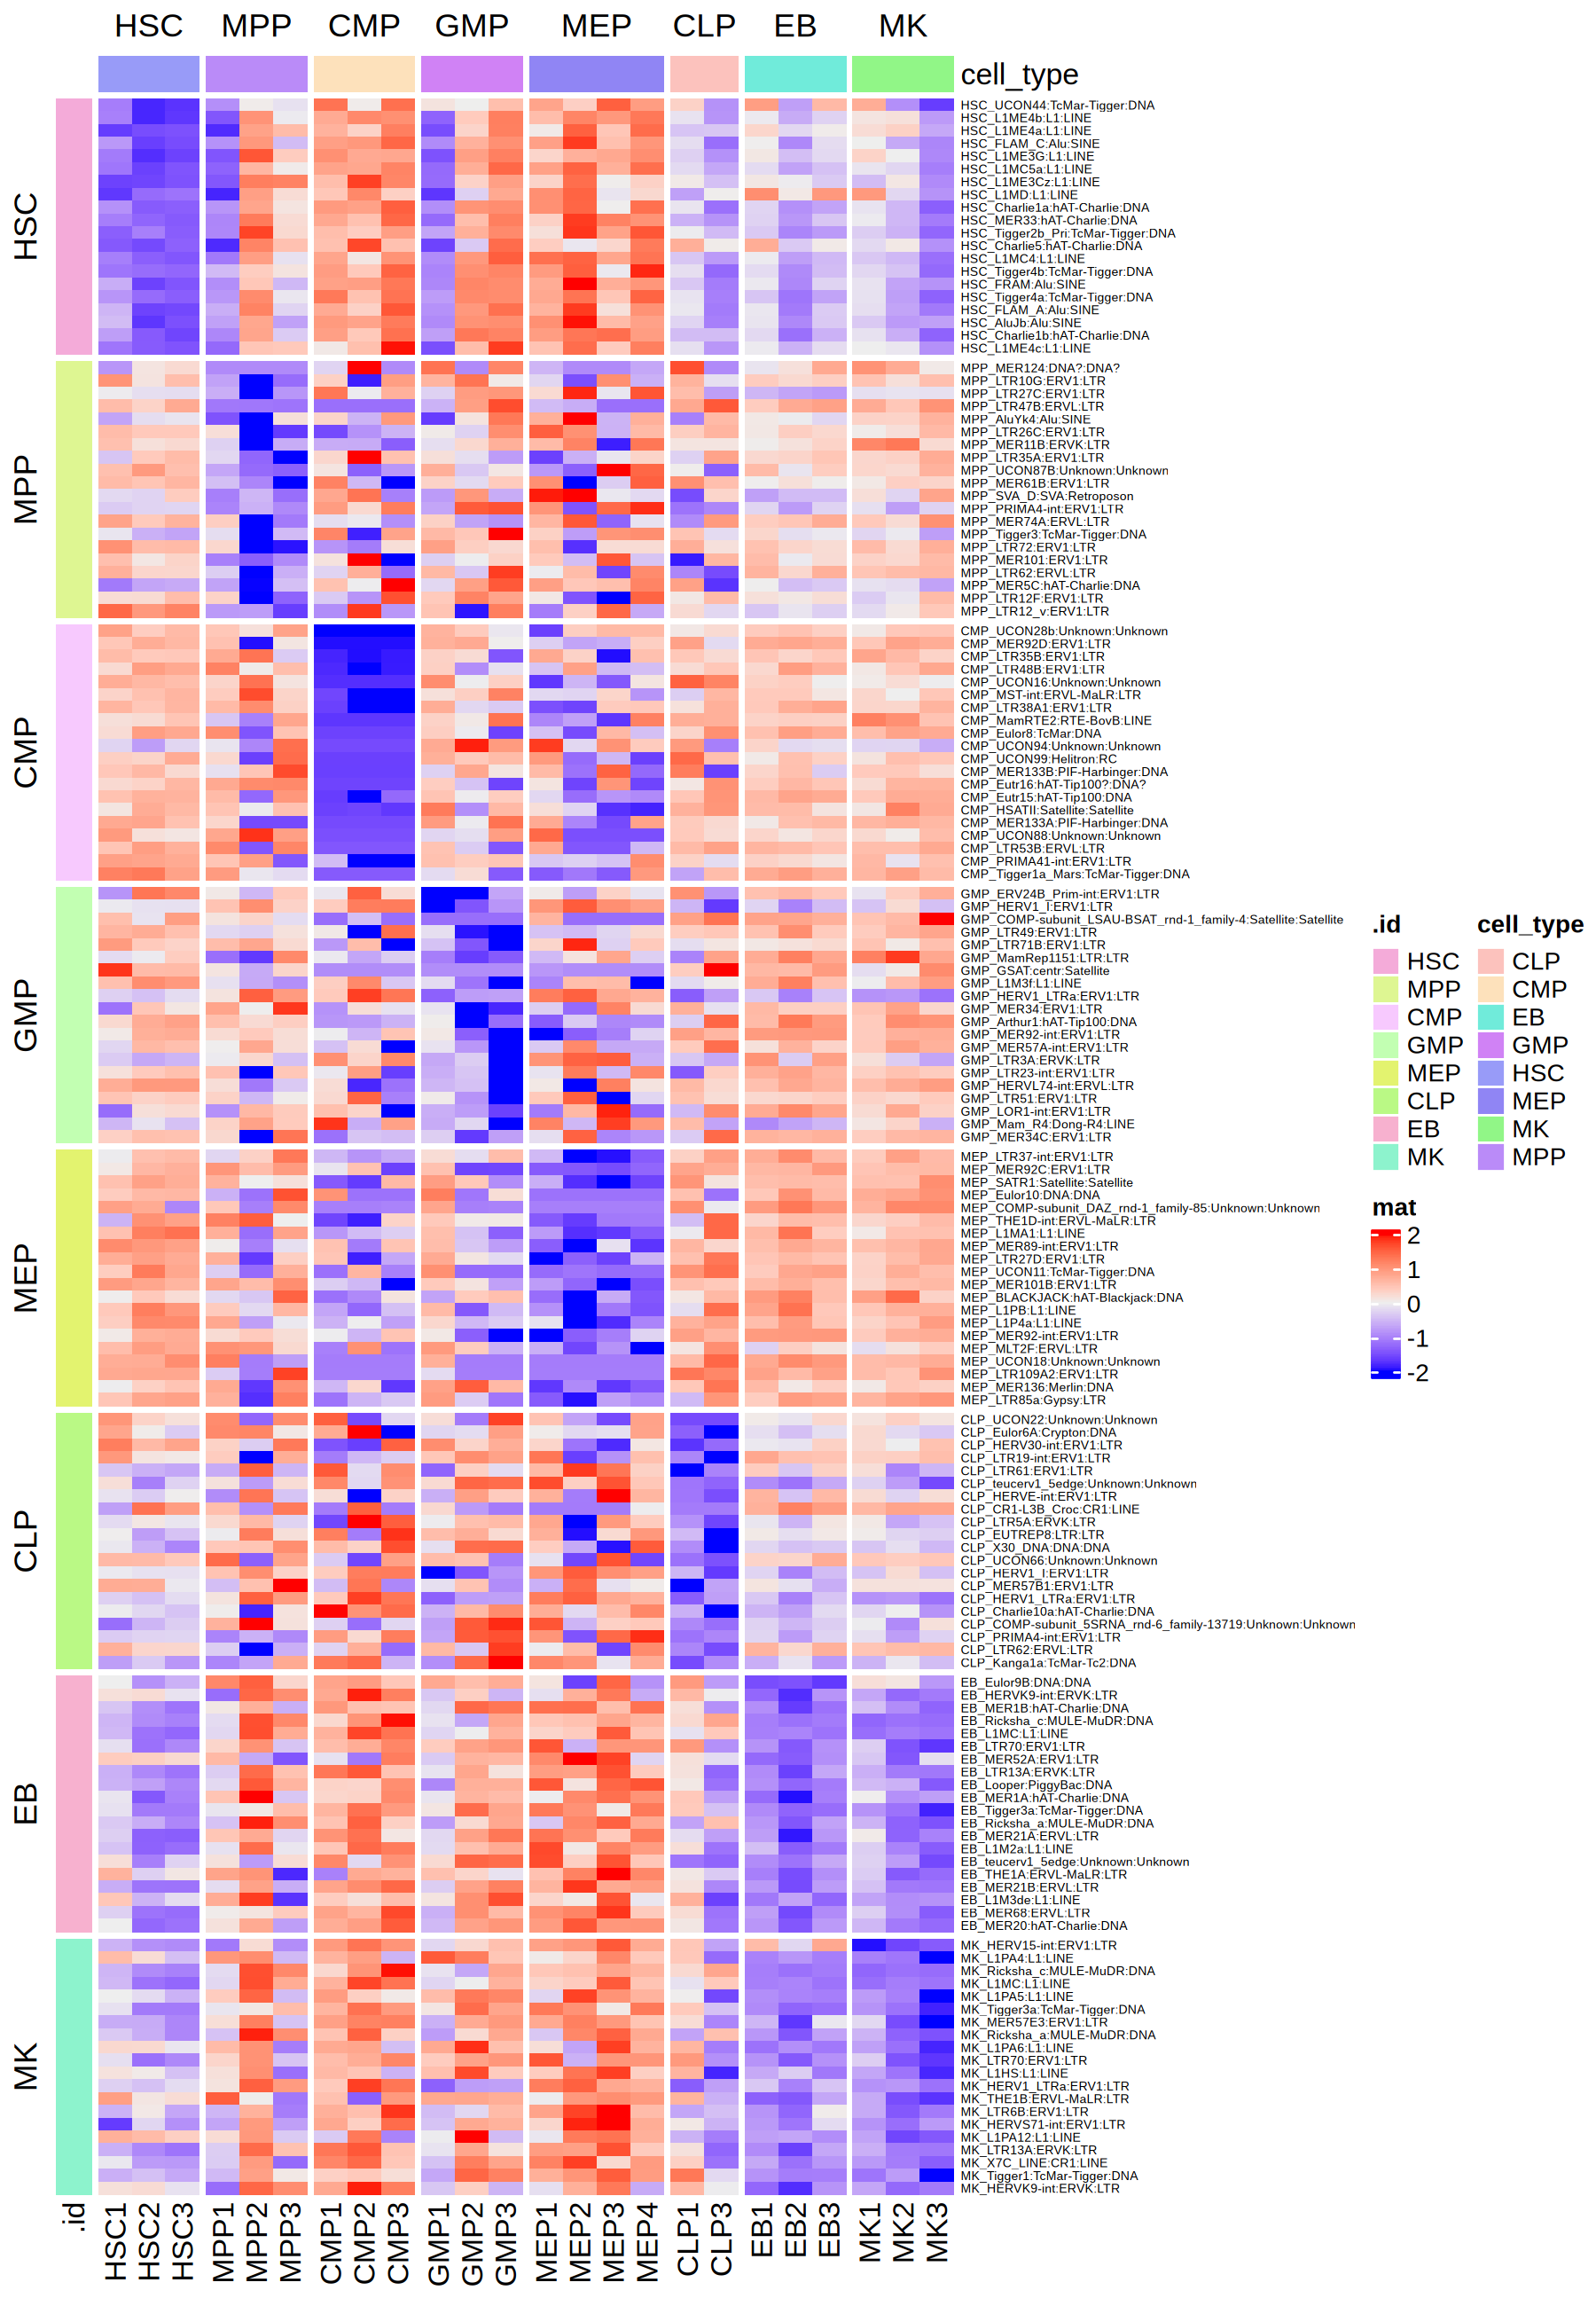

In [88]:
# top 20 down-regulated te genes for each cell type
options(repr.plot.width = 9, repr.plot.height = 13, repr.plot.res = 200)

row_sel = deg_te_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_te))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_te[row_sel$rn, rownames(dsn_all_df)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, row_names_gp = grid::gpar(fontsize = 5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


# TElocal DEG

## import telocal count data

In [89]:
# the TE family DEG based on TEcount analysis
deg_te_dt[, class_id := unlist(strsplit(rn, ':'))[3], by = 1:nrow(deg_te_dt)]
deg_te_dt[, family_id:= unlist(strsplit(rn, ':'))[2], by = 1:nrow(deg_te_dt)]
deg_te_dt[, gene_id := unlist(strsplit(rn, ':'))[1], by = 1:nrow(deg_te_dt)]

## decide the TEs to analysis


In [90]:
deg_te_dt[, idd := 1:nrow(deg_te_dt)]
deg_te_dt_sel = deg_te_dt %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
deg_te_dt_sel = rbind(deg_te_dt_sel, deg_te_dt[FDR < 0.1,]) %>% as.data.table()
deg_te_dt_sel = deg_te_dt_sel[!duplicated(idd), ]
head(deg_te_dt_sel)


.id rn                        logFC     logCPM   PValue      FDR class_id 
1 CLP UCON22:Unknown:Unknown    -9.720384 1.984300 0.001078845 1   Unknown  
2 CLP HSAT5:Satellite:Satellite  3.719413 1.210646 0.007997290 1   Satellite
3 CLP Eulor6A:Crypton:DNA       -3.394786 3.572595 0.011159710 1   DNA      
4 CLP HERV30-int:ERV1:LTR       -4.893633 3.922207 0.015425309 1   LTR      
5 CLP LTR19-int:ERV1:LTR        -2.013118 5.298446 0.017280830 1   LTR      
6 CLP LTR61:ERV1:LTR            -1.771854 6.173809 0.017489644 1   LTR      
  family_id gene_id    idd
1 Unknown   UCON22     125
2 Satellite HSAT5      321
3 Crypton   Eulor6A    401
4 ERV1      HERV30-int 486
5 ERV1      LTR19-int  513
6 ERV1      LTR61      515

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 4 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 16 rows containing missing values (`geom_bar()`)."


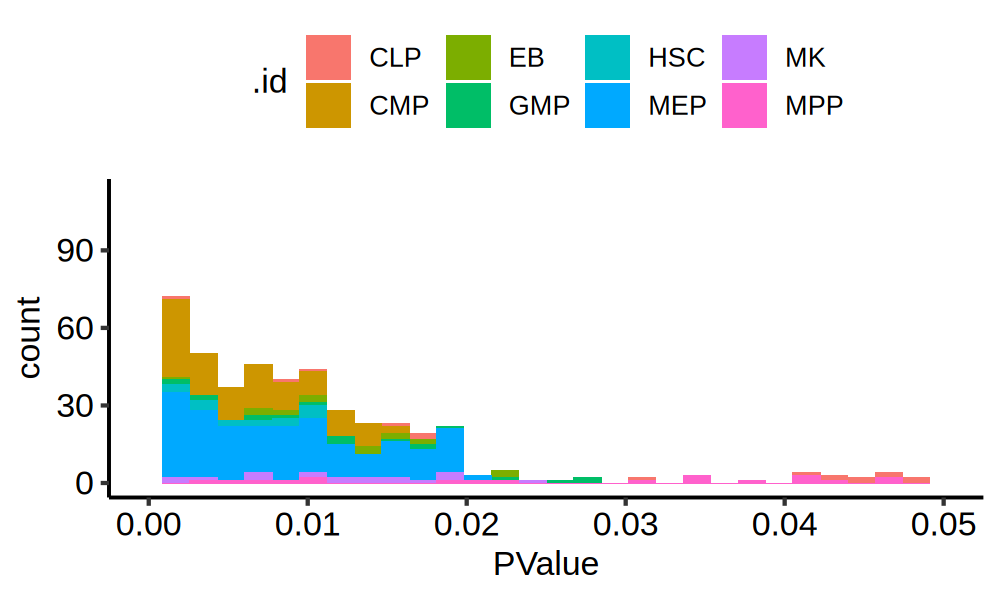

In [93]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(deg_te_dt_sel, aes(x = PValue, fill = .id)) + geom_histogram() + theme_pubr() + xlim(0, 0.05)


In [94]:
length(intersect(deg_te_dt_sel$family_id, te_dt$family_id))
length(intersect(deg_te_dt_sel$gene_id, te_dt$gene_id))
length(unique(deg_te_dt_sel$gene_id))


[1] 39

[1] 471

[1] 471

In [ ]:
- The first column corresponds to the rosette file column on which the read count was performed.
- If more than one variable column was provided in the rosette file, they will be put after the first column.
- The next following column(s), but the last, correspond to the number of mapping reads for each sample (fastq/sam files).
- The last column corresponds to the total of these counts.

## load TElocal count

In [100]:
telocal_list = lapply(1:nrow(dsn6), function (xx) {
    fname = dsn6[xx, telocal_count_file_ori]
    tmp = fread(fname)
    setnames(tmp, 1, 'gene')
    setnames(tmp, 2, 'count')
})


In [101]:
names(telocal_list) = dsn6$sample_name_id
telocal_dt = rbindlist(telocal_list, idcol = T)


In [102]:
telocal_dt[1:10, ]

.id  gene     count
1  MEP1 A1BG     239  
2  MEP1 A1BG-AS1 138  
3  MEP1 A1CF       0  
4  MEP1 A2M      502  
5  MEP1 A2M-AS1  594  
6  MEP1 A2ML1      0  
7  MEP1 A2MP1    204  
8  MEP1 A3GALT2    6  
9  MEP1 A4GALT     0  
10 MEP1 A4GNT      0

In [103]:
# there are multiple bam file for a same cell type sample, aggregate them
telocal_dt[, tag := paste0(.id, '_', gene)]
telocal_dt[, count_agg := sum(.SD$count), by = 'tag' ]
setkey(telocal_dt, 'tag')
telocal_dt_agg = telocal_dt[!duplicated(tag), ]


In [ ]:
#con <- dbConnect(RSQLite::SQLite(), "data/bluepring_telocal.sqlite")
#dbWriteTable(con, "bp_telocal_agg", telocal_dt_agg)
#dbSendStatement(con, 'CREATE INDEX `fk_agg_tag` ON `bp_telocal_agg` (`tag` ASC);')
#dbWriteTable(con, "te_gtf", te_dt)


In [108]:
telocal_dt_w = readRDS('data/telocal_dt_w.rds')
telocal_dt_w[1:3, 1:10]


gene                                         CLP1 CLP2 CLP3 CMP1 CMP2 CMP3
1 (CATTC)n:(CATTC)n:Satellite:Satellite         0   0     0   0    0    0   
2 (CATTC)n_dup100:(CATTC)n:Satellite:Satellite 14   1     9   0    0    0   
3 (CATTC)n_dup101:(CATTC)n:Satellite:Satellite  7   0    15   0    0    0   
  EB1 EB2 EB3
1 0   0   0  
2 2   2   1  
3 2   0   2

## filter TElocal

In [138]:
telocal_dt_w_te = telocal_dt_w[!gene %in% coding_genes, ]
telocal_dt_w_te[, CLP2 := NULL]

In [ ]:
# make small table to get the family & class information separately for filtering with the deg_te_dt_sel
telocal_dt_w_meta = data.table(gene = telocal_dt_w_te$gene)
telocal_dt_w_meta[, class_id := unlist(strsplit(gene, ':'))[4], by = 1:nrow(telocal_dt_w_meta)]
telocal_dt_w_meta[, family_id:= unlist(strsplit(gene, ':'))[3], by = 1:nrow(telocal_dt_w_meta)]
telocal_dt_w_meta[, gene_id := unlist(strsplit(gene, ':'))[2], by = 1:nrow(telocal_dt_w_meta)]
telocal_dt_w_meta[, tx_id := unlist(strsplit(gene, ':'))[1], by = 1:nrow(telocal_dt_w_meta)]
telocal_dt_w_meta[, nn := length(unlist(strsplit(gene, ':'))), by = 1:nrow(telocal_dt_w_meta)]
telocal_dt_w_meta[, ifTE := T]
telocal_dt_w_meta[gene %in% coding_genes, ifTE := F]
telocal_dt_w_meta[, tag := paste0(gene_id, ':', family_id, ':', class_id)]


In [144]:
telocal_dt_w_meta[, tag := paste0(gene_id, ':', family_id, ':', class_id)]
head(telocal_dt_w_meta) 


gene                                         class_id  family_id gene_id 
1 (CATTC)n:(CATTC)n:Satellite:Satellite        Satellite Satellite (CATTC)n
2 (CATTC)n_dup100:(CATTC)n:Satellite:Satellite Satellite Satellite (CATTC)n
3 (CATTC)n_dup101:(CATTC)n:Satellite:Satellite Satellite Satellite (CATTC)n
4 (CATTC)n_dup102:(CATTC)n:Satellite:Satellite Satellite Satellite (CATTC)n
5 (CATTC)n_dup103:(CATTC)n:Satellite:Satellite Satellite Satellite (CATTC)n
6 (CATTC)n_dup104:(CATTC)n:Satellite:Satellite Satellite Satellite (CATTC)n
  tx_id           nn ifTE tag                         
1 (CATTC)n        4  TRUE (CATTC)n:Satellite:Satellite
2 (CATTC)n_dup100 4  TRUE (CATTC)n:Satellite:Satellite
3 (CATTC)n_dup101 4  TRUE (CATTC)n:Satellite:Satellite
4 (CATTC)n_dup102 4  TRUE (CATTC)n:Satellite:Satellite
5 (CATTC)n_dup103 4  TRUE (CATTC)n:Satellite:Satellite
6 (CATTC)n_dup104 4  TRUE (CATTC)n:Satellite:Satellite

In [147]:
telocal_dt_w_sel = telocal_dt_w[gene %in% telocal_dt_w_meta[tag %in% deg_te_dt_sel$rn, gene], ]
dim(telocal_dt_w_sel)

[1] 2470919      26

In [148]:
head(telocal_dt_w_sel)

gene                                         CLP1 CLP2 CLP3 CMP1 CMP2 CMP3
1 (CATTC)n:(CATTC)n:Satellite:Satellite         0   0     0   0    0    0   
2 (CATTC)n_dup100:(CATTC)n:Satellite:Satellite 14   1     9   0    0    0   
3 (CATTC)n_dup101:(CATTC)n:Satellite:Satellite  7   0    15   0    0    0   
4 (CATTC)n_dup102:(CATTC)n:Satellite:Satellite  3   0     3   0    0    0   
5 (CATTC)n_dup103:(CATTC)n:Satellite:Satellite 19   0    19   0    0    0   
6 (CATTC)n_dup104:(CATTC)n:Satellite:Satellite 27   5    10   0    0    0   
  EB1 EB2 EB3 ⋯ MEP1 MEP2 MEP3 MEP4 MK1 MK2 MK3 MPP1 MPP2 MPP3
1 0   0   0   ⋯ 0    0    0    0    0    1   0   0   0    0   
2 2   2   1   ⋯ 1    0    0    0    1    8  34  35   0    7   
3 2   0   2   ⋯ 1    0    0    0    2   22  44  28   0    3   
4 1   4   2   ⋯ 0    0    0    0    2    9  19   1   0    5   
5 1   2   2   ⋯ 1    0    0    0    2   11  41  37   0    4   
6 4   4   5   ⋯ 0    0    0    0    5   22  64  24   0    2

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0      1.0     12.0     84.1     65.0 523492.0 

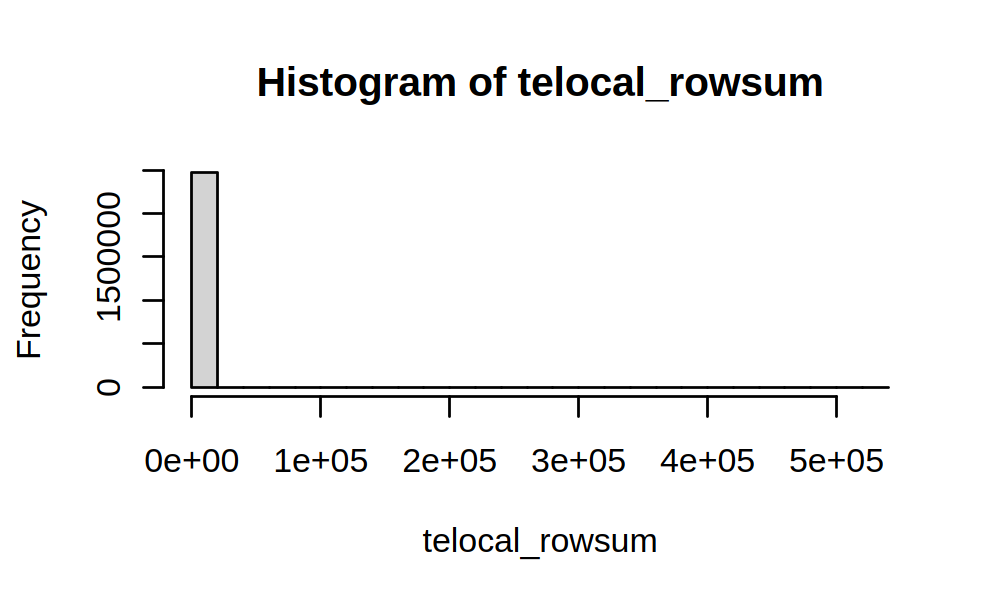

In [149]:
# calculate row sum
telocal_rowsum = rowSums(telocal_dt_w_sel[, 2:ncol(telocal_dt_w_te)])
summary(telocal_rowsum)
hist(telocal_rowsum)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     0.204     1.444     7.211     7.162 16710.467 

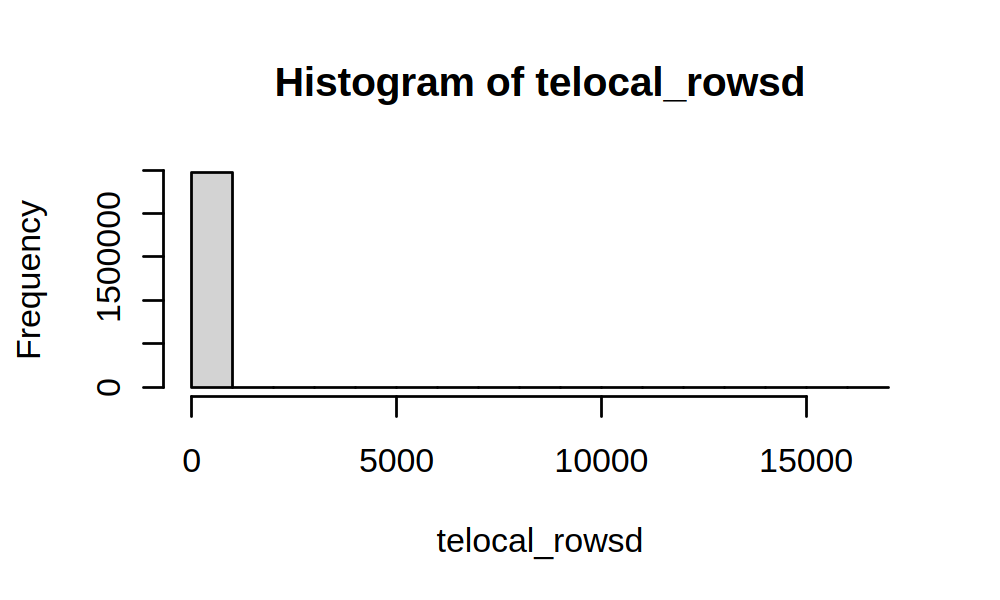

In [150]:
# calculate row variation SD
telocal_rowsd = rowSds(telocal_dt_w_sel[, 2:ncol(telocal_dt_w_te)])
summary(telocal_rowsd)
hist(telocal_rowsd)


In [152]:
telocal_dt_w_sel[, row_sum := telocal_rowsum]
telocal_dt_w_sel[, row_sd  := telocal_rowsd ]

In [158]:
telocal_dt_w_sel[, tag := paste(unlist(strsplit(.SD$gene, ':'))[2:4], collapse = ':'), by = 1:nrow(telocal_dt_w_sel)]

In [159]:
head(telocal_dt_w_sel)

gene                                         CLP1 CLP2 CLP3 CMP1 CMP2 CMP3
1 (CATTC)n:(CATTC)n:Satellite:Satellite         0   0     0   0    0    0   
2 (CATTC)n_dup100:(CATTC)n:Satellite:Satellite 14   1     9   0    0    0   
3 (CATTC)n_dup101:(CATTC)n:Satellite:Satellite  7   0    15   0    0    0   
4 (CATTC)n_dup102:(CATTC)n:Satellite:Satellite  3   0     3   0    0    0   
5 (CATTC)n_dup103:(CATTC)n:Satellite:Satellite 19   0    19   0    0    0   
6 (CATTC)n_dup104:(CATTC)n:Satellite:Satellite 27   5    10   0    0    0   
  EB1 EB2 EB3 ⋯ MEP4 MK1 MK2 MK3 MPP1 MPP2 MPP3 row_sum row_sd    
1 0   0   0   ⋯ 0    0    1   0   0   0    0      1      0.2041241
2 2   2   1   ⋯ 0    1    8  34  35   0    7    178     13.9062597
3 2   0   2   ⋯ 0    2   22  44  28   0    3    189     13.0827218
4 1   4   2   ⋯ 0    2    9  19   1   0    5     56      4.2289547
5 1   2   2   ⋯ 0    2   11  41  37   0    4    247     17.3342565
6 4   4   5   ⋯ 0    5   22  64  24   0    2    369     32.8974857
  tag                         
1 (CATTC)n:Satellite:Satellite
2 (CATTC)n:Satellite:Satellite
3 (CATTC)n:Satellite:Satellite
4 (CATTC)n:Satellite:Satellite
5 (CATTC)n:Satellite:Satellite
6 (CATTC)n:Satellite:Satellite

In [161]:
telocal_dt_w_te_sel_step2 = telocal_dt_w_te_sel[row_sum > 90, ]
head(telocal_dt_w_te_sel_step2) 
dim(telocal_dt_w_te_sel_step2) 


gene                                         CLP1 CLP2 CLP3 CMP1 CMP2 CMP3
1 (CATTC)n_dup100:(CATTC)n:Satellite:Satellite 14   1     9   0    0    0   
2 (CATTC)n_dup101:(CATTC)n:Satellite:Satellite  7   0    15   0    0    0   
3 (CATTC)n_dup103:(CATTC)n:Satellite:Satellite 19   0    19   0    0    0   
4 (CATTC)n_dup104:(CATTC)n:Satellite:Satellite 27   5    10   0    0    0   
5 (CATTC)n_dup105:(CATTC)n:Satellite:Satellite  9   0    10   0    0    0   
6 (CATTC)n_dup106:(CATTC)n:Satellite:Satellite 79   8    12   0    0    0   
  EB1 EB2 EB3 ⋯ MEP2 MEP3 MEP4 MK1 MK2 MK3 MPP1 MPP2 MPP3 row_sum
1 2    2  1   ⋯ 0    0    0    1    8  34  35   0    7    185    
2 2    0  2   ⋯ 0    0    0    2   22  44  28   0    3    192    
3 1    2  2   ⋯ 0    0    0    2   11  41  37   0    4    251    
4 4    4  5   ⋯ 0    0    0    5   22  64  24   0    2    371    
5 7   11  4   ⋯ 0    0    0    7    3  99  19   0    5    216    
6 2    6  2   ⋯ 0    0    0    7    9  68  34   0    8    366

[1] 776736     27

In [162]:
saveRDS(telocal_dt_w_te_sel_step2, file = 'data/telocal_dt_w_te_sel_step2_May28.rds')


## telocal DEG

In [178]:
dsn_telocal = data.frame(cell_type = sub('\\d+', '', sample_names_n24), row.names = sample_names_n24)
telocal_dt_w_te_sel_step2_mtx = setDF(telocal_dt_w_te_sel_step2[, rownames(dsn_telocal), with = F], rownames = telocal_dt_w_te_sel_step2$gene)
head(telocal_dt_w_te_sel_step2_mtx)
dim(telocal_dt_w_te_sel_step2_mtx)


HSC1 HSC2 HSC3 MPP1 MPP2 MPP3 CMP1
(CATTC)n_dup100:(CATTC)n:Satellite:Satellite  9   1     6   35   0    7    0   
(CATTC)n_dup101:(CATTC)n:Satellite:Satellite 12   3    10   28   0    3    0   
(CATTC)n_dup103:(CATTC)n:Satellite:Satellite 54   2     5   37   0    4    0   
(CATTC)n_dup104:(CATTC)n:Satellite:Satellite 36   3     8   24   0    2    0   
(CATTC)n_dup105:(CATTC)n:Satellite:Satellite 15   3     4   19   0    5    0   
(CATTC)n_dup106:(CATTC)n:Satellite:Satellite 56   1    13   34   0    8    0   
                                             CMP2 CMP3 GMP1 ⋯ MEP3 MEP4 CLP1
(CATTC)n_dup100:(CATTC)n:Satellite:Satellite 0    0     54  ⋯ 0    0    14  
(CATTC)n_dup101:(CATTC)n:Satellite:Satellite 0    0     41  ⋯ 0    0     7  
(CATTC)n_dup103:(CATTC)n:Satellite:Satellite 0    0     51  ⋯ 0    0    19  
(CATTC)n_dup104:(CATTC)n:Satellite:Satellite 0    0    152  ⋯ 0    0    27  
(CATTC)n_dup105:(CATTC)n:Satellite:Satellite 0    0     20  ⋯ 0    0     9  
(CATTC)n_dup106:(CATTC)n:Satellite:Satellite 0    0     61  ⋯ 0    0    79  
                                             CLP3 EB1 EB2 EB3 MK1 MK2 MK3
(CATTC)n_dup100:(CATTC)n:Satellite:Satellite  9   2    2  1   1    8  34 
(CATTC)n_dup101:(CATTC)n:Satellite:Satellite 15   2    0  2   2   22  44 
(CATTC)n_dup103:(CATTC)n:Satellite:Satellite 19   1    2  2   2   11  41 
(CATTC)n_dup104:(CATTC)n:Satellite:Satellite 10   4    4  5   5   22  64 
(CATTC)n_dup105:(CATTC)n:Satellite:Satellite 10   7   11  4   7    3  99 
(CATTC)n_dup106:(CATTC)n:Satellite:Satellite 12   2    6  2   7    9  68

[1] 776736     24

In [185]:
# get logcpm
subtype = factor(dsn_telocal$cell_type, levels = c(cell_types))

dge = DGEList(counts=telocal_dt_w_te_sel_step2_mtx, group = subtype)
dge <- calcNormFactors(dge)

dge = normLibSizes(dge)
design = model.matrix( ~ 0 + subtype)
dge = estimateDisp(dge, design)

logcpm_telocal = log1p(cpm(dge, normalize = T))
saveRDS(dge, file = 'data/dge_telocal_may28.rds')
saveRDS(logcpm_telocal, file = 'data/logcpm_telocal_may28.rds')


In [222]:
logcpm_telocal = readRDS('data/logcpm_telocal_may28.rds')
row_sd = rowSds(logcpm_telocal)
summary(row_sd)
length(row_sd)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4774  0.5853  0.6269  0.7324  2.7689 

[1] 776736

In [224]:
#telocal_dt_w_te_sel_step3 = telocal_dt_w_te_sel_step2[row_sd > 1.234, ]
telocal_dt_w_te_sel_step3 = telocal_dt_w_te_sel_step2[row_sd > .73, ]
dim(telocal_dt_w_te_sel_step3)
head(telocal_dt_w_te_sel_step3)


[1] 196498     27

gene                                         CLP1 CLP2 CLP3 CMP1 CMP2 CMP3
1 (CATTC)n_dup107:(CATTC)n:Satellite:Satellite  44  0    45   0    0    0   
2 (CATTC)n_dup109:(CATTC)n:Satellite:Satellite 105  1    26   0    0    0   
3 (CATTC)n_dup113:(CATTC)n:Satellite:Satellite  46  0    27   0    0    0   
4 (CATTC)n_dup115:(CATTC)n:Satellite:Satellite  31  6    69   0    0    0   
5 (CATTC)n_dup122:(CATTC)n:Satellite:Satellite  36  2    40   0    0    0   
6 (CATTC)n_dup166:(CATTC)n:Satellite:Satellite   0  0     0   0    0    0   
  EB1 EB2 EB3 ⋯ MEP2 MEP3 MEP4 MK1 MK2 MK3 MPP1 MPP2 MPP3 row_sum
1 5    6   8  ⋯ 0    0    0    4   10  161  35  0    10   480    
2 1    5   5  ⋯ 0    0    0    4   21   95  46  0    19   771    
3 3   16   4  ⋯ 0    0    0    5   36   81 130  0    25   600    
4 7   10   8  ⋯ 0    0    0    6   51  125  57  0    20   537    
5 4    2   4  ⋯ 0    0    0    2   26  136  52  0    28   687    
6 9   78  14  ⋯ 0    0    0    5   36   93   0  0     0   361

In [225]:
# get logcpm
subtype = factor(dsn_telocal$cell_type, levels = c(cell_types))

telocal_dt_w_te_sel_step3_mtx = setDF(telocal_dt_w_te_sel_step3[, rownames(dsn_telocal), with = F], rownames = telocal_dt_w_te_sel_step3$gene)

dge = DGEList(counts=telocal_dt_w_te_sel_step3_mtx, group = subtype)
dge <- calcNormFactors(dge)

dge = normLibSizes(dge)
design = model.matrix( ~ 0 + subtype)
dge = estimateDisp(dge, design)

logcpm_telocal = log1p(cpm(dge, normalize = T))
saveRDS(dge, file = 'data/dge_telocal__step3_may28.rds')
saveRDS(logcpm_telocal, file = 'data/logcpm_telocal_step3_may28.rds')


In [226]:
dim(logcpm_telocal)
head(logcpm_telocal)

[1] 196498     24

HSC1     HSC2      HSC3    
(CATTC)n_dup107:(CATTC)n:Satellite:Satellite 1.235691 0.6610657 1.970068
(CATTC)n_dup109:(CATTC)n:Satellite:Satellite 2.822737 1.4165450 2.141562
(CATTC)n_dup113:(CATTC)n:Satellite:Satellite 1.583411 0.4852433 1.559483
(CATTC)n_dup115:(CATTC)n:Satellite:Satellite 1.283454 0.9405640 1.970068
(CATTC)n_dup122:(CATTC)n:Satellite:Satellite 1.942424 0.8105482 2.202693
(CATTC)n_dup166:(CATTC)n:Satellite:Satellite 0.000000 1.2522717 0.000000
                                             MPP1     MPP2 MPP3      CMP1 CMP2
(CATTC)n_dup107:(CATTC)n:Satellite:Satellite 1.508438 0    0.8691791 0    0   
(CATTC)n_dup109:(CATTC)n:Satellite:Satellite 1.727371 0    1.2896208 0    0   
(CATTC)n_dup113:(CATTC)n:Satellite:Satellite 2.644261 0    1.4956824 0    0   
(CATTC)n_dup115:(CATTC)n:Satellite:Satellite 1.906876 0    1.3270496 0    0   
(CATTC)n_dup122:(CATTC)n:Satellite:Satellite 1.829250 0    1.5847078 0    0   
(CATTC)n_dup166:(CATTC)n:Satellite:Satellite 0.000000 0    0.0000000 0    0   
                                             CMP3 GMP1     ⋯ MEP3 MEP4 CLP1    
(CATTC)n_dup107:(CATTC)n:Satellite:Satellite 0    2.296164 ⋯ 0    0    1.464526
(CATTC)n_dup109:(CATTC)n:Satellite:Satellite 0    3.185004 ⋯ 0    0    2.190069
(CATTC)n_dup113:(CATTC)n:Satellite:Satellite 0    2.955064 ⋯ 0    0    1.498875
(CATTC)n_dup115:(CATTC)n:Satellite:Satellite 0    2.250735 ⋯ 0    0    1.206857
(CATTC)n_dup122:(CATTC)n:Satellite:Satellite 0    3.352715 ⋯ 0    0    1.313954
(CATTC)n_dup166:(CATTC)n:Satellite:Satellite 0    2.640333 ⋯ 0    0    0.000000
                                             CLP3     EB1       EB2      
(CATTC)n_dup107:(CATTC)n:Satellite:Satellite 1.953432 1.0877799 1.0409929
(CATTC)n_dup109:(CATTC)n:Satellite:Satellite 1.503455 0.3318442 0.9269100
(CATTC)n_dup113:(CATTC)n:Satellite:Satellite 1.532926 0.7796033 1.7724758
(CATTC)n_dup115:(CATTC)n:Satellite:Satellite 2.330301 1.3230216 1.3995509
(CATTC)n_dup122:(CATTC)n:Satellite:Satellite 1.853217 0.9455165 0.4766539
(CATTC)n_dup166:(CATTC)n:Satellite:Satellite 0.000000 1.5133280 3.2115030
                                             EB3      MK1       MK2     
(CATTC)n_dup107:(CATTC)n:Satellite:Satellite 1.610045 0.7230071 1.133393
(CATTC)n_dup109:(CATTC)n:Satellite:Satellite 1.253305 0.7230071 1.690644
(CATTC)n_dup113:(CATTC)n:Satellite:Satellite 1.099118 0.8440536 2.149695
(CATTC)n_dup115:(CATTC)n:Satellite:Satellite 1.610045 0.9520171 2.463130
(CATTC)n_dup122:(CATTC)n:Satellite:Satellite 1.099118 0.4254705 1.868113
(CATTC)n_dup166:(CATTC)n:Satellite:Satellite 2.080105 0.8440536 2.149695
                                             MK3     
(CATTC)n_dup107:(CATTC)n:Satellite:Satellite 3.334723
(CATTC)n_dup109:(CATTC)n:Satellite:Satellite 2.831643
(CATTC)n_dup113:(CATTC)n:Satellite:Satellite 2.682347
(CATTC)n_dup115:(CATTC)n:Satellite:Satellite 3.091839
(CATTC)n_dup122:(CATTC)n:Satellite:Satellite 3.172500
(CATTC)n_dup166:(CATTC)n:Satellite:Satellite 2.811632

In [227]:
deg_telocal_list = lapply(cell_types, function(cc){
    dsn_telocal$ctype = 'Other'
    dsn_telocal$ctype[dsn_telocal$cell_type == cc] = cc
    dsn_telocal$ctype = factor(dsn_telocal$ctype, levels = c('Other', cc))

    subtype = factor(dsn_telocal$ctype, levels = c('Other', cc))

    dge = DGEList(counts=telocal_dt_w_te_sel_step3_mtx, group = subtype)
    dge <- calcNormFactors(dge)

    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = nrow(telocal_dt_w_te_sel_step3_mtx))
    deg = as.data.table(deg$table, keep.rownames = T)
    deg
})



In [228]:
names(deg_telocal_list) = cell_types
deg_telocal_dt = rbindlist(deg_telocal_list, idcol = T)
head(deg_telocal_dt)


.id rn                                         logFC    logCPM   PValue      
1 HSC LTR9_dup31:HUERS-P3-int:ERV1:LTR           5.534471 2.417498 0.0003921425
2 HSC L1PA6_dup1395:L1PA6:L1:LINE                6.601486 1.610521 0.0005174624
3 HSC L1M1_dup747:L1M1:L1:LINE                   6.144294 1.747831 0.0006237135
4 HSC L1PA4_dup1026:L1PA4:L1:LINE                6.078474 1.408738 0.0010115060
5 HSC L1PA8A_dup382:L1PA8A:L1:LINE               5.464224 1.973946 0.0011485502
6 HSC ALR/Alpha_dup968:ALR/Alpha:centr:Satellite 5.161282 2.277743 0.0014028469
  FDR      
1 0.9520505
2 0.9520505
3 0.9520505
4 0.9520505
5 0.9520505
6 0.9520505

In [229]:
saveRDS(deg_telocal_dt, file = 'data/deg_telocal_list_may28.rds')
fwrite(deg_telocal_dt, file = 'data/deg_telocal_dt_may28.xls', sep = '\t')


# telocal heatmap

In [230]:
table(deg_telocal_dt[FDR < .1, .id])


CLP  EB MEP  MK MPP 
  1 177 904 260  21 

In [231]:
telocal_list = list()

In [232]:
cell_types

[1] "HSC" "MPP" "CMP" "GMP" "MEP" "CLP" "EB"  "MK"

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



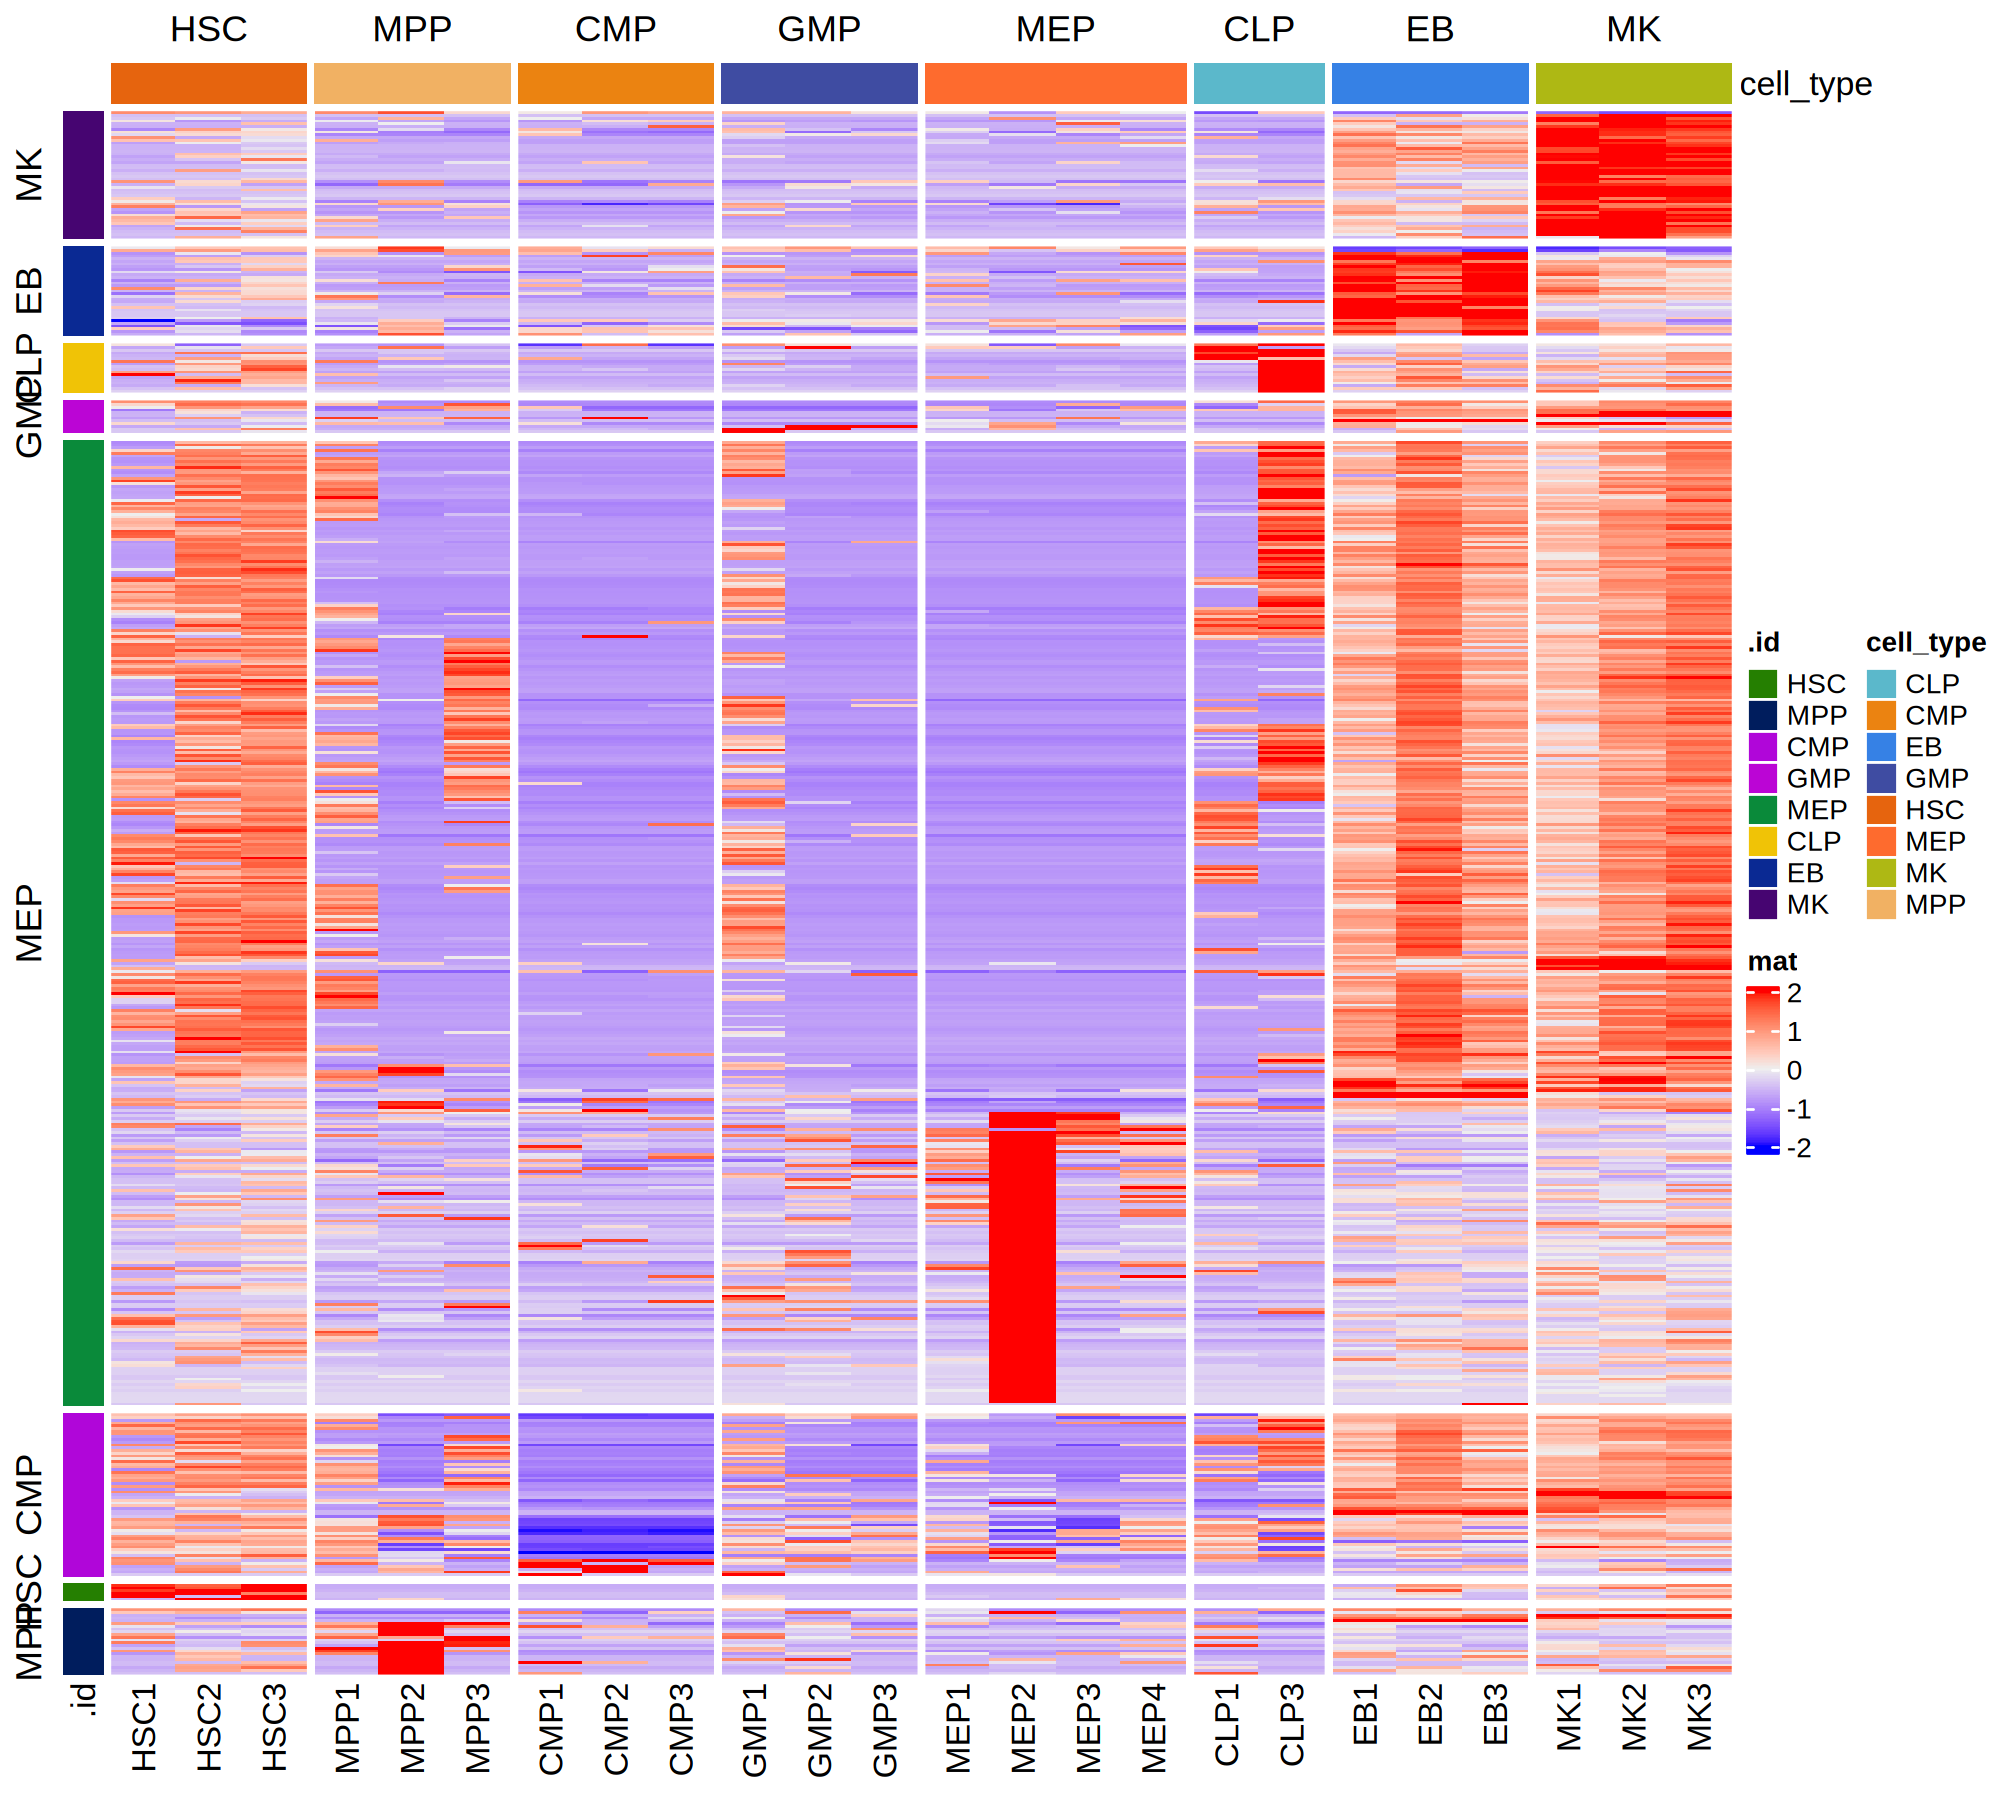

In [233]:
# all sig ones with FDr < 0.1
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 200)

row_sel = deg_telocal_dt[ PValue < 0.01 & abs(logFC) > 1, ] 
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_telocal))
row_sel = row_sel[rn %in% ov, ]

telocal_list = c(telocal_list, list(sig = row_sel))

plotdat = logcpm_telocal[row_sel$rn, rownames(dsn_telocal)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_telocal[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
hp = Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = row_sel$.id, row_names_gp = grid::gpar(size = 6), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  
hp


In [234]:
head(row_sel)

.id rn                                         logFC    logCPM   PValue      
1 HSC LTR9_dup31:HUERS-P3-int:ERV1:LTR           5.534471 2.417498 0.0003921425
2 HSC L1PA6_dup1395:L1PA6:L1:LINE                6.601486 1.610521 0.0005174624
3 HSC L1M1_dup747:L1M1:L1:LINE                   6.144294 1.747831 0.0006237135
4 HSC L1PA4_dup1026:L1PA4:L1:LINE                6.078474 1.408738 0.0010115060
5 HSC L1PA8A_dup382:L1PA8A:L1:LINE               5.464224 1.973946 0.0011485502
6 HSC ALR/Alpha_dup968:ALR/Alpha:centr:Satellite 5.161282 2.277743 0.0014028469
  FDR       ctype_gene                                    
1 0.9520505 HSC_LTR9_dup31:HUERS-P3-int:ERV1:LTR          
2 0.9520505 HSC_L1PA6_dup1395:L1PA6:L1:LINE               
3 0.9520505 HSC_L1M1_dup747:L1M1:L1:LINE                  
4 0.9520505 HSC_L1PA4_dup1026:L1PA4:L1:LINE               
5 0.9520505 HSC_L1PA8A_dup382:L1PA8A:L1:LINE              
6 0.9520505 HSC_ALR/Alpha_dup968:ALR/Alpha:centr:Satellite

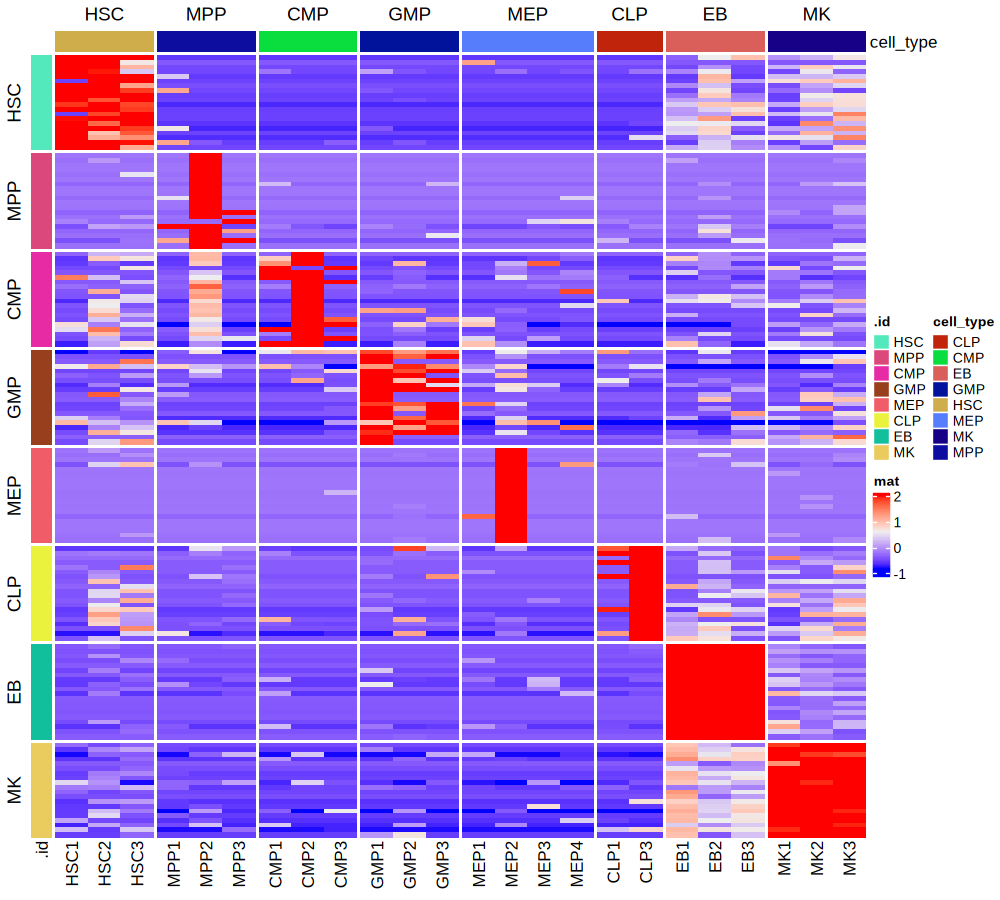

In [235]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_telocal_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
fwrite(row_sel, file = 'data/telocal_up20.xls', sep = '\t') 
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_telocal))
row_sel = row_sel[rn %in% ov, ]

telocal_list = c(telocal_list, list(up20 = row_sel))

plotdat = logcpm_telocal[row_sel$rn, rownames(dsn_telocal)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_telocal[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = factor(row_sel$.id, levels = cell_types), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


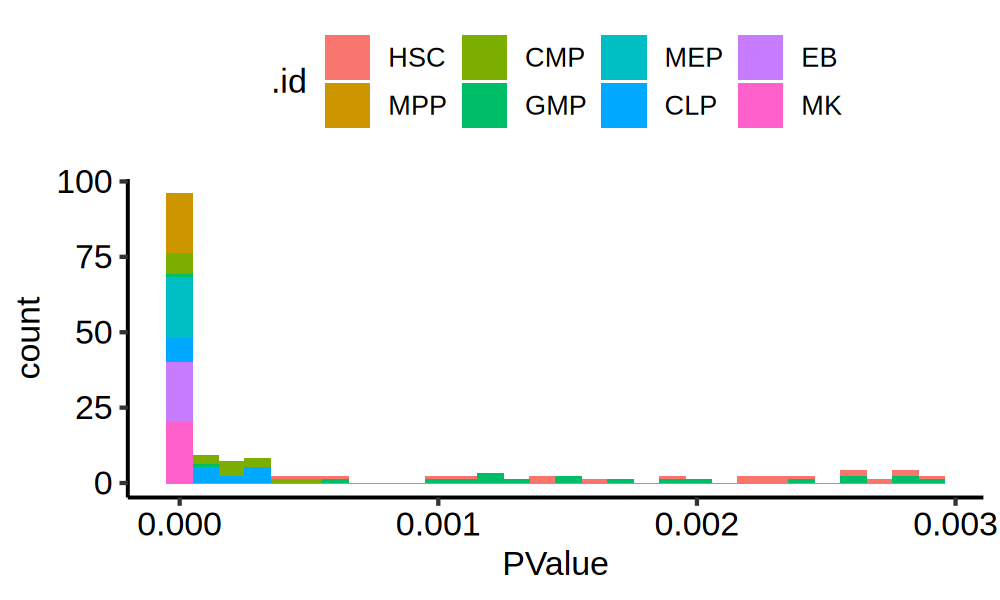

In [236]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = PValue, fill = .id)) + geom_histogram() + theme_pubr()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


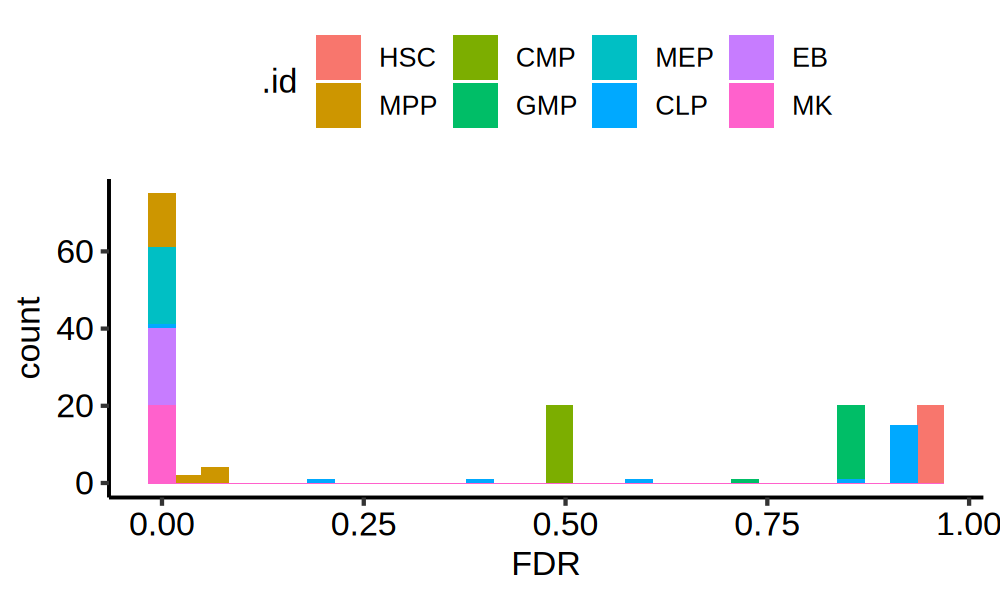

In [237]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = FDR, fill = .id)) + geom_histogram() + theme_pubr()


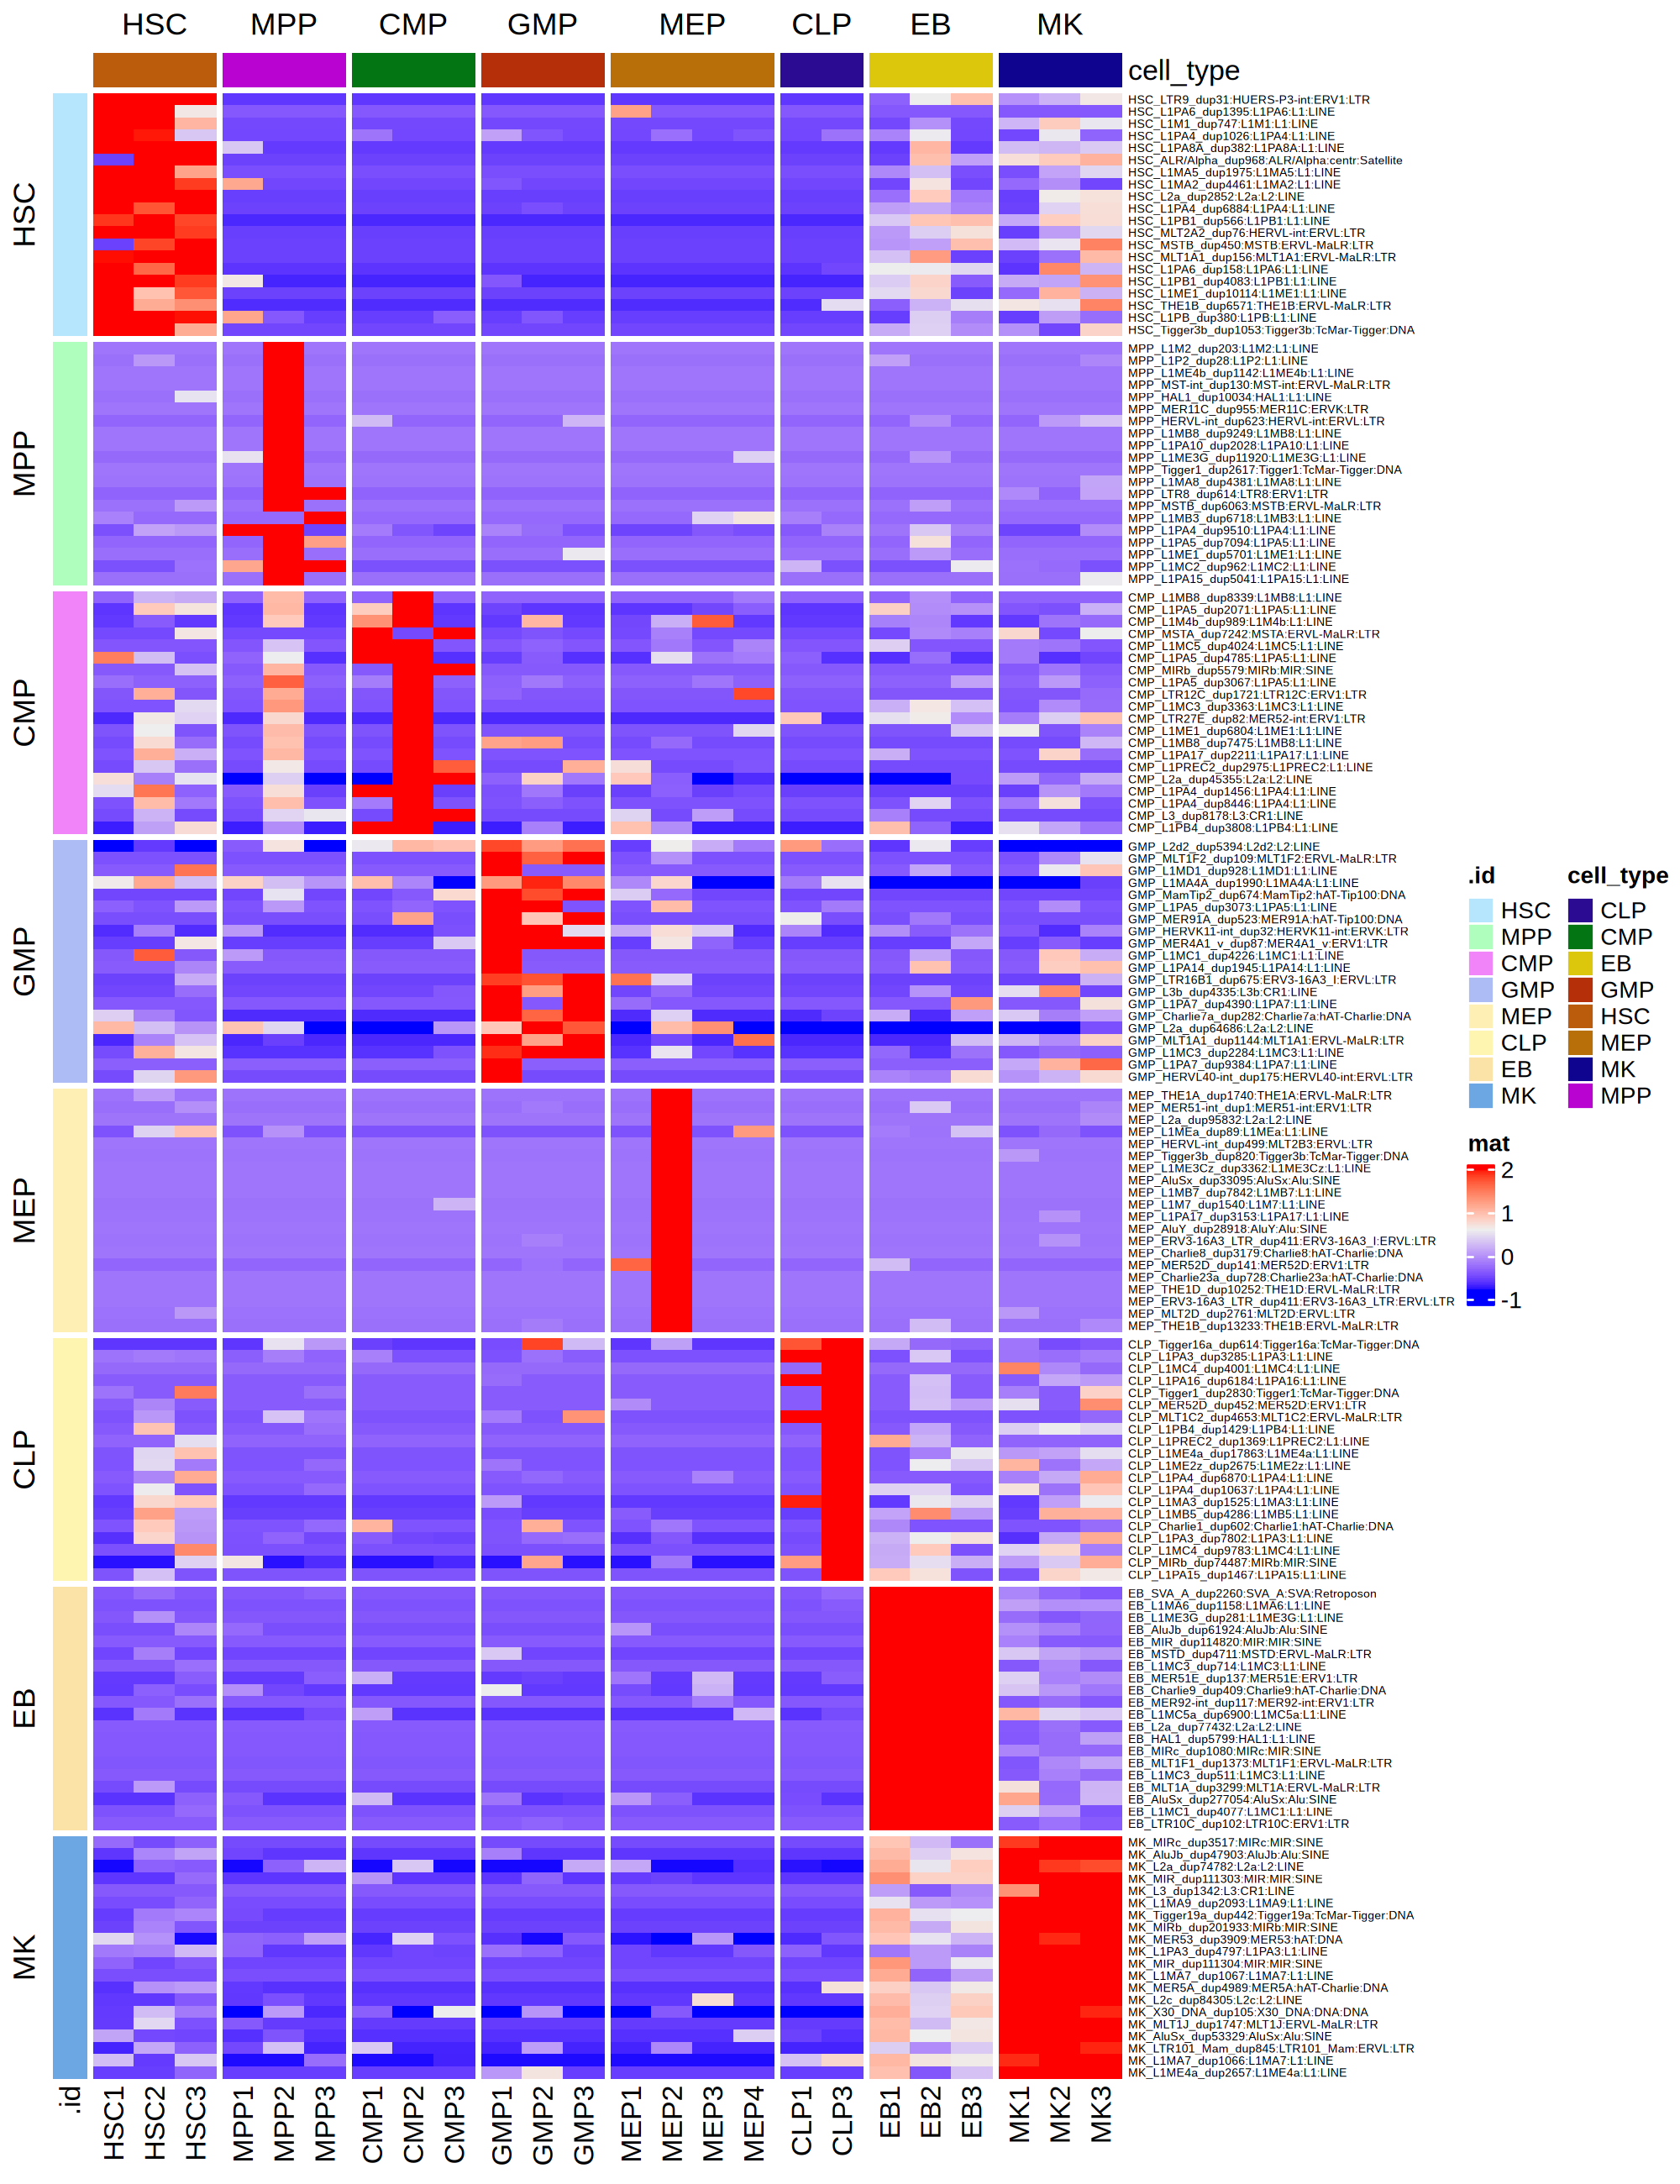

In [239]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 13, repr.plot.res = 200)

row_sel = deg_telocal_dt[logFC > 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_telocal))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_telocal[row_sel$rn, rownames(dsn_telocal)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = factor(row_sel$.id, levels = cell_types), 
        row_names_gp = grid::gpar(fontsize = 5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


In [724]:
plotdat[1:3, 1:10]

HSC1      HSC2      HSC3       MPP1       MPP2      MPP3       CMP1       CMP2        CMP3      GMP1      
HSC_HERV15-int_dup33:HERV15-int:ERV1:LTR -1.216618 -1.285242 -1.1534324 -0.2554381 0.1265225 -1.6238314  0.8332750  0.85097397 0.9198785  0.2000048
HSC_L1MD_dup1005:L1MD:L1:LINE            -1.260610 -1.156266 -1.2079864 -1.0375605 0.5899172 -0.9161918 -1.1750184  0.04120087 0.2262641 -1.0758196
HSC_AluJr_dup1452:AluJr:Alu:SINE         -2.000000 -0.834153 -0.9389894 -0.1175482 0.5844460 -0.4856305  0.6675626 -0.24131293 0.5566047 -0.3777248

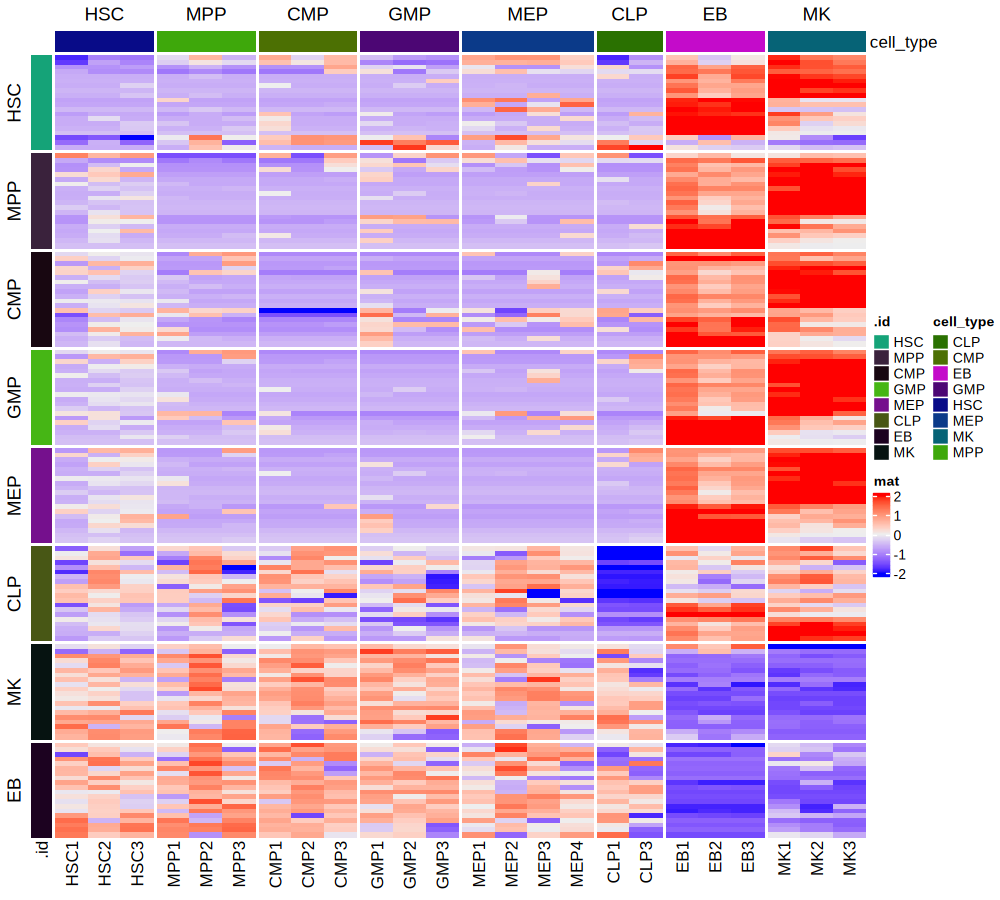

In [242]:
# top 20 dn-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)

row_sel = deg_telocal_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
fwrite(row_sel, file = 'data/telocal_down20.xls', sep = '\t') 
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_telocal))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_telocal[row_sel$rn, rownames(dsn_telocal)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_telocal[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = F, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = T,  row_split = factor(row_sel$.id, levels = cell_types), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


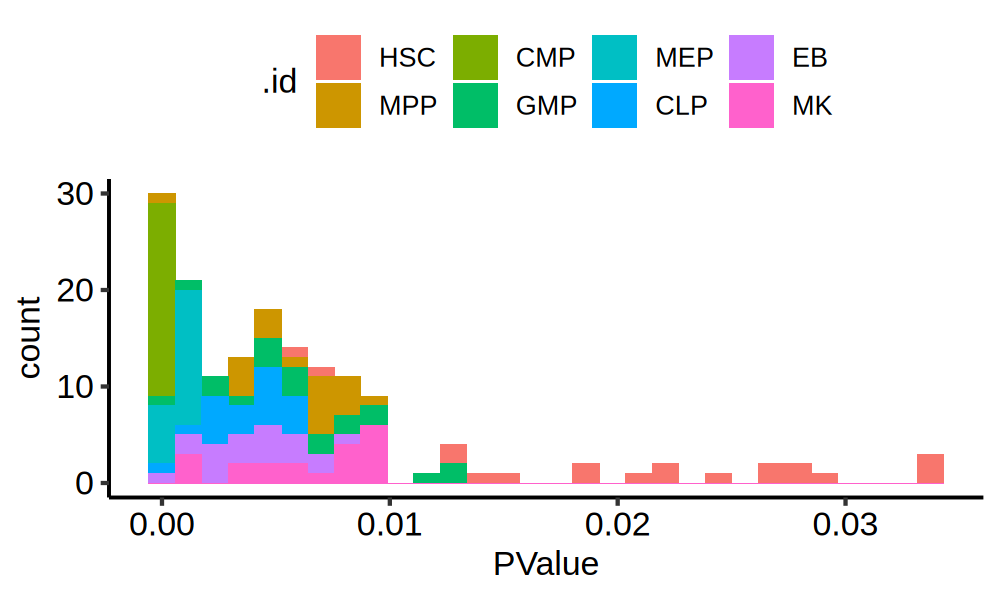

In [917]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = PValue, fill = .id)) + geom_histogram() + theme_pubr()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


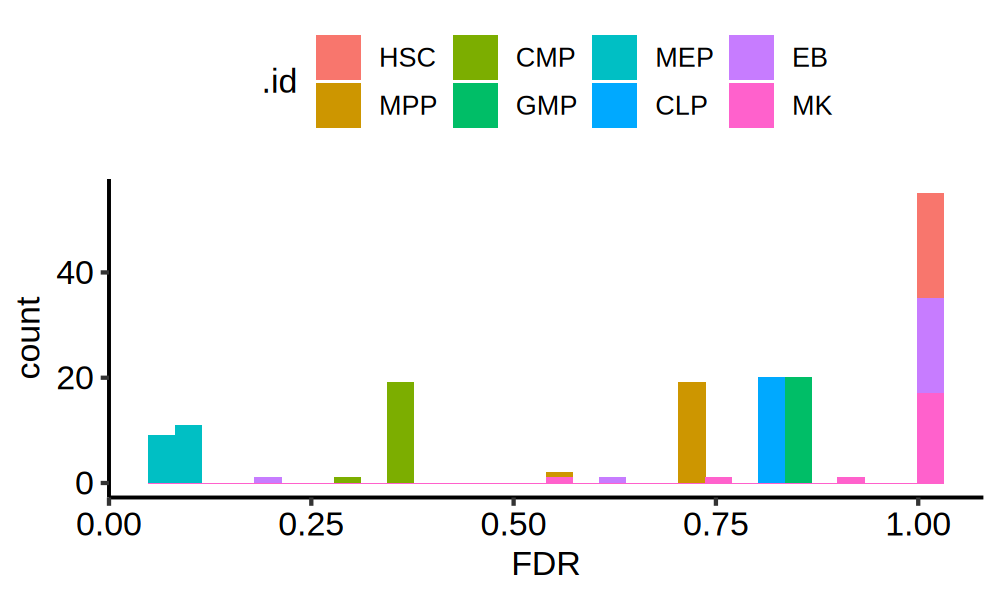

In [918]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(row_sel, aes(x = FDR, fill = .id)) + geom_histogram() + theme_pubr()


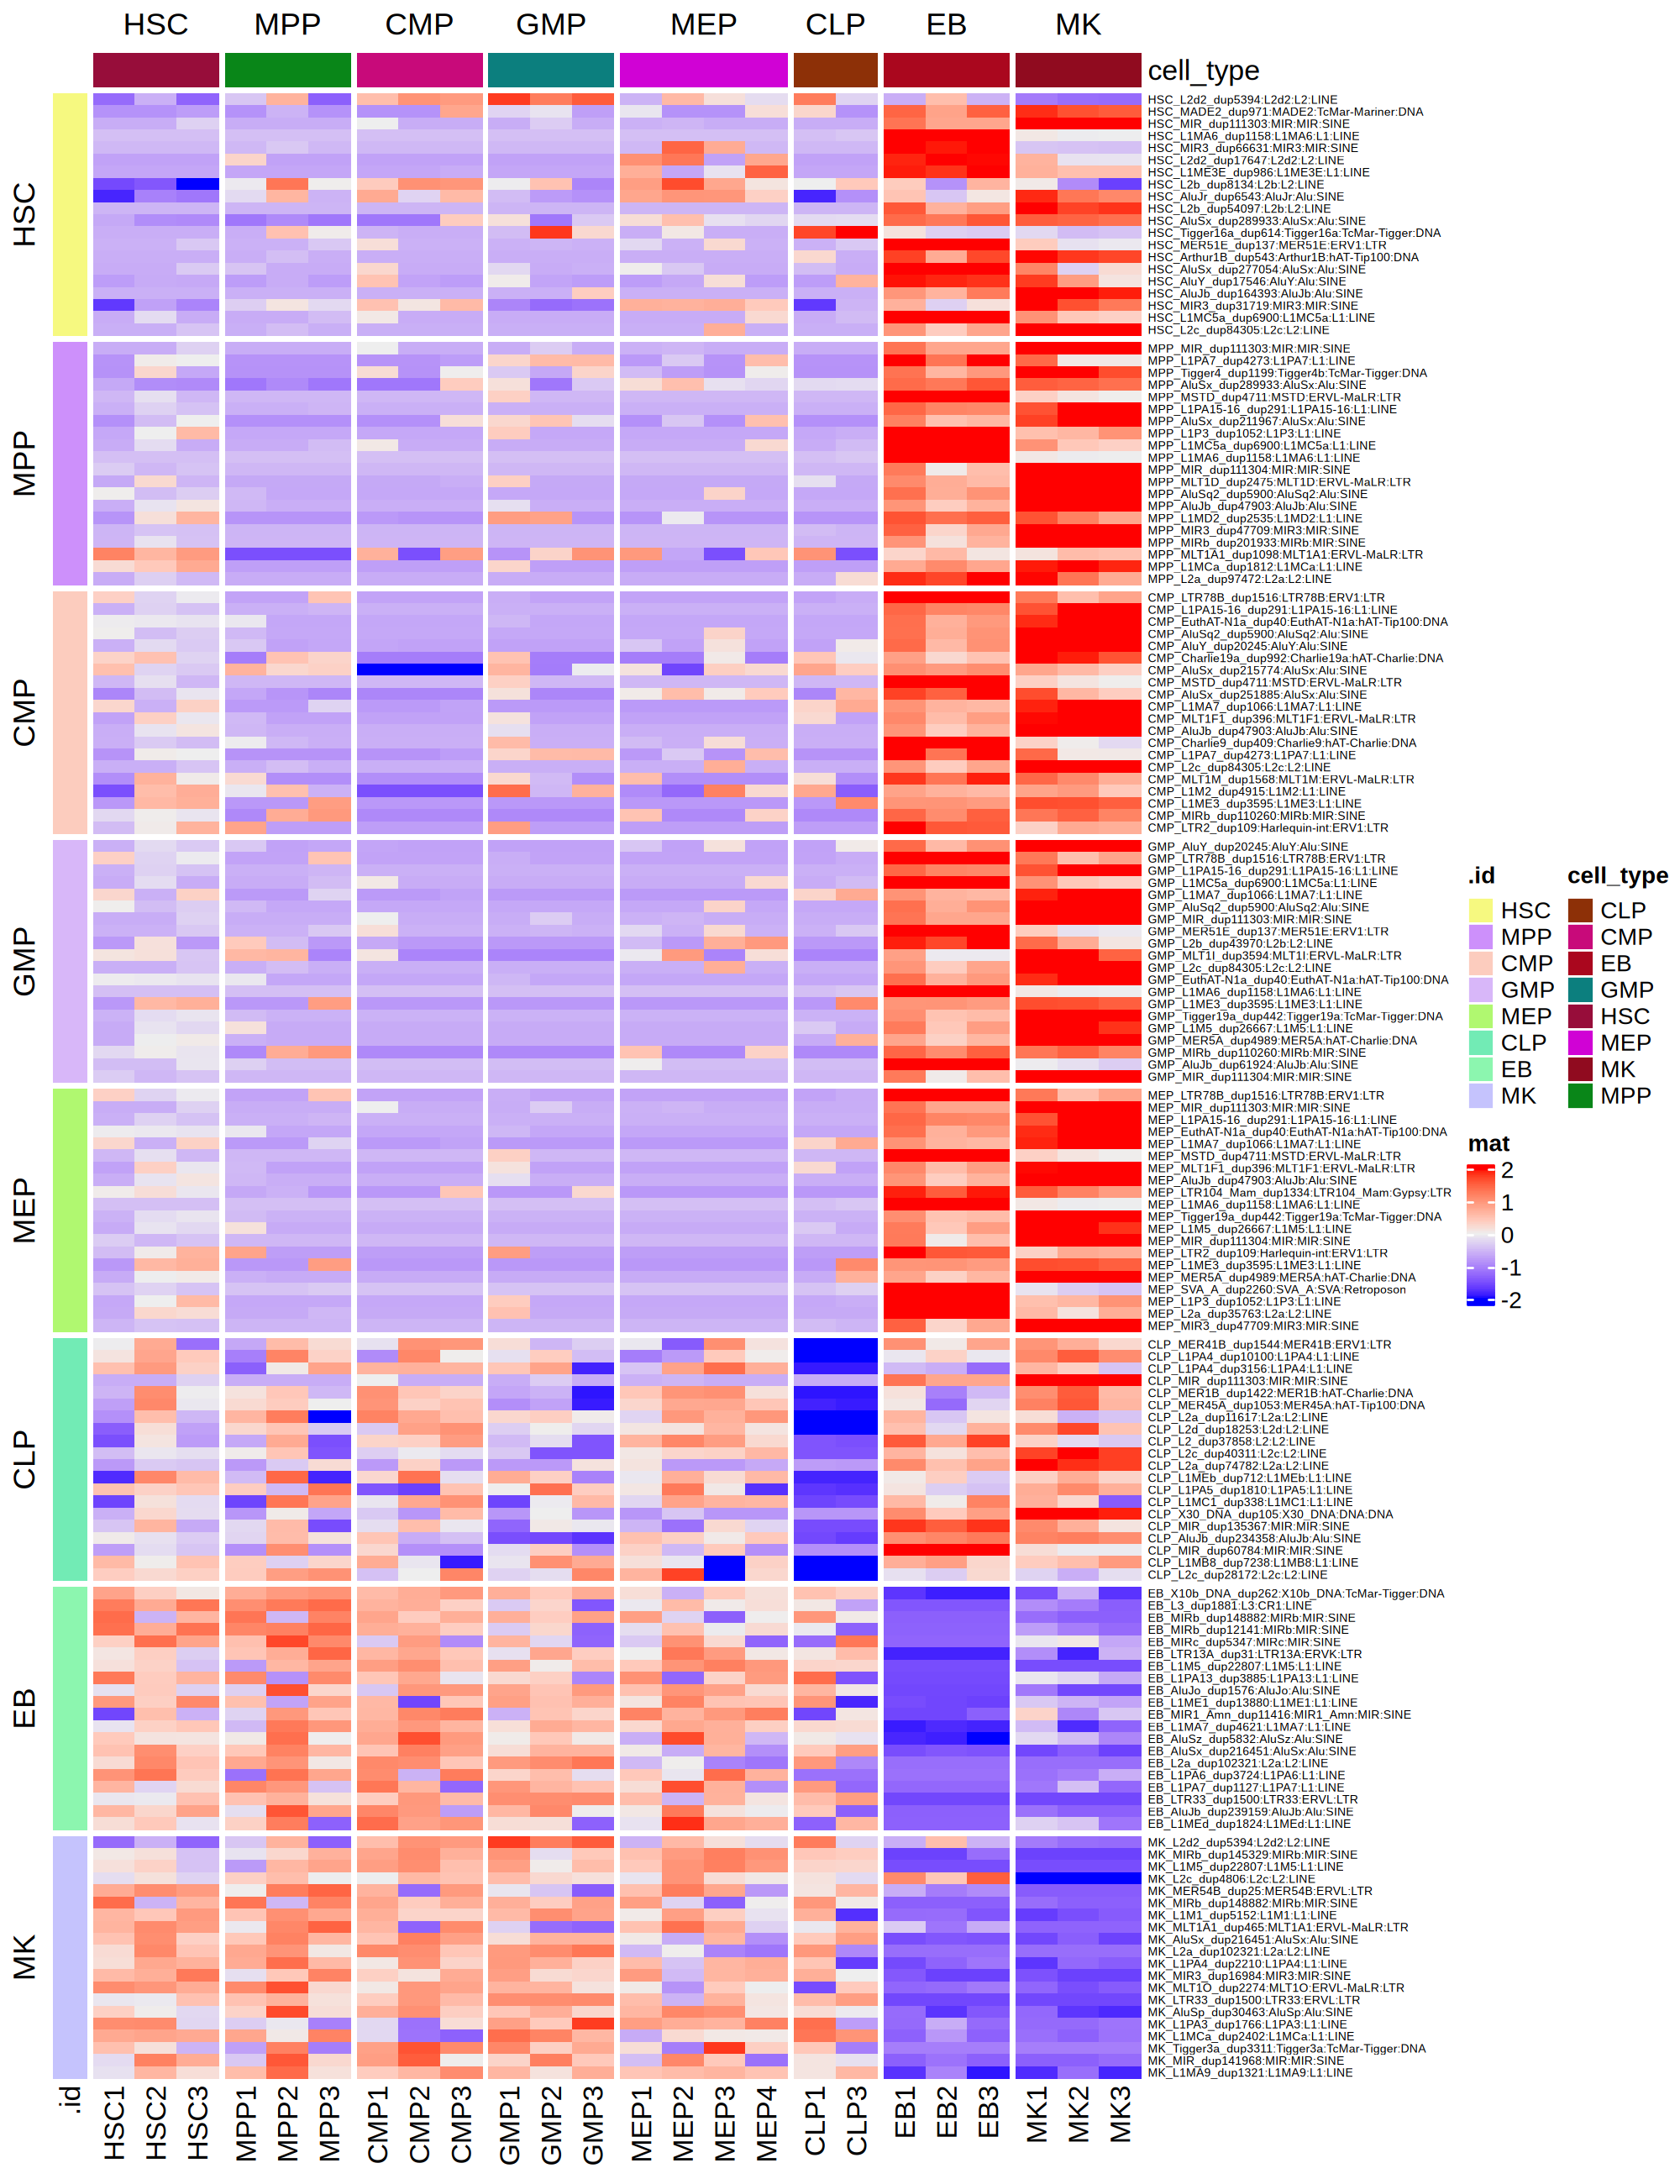

In [243]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 13, repr.plot.res = 200)

row_sel = deg_telocal_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_telocal))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_telocal[row_sel$rn, rownames(dsn_telocal)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, row_names_gp = grid::gpar(fontsize = 5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


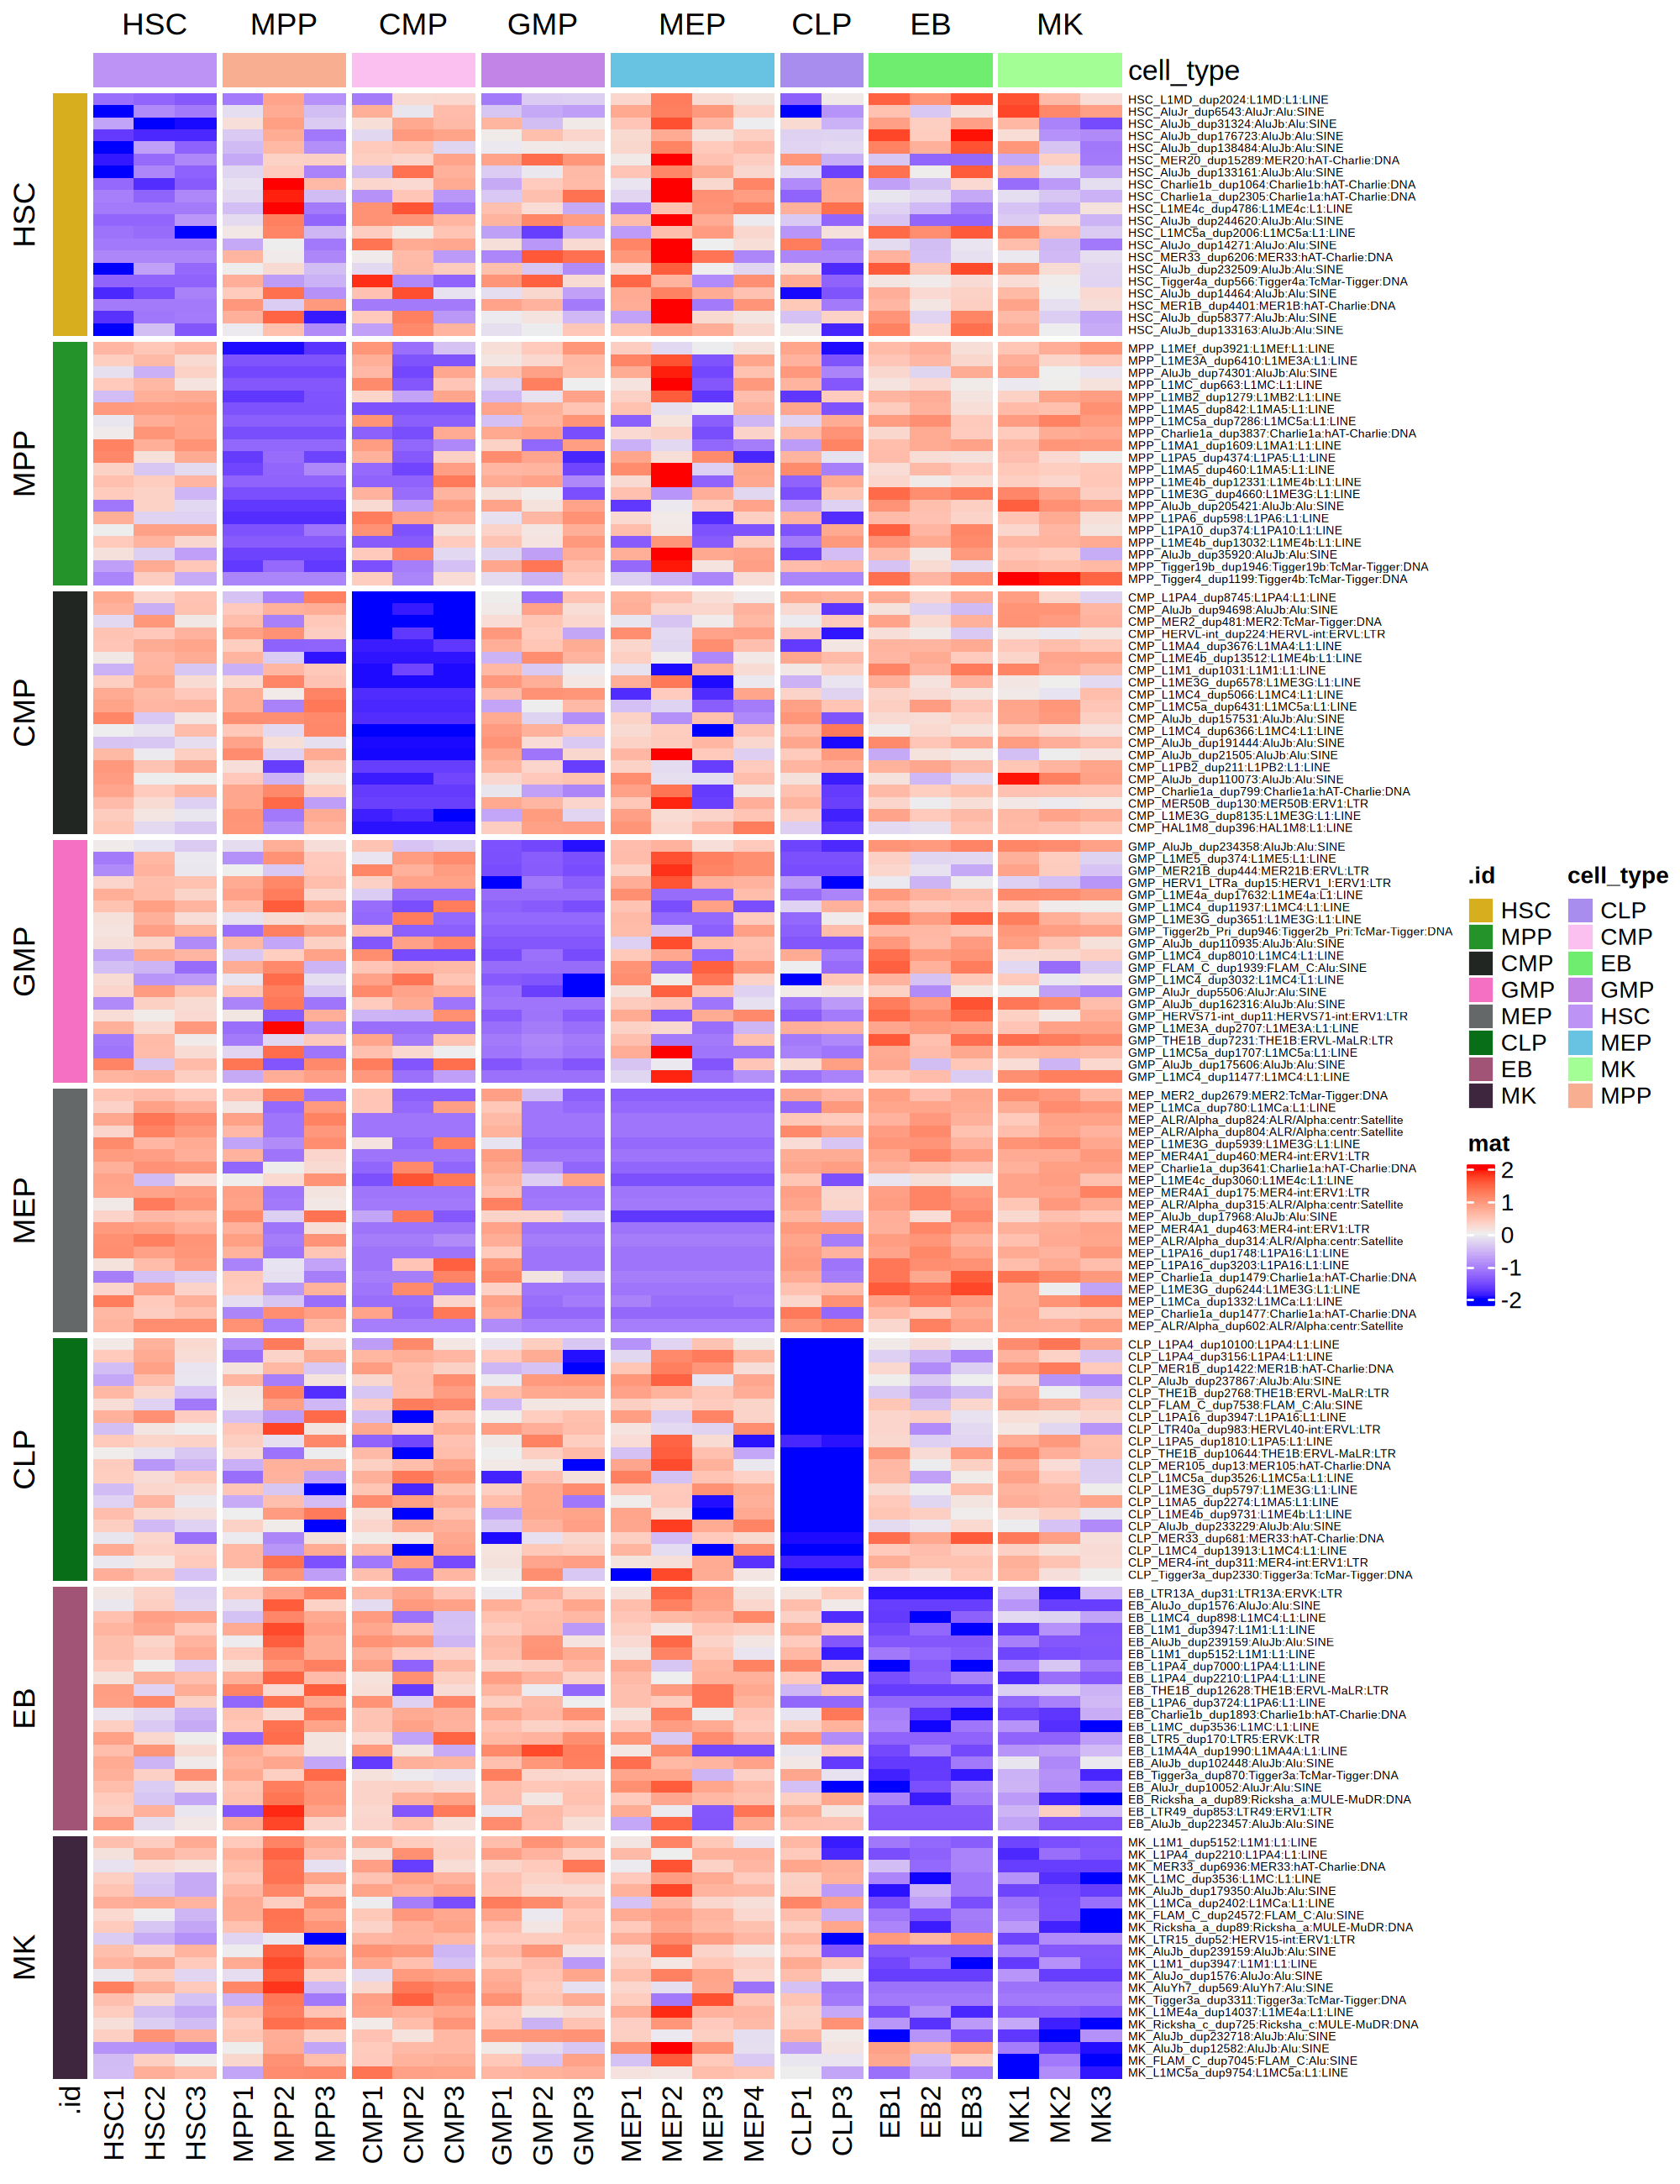

In [933]:
# top 20 up-regulated coding genes for each cell type
options(repr.plot.width = 10, repr.plot.height = 13, repr.plot.res = 200)

row_sel = deg_telocal_dt[logFC < 0, ] %>% group_by(.id) %>% slice_min(order_by = PValue, n = 20)
row_sel = as.data.table(row_sel)
row_sel[, ctype_gene := paste0(.id, '_', rn)]
row_sel[, .id := factor(.id, levels = cell_types)]
row_sel = row_sel[order(.id), ]
ov = intersect(row_sel$rn, rownames(logcpm_telocal))
row_sel = row_sel[rn %in% ov, ]

plotdat = logcpm_telocal[row_sel$rn, rownames(dsn_telocal)]
rownames(plotdat) = row_sel$ctype_gene

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_all_df[, 'cell_type', drop = F])
column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F,  row_split = row_sel$.id, row_names_gp = grid::gpar(fontsize = 5), 
        show_row_dend = F, top_annotation = column_ha, left_annotation = column_ra, 
        column_split = factor(dsn_all_df$cell_type, levels = cell_types))  


In [938]:
row_sel[1:5, ]

.id rn                             logFC     logCPM    PValue      FDR ctype_gene                        
1 HSC L1MD_dup2024:L1MD:L1:LINE      -5.351829 10.686590 0.006267821 1   HSC_L1MD_dup2024:L1MD:L1:LINE     
2 HSC AluJr_dup6543:AluJr:Alu:SINE   -6.687467  9.314801 0.007097942 1   HSC_AluJr_dup6543:AluJr:Alu:SINE  
3 HSC AluJb_dup31324:AluJb:Alu:SINE  -3.793383  9.220092 0.012262250 1   HSC_AluJb_dup31324:AluJb:Alu:SINE 
4 HSC AluJb_dup176723:AluJb:Alu:SINE -3.729088  7.535264 0.012912024 1   HSC_AluJb_dup176723:AluJb:Alu:SINE
5 HSC AluJb_dup138484:AluJb:Alu:SINE -3.995137  9.181538 0.014095934 1   HSC_AluJb_dup138484:AluJb:Alu:SINE

In [950]:
telocal_sel = rbindlist(telocal_list, idcol = T)
setnames(telocal_sel, 1, 'sig_type')
setnames(telocal_sel, 2, 'cell_type')
telocal_sel[, cell_type_agg := paste(.SD$cell_type, collapse = ' '), by = 'rn']
telocal_sel = telocal_sel[!duplicated(rn), ]
head(telocal_sel)
#telocal_sel = merge(telocal_sel, te_dt, by.x = 'rn', by.y = 'idd', all.x = T)
#fwrite(telocal_sel, file = 'data/telocal_selected.tsv')


sig_type cell_type rn                             logFC    logCPM   PValue       FDR         ctype_gene                        
1 sig      MPP       L1MC2_dup962:L1MC2:L1:LINE     7.900020 4.429032 3.774423e-07 0.016061678 MPP_L1MC2_dup962:L1MC2:L1:LINE    
2 sig      MEP       L1ME4a_dup16825:L1ME4a:L1:LINE 7.861616 5.392640 1.339613e-07 0.005659330 MEP_L1ME4a_dup16825:L1ME4a:L1:LINE
3 sig      MEP       L1PA2_dup4023:L1PA2:L1:LINE    4.617730 5.310166 4.218421e-07 0.007151983 MEP_L1PA2_dup4023:L1PA2:L1:LINE   
4 sig      MEP       L1MCa_dup1389:L1MCa:L1:LINE    7.047260 5.983230 6.448921e-07 0.007151983 MEP_L1MCa_dup1389:L1MCa:L1:LINE   
5 sig      MEP       L1MC4_dup1643:L1MC4:L1:LINE    5.465708 5.942621 8.258426e-07 0.007151983 MEP_L1MC4_dup1643:L1MC4:L1:LINE   
6 sig      MEP       AluJb_dup148154:AluJb:Alu:SINE 6.125822 3.938554 8.464687e-07 0.007151983 MEP_AluJb_dup148154:AluJb:Alu:SINE
  cell_type_agg                                          
1 MPP MPP MPP MPP MPP MPP MPP MPP MPP MPP MPP MPP MPP MPP
2 MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP
3 MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP
4 MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP
5 MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP
6 MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP MEP

In [951]:
head(te_dt)


chr  rmsk      exon start end  width strand score gene_id  transcript_id   family_id class_id  idd                               
1 chr1 UCSC_rmsk exon 2710  4402 5119  -      .     TAR1     TAR1_dup164     subtelo   Satellite TAR1_dup164:TAR1:subtelo:Satellite
2 chr1 UCSC_rmsk exon 4083  4533  962  -      .     LTR60B   LTR60B_dup190   ERV1      LTR       LTR60B_dup190:LTR60B:ERV1:LTR     
3 chr1 UCSC_rmsk exon 4534  4660  505  -      .     LTR60B   LTR60B_dup191   ERV1      LTR       LTR60B_dup191:LTR60B:ERV1:LTR     
4 chr1 UCSC_rmsk exon 4664  5263 1304  +      .     L1MC3    L1MC3_dup5932   L1        LINE      L1MC3_dup5932:L1MC3:L1:LINE       
5 chr1 UCSC_rmsk exon 5275  5528 1403  +      .     MER34C_v MER34C_v_dup375 ERV1      LTR       MER34C_v_dup375:MER34C_v:ERV1:LTR 
6 chr1 UCSC_rmsk exon 5529  5686 3544  +      .     L1MC3    L1MC3_dup5932   L1        LINE      L1MC3_dup5932:L1MC3:L1:LINE

In [944]:
head(telocal_sel)
dim(telocal_sel)


sig_type cell_type rn                                  logFC     logCPM   PValue       FDR          ctype_gene                             cell_type_agg
1 sig      MPP       L1PA4_dup5118:L1PA4:L1:LINE          6.692403 4.420084 1.933025e-08 1.031752e-03 MPP_L1PA4_dup5118:L1PA4:L1:LINE        MPP MPP      
2 sig      CMP       L1PA4_dup5560:L1PA4:L1:LINE          6.081185 3.666404 1.987178e-06 8.822843e-02 CMP_L1PA4_dup5560:L1PA4:L1:LINE        CMP CMP      
3 sig      CMP       L1ME3C_dup2379:L1ME3C:L1:LINE       -9.688420 7.010773 3.305983e-06 8.822843e-02 CMP_L1ME3C_dup2379:L1ME3C:L1:LINE      CMP CMP      
4 sig      MEP       L1ME4a_dup18726:L1ME4a:L1:LINE       8.333388 4.451539 6.617833e-07 3.499245e-02 MEP_L1ME4a_dup18726:L1ME4a:L1:LINE     MEP MEP      
5 sig      EB        MER31-int_dup383:MER31-int:ERV1:LTR 12.868093 7.513748 2.124311e-25 1.133851e-20 EB_MER31-int_dup383:MER31-int:ERV1:LTR EB EB        
6 sig      EB        L1ME3G_dup21477:L1ME3G:L1:LINE      11.934552 6.906337 7.708321e-20 2.057158e-15 EB_L1ME3G_dup21477:L1ME3G:L1:LINE      EB EB

[1] 326   9

In [952]:
telocal_sel_seqino = merge(telocal_sel, te_dt, by.x = 'rn', by.y = 'idd', all.x = T)
fwrite(telocal_sel_seqino, file = 'data/telocal_sel.xls', sep = '\t')


# annotate TE

In [961]:
tmp = data.frame(seqname = telocal_sel_seqino$chr, start = telocal_sel_seqino$start, end = telocal_sel_seqino$end, name = telocal_sel_seqino$ctype_gene)
gr = GRanges(tmp)
gr_anno = annotatePeak(gr, TxDb=txdb, tssRegion=c(-3000, 3000), verbose=FALSE, annoDb = 'org.Hs.eg.db', addFlankGeneInfo = T)
telocal_anno_dt = as.data.table(gr_anno@anno, keep.rownames = T)
head(telocal_anno_dt)


'select()' returned 1:many mapping between keys and columns

Warning message in .local(x, row.names, optional, ...):
"Arguments in '...' ignored"


rn seqnames start    end      width strand name                                            annotation                                              geneChr geneStart ⋯ geneStrand
1 1  chr5     46458186 46475286 17101 *      MEP_ALR/Alpha_dup1008:ALR/Alpha:centr:Satellite Distal Intergenic                                        5      45641701  ⋯ 2         
2 2  chr4     66765072 66770291  5220 *      MEP_ALR/Alpha_dup1067:ALR/Alpha:centr:Satellite Distal Intergenic                                        4      66276824  ⋯ 1         
3 3  chr3     96449052 96457667  8616 *      MPP_ALR/Alpha_dup1099:ALR/Alpha:centr:Satellite Distal Intergenic                                        3      96359964  ⋯ 1         
4 4  chrY     18578339 18579537  1199 *      MEP_ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite Exon (ENST00000446387.1/ENST00000446387.1, exon 1 of 1) 24      18581206  ⋯ 2         
5 5  chrY     18579847 18591064 11218 *      MEP_ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite Promoter (<=1kb)                                        24      18581206  ⋯ 2         
6 6  chr19    30141348 30152530 11183 *      MEP_ALR/Alpha_dup269:ALR/Alpha:centr:Satellite  Distal Intergenic                                       19      30078133  ⋯ 1         
  geneId    transcriptId      distanceToTSS ENSEMBL         SYMBOL       GENENAME                                                               
1 348980    ENST00000634658.1 -761688       ENSG00000164588 HCN1         hyperpolarization activated cyclic nucleotide gated potassium channel 1
2 100302177 ENST00000408636.1  488248       ENSG00000221563 MIR1269A     microRNA 1269a                                                         
3 102465864 ENST00000615894.1   89088       ENSG00000278103 MIR8060      microRNA 8060                                                          
4 425057    ENST00000545582.2    9175       ENSG00000131007 TTTY9B       testis expressed transcript, Y-linked 9B                               
5 425057    ENST00000545582.2       0       ENSG00000131007 TTTY9B       testis expressed transcript, Y-linked 9B                               
6 107985271 ENST00000660929.1   63215       NA              LOC107985271 uncharacterized LOC107985271                                           
  flank_txIds                                                                               flank_geneIds                    flank_gene_distances
1 NA                                                                                        NA                               NA                  
2 NA                                                                                        NA                               NA                  
3 NA                                                                                        NA                               NA                  
4 ENST00000545582.2;ENST00000433794.5;ENST00000447585.2;ENST00000309834.8;ENST00000338876.8 425057;425057;425057;86614;86614 0;0;0;0;0           
5 ENST00000545582.2;ENST00000433794.5;ENST00000447585.2;ENST00000309834.8;ENST00000338876.8 425057;425057;425057;86614;86614 0;0;0;0;0           
6 NA                                                                                        NA                               NA

In [991]:
tmp = fread('/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf')
setnames(tmp, c('chr', 'rmsk', 'exon', 'start', 'end', 'width', 'strand', 'score', 'info'))
tmp[, gene_id       := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\1', info)]
tmp[, transcript_id := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\2', info)]
tmp[, family_id     := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\3', info)]
tmp[, class_id      := sub('gene_id "(.*)"; transcript_id "(.*)"; family_id "(.*)"; class_id "(.*)";', '\\4', info)]
tmp[, idd := paste0(transcript_id, ':', gene_id, ':', family_id, ':', class_id)]
tmp[, idd_2 := paste0(chr, '_', start, '_', end, '__', transcript_id, ':', gene_id, ':', family_id, ':', class_id)]
tmp[, pos := paste0(chr, '_', start, '_', end)] 
tmp[, pos_agg := paste(pos, collapse = '__'), by = idd]
tmp = tmp[!duplicated(idd), ]


In [983]:
telocal_sel_seqino[ctype_gene == 'MEP_ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite', ]

rn                                          sig_type cell_type logFC     logCPM   PValue      FDR       ctype_gene                                      cell_type_agg   chr  ⋯ exon
1 ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite sig      MEP       -9.326049 5.108598 0.008103747 0.2092134 MEP_ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite MEP MEP MEP MEP chrY ⋯ exon
2 ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite sig      MEP       -9.326049 5.108598 0.008103747 0.2092134 MEP_ALR/Alpha_dup1166:ALR/Alpha:centr:Satellite MEP MEP MEP MEP chrY ⋯ exon
  start    end      width strand score gene_id   transcript_id     family_id class_id 
1 18578339 18579537 1041  -      .     ALR/Alpha ALR/Alpha_dup1166 centr     Satellite
2 18579847 18591064 1147  -      .     ALR/Alpha ALR/Alpha_dup1166 centr     Satellite

In [999]:
telocal_sel_seqino_ann = merge(telocal_sel_seqino[!duplicated(ctype_gene), ], telocal_anno_dt, by.x = 'ctype_gene', by.y = 'name', all.x = T)

In [997]:
dim(telocal_sel_seqino_ann)

[1] 7371   42

In [958]:
gr_anno

Annotated peaks generated by ChIPseeker
7371/7371  peaks were annotated
Genomic Annotation Summary:
              Feature   Frequency
9    Promoter (<=1kb)  7.90937458
10   Promoter (1-2kb)  4.96540497
11   Promoter (2-3kb)  4.05643739
4              5' UTR  0.33916701
3              3' UTR  2.36060236
1            1st Exon  0.96323430
7          Other Exon  2.87613621
2          1st Intron 14.44851445
8        Other Intron 29.16836250
6  Downstream (<=300)  0.05426672
5   Distal Intergenic 32.85849953

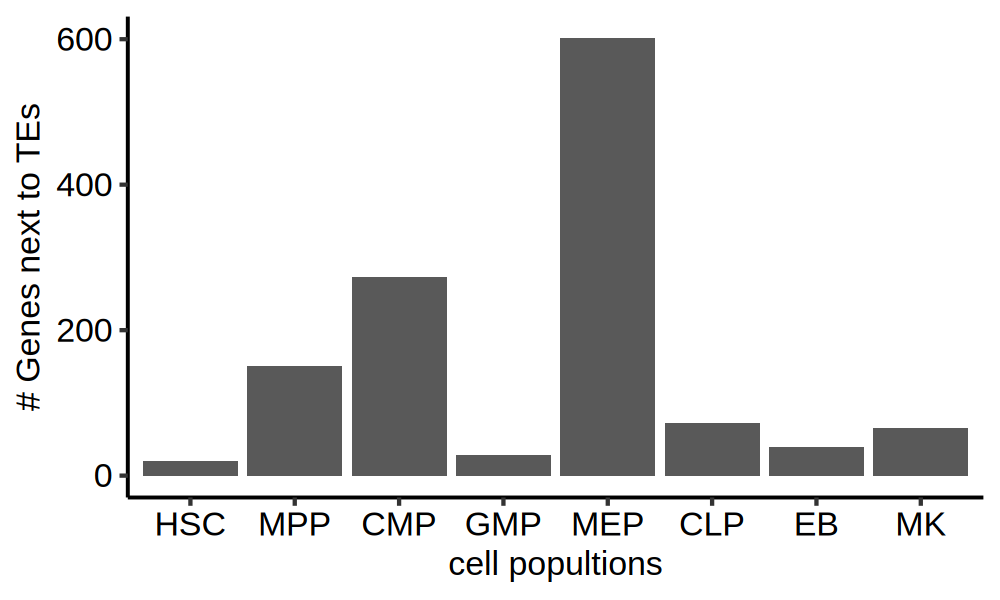

In [1014]:
tmp = as.data.frame.matrix(table(telocal_sel_seqino_ann[!is.na(SYMBOL) & abs(distanceToTSS) < 3000, SYMBOL],  telocal_sel_seqino_ann[!is.na(SYMBOL) & abs(distanceToTSS) < 3000, cell_type]) )
tmp2 = as.data.table(apply(tmp, 2, sum), keep.rownames = T)
setnames(tmp2, c('cell_type', 'ene_num'))
tmp2[, cell_type := factor(cell_type, levels = c(cell_types))] 
ggplot(tmp2, aes(cell_type, ene_num)) + geom_bar(stat = 'identity') + theme_pubr() + xlab('cell popultions') + ylab('# Genes next to TEs')


In [1026]:
gs = telocal_sel_seqino_ann[!is.na(SYMBOL) & abs(distanceToTSS) < 3000 & cell_type == 'CMP', SYMBOL]
yy = enrichGO(gs, OrgDb = org.Hs.eg.db, keyType = 'SYMBOL', ont="BP", pvalueCutoff=0.01)


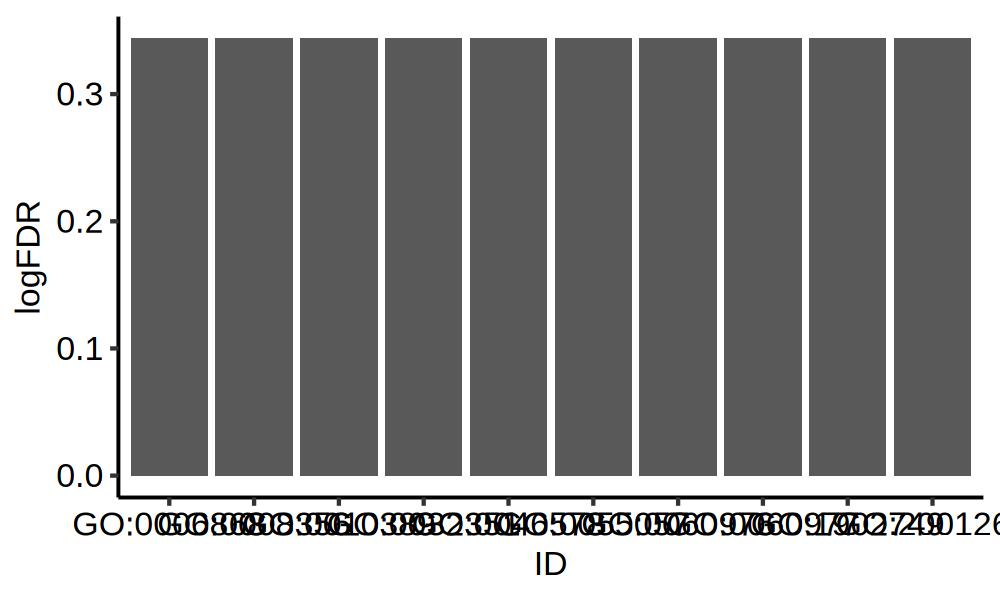

In [1052]:
yy_res = as.data.table(yy@result)
yy_res[, logFDR := -log(p.adjust, 10)] 
ggplot(yy_res[1:10, ], aes(ID, logFDR)) + geom_bar(stat = 'identity') + theme_pubr()

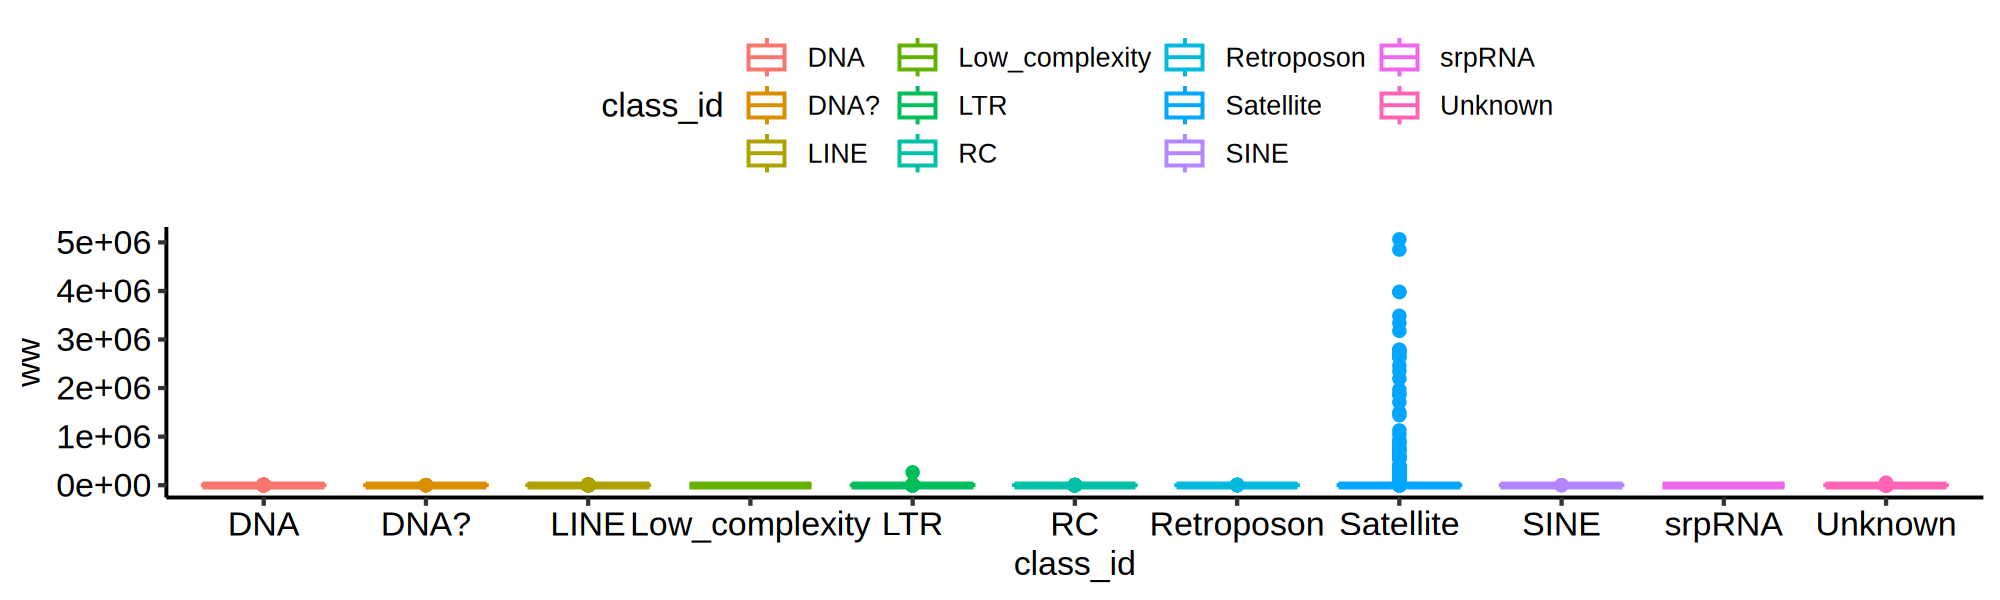

In [1064]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
te_dt[, ww := end - start]
ggplot(te_dt, aes(class_id, ww, color = class_id)) + geom_boxplot() + theme_pubr()


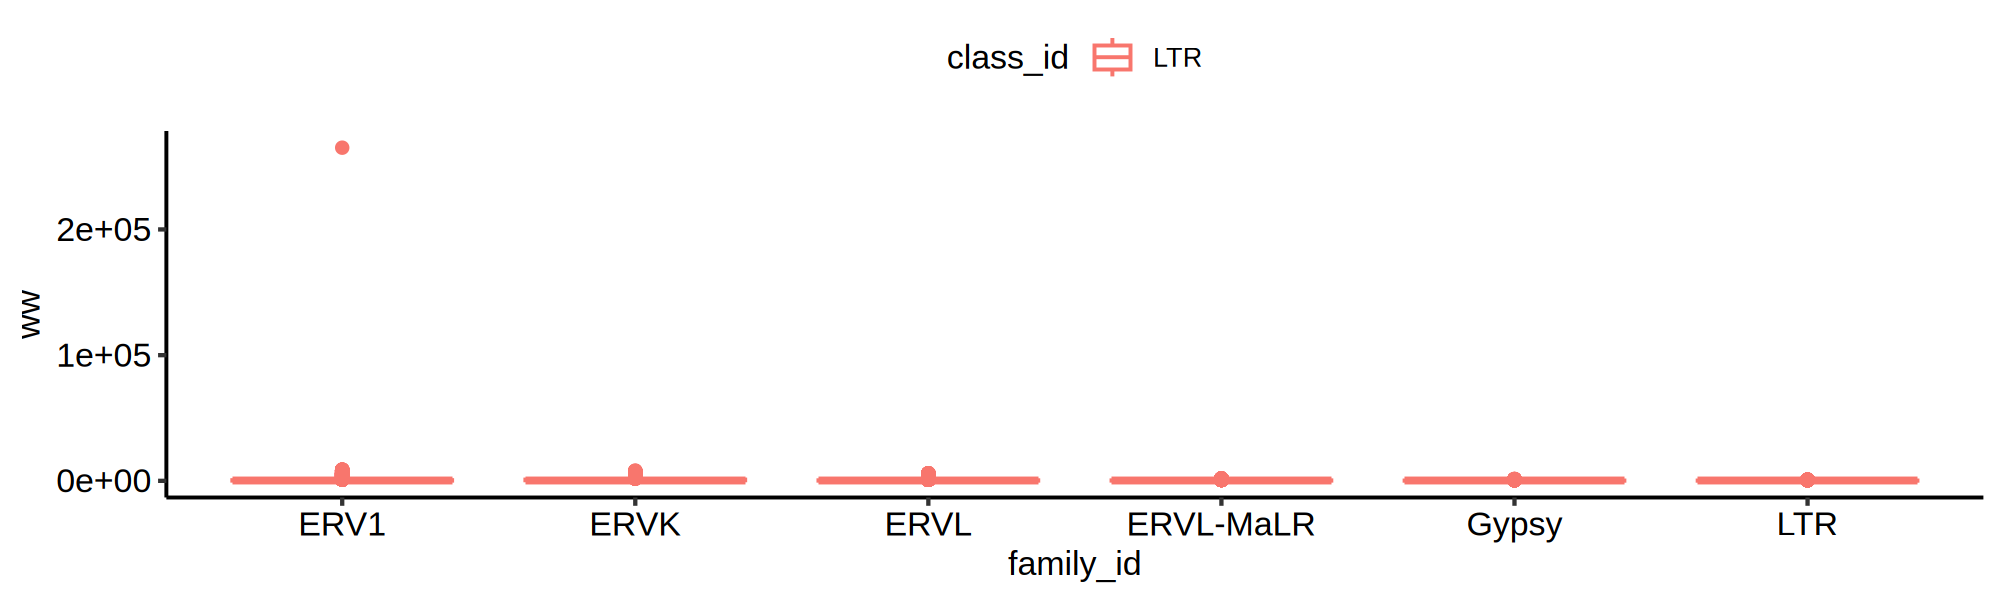

In [1067]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
ggplot(te_dt[class_id == 'LTR'], aes(family_id, ww, color = class_id)) + geom_boxplot() + theme_pubr()


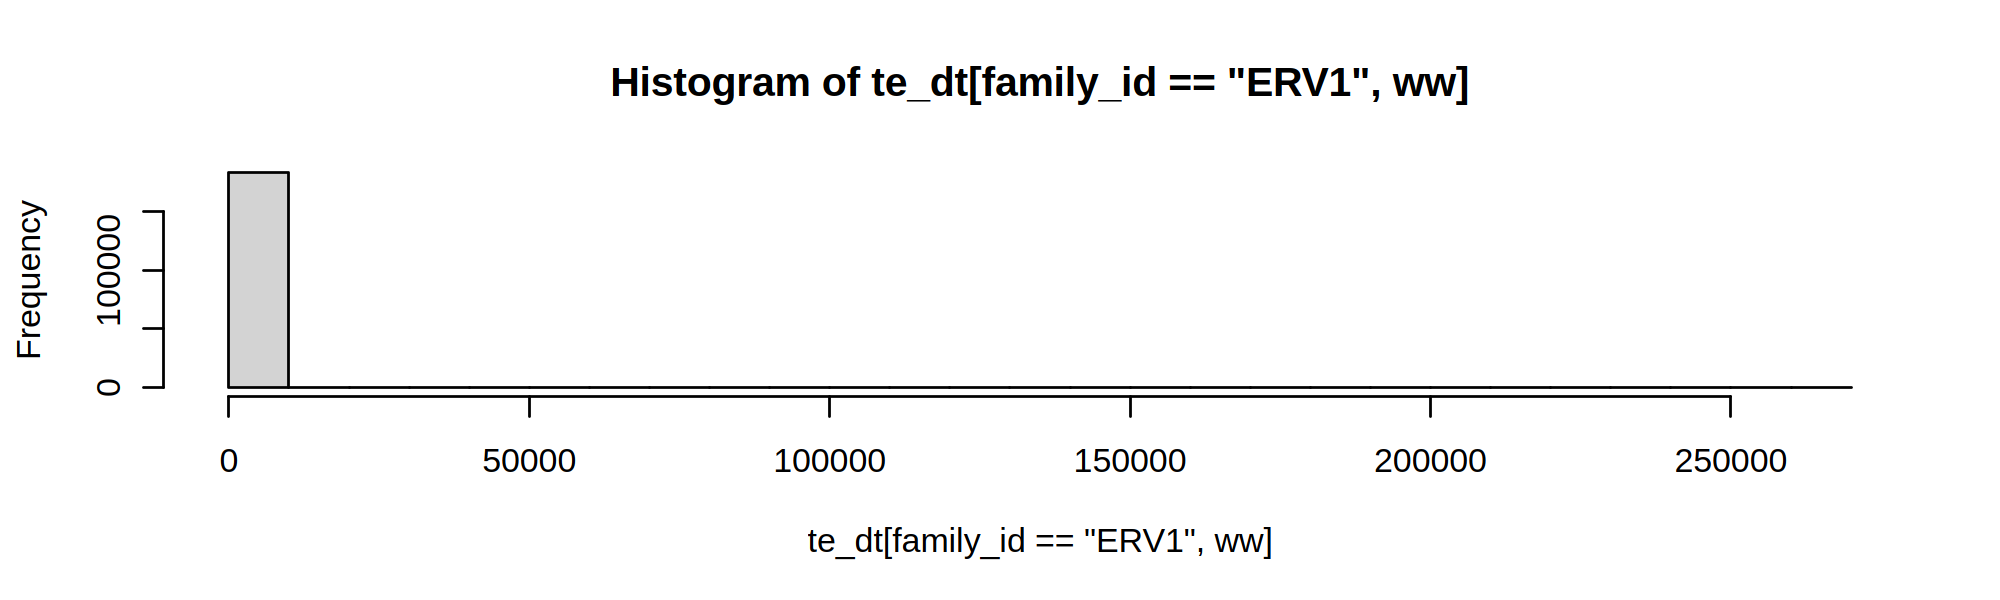

In [1075]:
hist(te_dt[family_id == 'ERV1', ww])

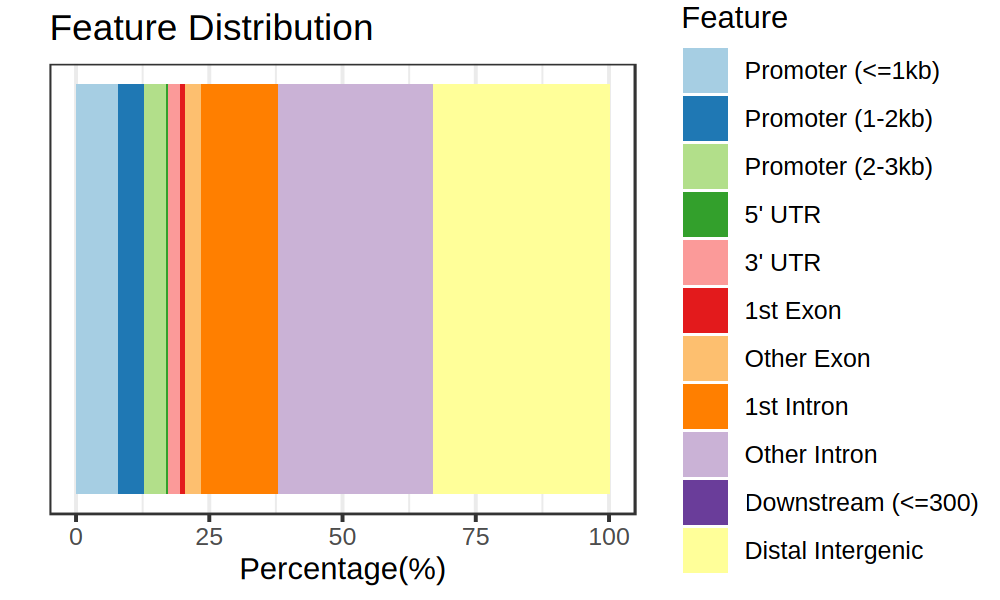

In [966]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
plotAnnoBar(gr_anno)

# TE tree plot

In [ ]:
te_sel = c('HERV9', 'LTR12')
te_sel_list = lapply(te_sel, function(ii){te_dt[grep(ii, gene_id), ]})
te_sel_dt = rbindlist(te_sel_list)
te_sel_dt = te_sel_dt[!duplicated(gene_id), ]
te_sel_dt


# plot along the chromosome

In [925]:
library(OmicCircos)

In [ ]:
data ("UCSC.mm10.chr" , package="OmicCircos") ;
UCSC.mm10.chr

In [932]:
chrom_size_file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/t2t_sizes_genome'
chrom_size = fread(chrom_size_file)
chrom_size = chrom_size[chrom != 'chrM', ]
setnames(chrom_size, c('chrom', 'chrom_len'))
chrom_size[, start := cumsum(c(1, chrom_size$chrom_len[1:(nrow(chrom_size) - 1)]))] 
chrom_size[, end := cumsum( chrom_len )]
chrom_size


Warning message in eval(jsub, SDenv, parent.frame()):
"integer overflow in 'cumsum'; use 'cumsum(as.numeric(.))'"


chrom chrom_len start      end       
1  chr1  248387328          1  248387328
2  chr2  242696752  248387329  491084080
3  chr3  201105948  491084081  692190028
4  chr4  193574945  692190029  885764973
5  chr5  182045439  885764974 1067810412
6  chr6  172126628 1067810413 1239937040
7  chr7  160567428 1239937041 1400504468
8  chrX  154259566 1400504469 1554764034
9  chr9  150617247 1554764035 1705381281
10 chr8  146259331 1705381282 1851640612
11 chr11 135127769 1851640613 1986768381
12 chr10 134758134 1986768382 2121526515
13 chr12 133324548 2121526516         NA
14 chr13 113566686 2254851064         NA
15 chr14 101161492 2368417750         NA
16 chr15  99753195 2469579242         NA
17 chr16  96330374 2569332437         NA
18 chr17  84276897 2665662811         NA
19 chr18  80542538 2749939708         NA
20 chr20  66210255 2830482246         NA
21 chrY   62460029 2896692501         NA
22 chr19  61707364 2959152530         NA
23 chr22  51324926 3020859894         NA
24 chr21  45090682 3072184820         NA
25 chrM      16569 3117275502         NA

# backup code 

In [ ]:
mm = rep(-1, length(cell_types))
deg_list = lapply(1:length(mm), function(ii){
    mm_ii = mm
    mm_ii[ii] = 1
    deg = glmQLFTest(fit, contrast = mm_ii) 
    deg = topTags(deg, n = nrow(fit$counts))
    as.data.table(deg$table, keep.rownames = T)

})


In [ ]:
names(deg_list) = cell_types
deg_dt = rbindlist(deg_list, idcol = T)
head(deg_dt)


In [304]:
deg = as.data.table(deg$table, keep.rownames = T)


In [281]:
cell_type_deg_list = lapply(cell_types, function(cc) {
    dsn_all_df$ctype = 'Other'
    dsn_all_df$ctype[dsn_all_df$cell_type == cc] = cc
    dsn_all_df$ctype = factor(dsn_all_df$ctype, levels = c('Other', cc))

    subtype = factor(dsn_all_df$ctype)
    subtype = relevel(subtype, ref = 'Other')

    dge = DGEList(counts=mtx_all_df, group = subtype)
    dge <- calcNormFactors(dge)

    keep = filterByExpr(dge)
    dge = dge[keep, , keep.lib.sizes=FALSE]
    dge = normLibSizes(dge)
    design = model.matrix( ~ 0 + subtype)
    dge = estimateDisp(dge, design)
    et <- exactTest(dge)
    deg = topTags(et, n = length(keep))
    as.data.table(deg$table, keep.rownames = T)
})


In [282]:
names(cell_type_deg_list) = cell_types
cell_type_deg_dt = rbindlist(cell_type_deg_list, idcol = T)
head(cell_type_deg_dt)


.id rn        logFC      logCPM   PValue       FDR         
1 CLP LOC729732   7.099587 2.520014 8.771559e-15 3.578270e-10
2 CLP RPL9P32     5.824768 1.811781 1.850210e-13 3.773874e-09
3 CLP JCHAIN      7.466197 8.304650 4.735865e-13 6.439830e-09
4 CLP ACAD8     -10.188906 4.046673 2.783873e-12 2.839133e-08
5 CLP TP53INP1    3.710188 7.483967 4.106388e-12 3.350320e-08
6 CLP DNTT        8.111659 7.080440 4.185078e-11 2.845434e-07

In [277]:
(cell_type_deg_dt)


<0 x 0 matrix>

In [271]:
cell_types

[1] "CLP" "CMP" "EB"  "GMP" "HSC" "MEP" "MK"  "MPP"

In [272]:
dim(cell_type_deg_dt[.id == 'MEP' & abs(logFC) > 1 & FDR < 0.05, ])

[1] 38365     7

In [250]:
summary(cell_type_deg_dt[.id == 'MEP' & abs(logFC) > 1 & FDR < 0.05, logFC])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-29.848 -29.848 -21.944 -22.595 -17.030  -5.269 

In [235]:
deg_sig = cell_type_deg_dt[abs(logFC) > 1 & FDR < 0.05, ]
length(unique(deg_sig[, rn]))


[1] 40794

In [236]:
head(deg_sig$rn)

[1] "AMD1"   "HADHB"  "FTO"    "STARD7" "SEC31A" "CFLAR"

In [ ]:
lapply(all_samples

In [ ]:
my.contrasts = makeContrasts(MNX1vsCD34=MNX1 - CD34, MNX1vsAML=MNX1 - Others, AMLvsCD34 = Others - CD34, levels=design)
MNX1vsCD34 = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsCD34"])
MNX1vsCD34 = topTags(MNX1vsCD34, n=nrow(MNX1vsCD34$table), adjust.method="fdr")

MNX1vsAML = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsAML"])
MNX1vsAML = topTags(MNX1vsAML, n=nrow(MNX1vsAML$table), adjust.method="fdr")

AMLvsCD34 = glmQLFTest(fit, contrast=my.contrasts[,"AMLvsCD34"])
AMLvsCD34 = topTags(AMLvsCD34, n=nrow(AMLvsCD34$table), adjust.method="fdr")


## maSigPro

In [218]:
#Time	Replicate	Control	ME	MX	MX_ME
head(dsn_all)


sample_name cell_type
1 CLP1        CLP      
2 CLP2        CLP      
3 CLP3        CLP      
4 CMP1        CMP      
5 CMP2        CMP      
6 CMP3        CMP

In [265]:
dsn_time = copy(dsn_all) 
dsn_time[, cell_type := as.integer(factor(cell_type, levels = cell_types)) ] 
dsn_time[, Time := as.integer(cell_type)] 
#dsn_time[, Replicate := as.integer(sub('(\\d+)', '', sample_name))] 
#dsn_time[, Replicate := sub('(\\d+)', '\1', sample_name)] 
dsn_time[grep('1', sample_name), Replicate := 1]
dsn_time[grep('2', sample_name), Replicate := 2]
dsn_time[grep('3', sample_name), Replicate := 3]
dsn_time[, HSC := as.integer(dsn_time$cell_type == 'HSC')]
dsn_time[, MPP := as.integer(dsn_time$cell_type == 'MPP')]
dsn_time[, CLP := as.integer(dsn_time$cell_type == 'CLP')]
dsn_time[, MEP := as.integer(dsn_time$cell_type == 'MEP')]
dsn_time[, CMP := as.integer(dsn_time$cell_type == 'CMP')]
dsn_time[, GMP := as.integer(dsn_time$cell_type == 'GMP')]
dsn_time[, EB := as.integer(dsn_time$cell_type == 'EB')]
dsn_time[, MK := as.integer(dsn_time$cell_type == 'MK')]
dsn_time_df = setDF(dsn_time[, 3:ncol(dsn_time)], rownames = dsn_time$sample_name) 
head(dsn_time_df) 


Time Replicate HSC MPP CLP MEP CMP GMP EB MK
CLP1 6    1         0   0   0   0   0   0   0  0 
CLP2 6    2         0   0   0   0   0   0   0  0 
CLP3 6    3         0   0   0   0   0   0   0  0 
CMP1 3    1         0   0   0   0   0   0   0  0 
CMP2 3    2         0   0   0   0   0   0   0  0 
CMP3 3    3         0   0   0   0   0   0   0  0

In [ ]:
design = make.design.matrix(dsn_time_df, degree = 2)
fit <- p.vector(mtx_coding_df, design, Q = 0.3, MT.adjust = "BH", min.obs = 20)
tstep <- T.fit(fit, step.method = "backward", alfa = 0.05)
sigs <- get.siggenes(tstep, rsq = 0.6, vars = "groups")


In [276]:
names(sigs$sig.genes) 

[1] "HSC"      "MPPvsHSC" "CLPvsHSC" "MEPvsHSC" "CMPvsHSC" "GMPvsHSC" "EBvsHSC" 
[8] "MKvsHSC"

In [277]:
sigs_see = see.genes(sigs$sig.genes$MPPvsHSC, show.fit = T, dis = design$dis, cluster.method = "hclust" ,cluster.data = 1, k = 4)
head(sigs_see) 


[1] "warning: NULL data. No visualization possible"


$cut
NULL

$cluster.algorithm.used
NULL

$groups
     HSC MPP CLP MEP CMP GMP EB MK
CLP1   0   0   0   0   0   0  0  0
CLP2   0   0   0   0   0   0  0  0
CLP3   0   0   0   0   0   0  0  0
CMP1   0   0   0   0   0   0  0  0
CMP2   0   0   0   0   0   0  0  0
CMP3   0   0   0   0   0   0  0  0
EB1    0   0   0   0   0   0  0  0
EB2    0   0   0   0   0   0  0  0
EB3    0   0   0   0   0   0  0  0
GMP1   0   0   0   0   0   0  0  0
GMP2   0   0   0   0   0   0  0  0
GMP3   0   0   0   0   0   0  0  0
HSC1   0   0   0   0   0   0  0  0
HSC2   0   0   0   0   0   0  0  0
HSC3   0   0   0   0   0   0  0  0
MEP1   0   0   0   0   0   0  0  0
MEP2   0   0   0   0   0   0  0  0
MEP3   0   0   0   0   0   0  0  0
MEP4   0   0   0   0   0   0  0  0
MK1    0   0   0   0   0   0  0  0
MK2    0   0   0   0   0   0  0  0
MK3    0   0   0   0   0   0  0  0
MPP1   0   0   0   0   0   0  0  0
MPP2   0   0   0   0   0   0  0  0
MPP3   0   0   0   0   0   0  0  0

## using Seurat 

In [205]:
oo <- CreateSeuratObject(counts = mtx_all_df, project = "blue", min.cells = 3, min.features = 200)


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."


In [206]:
oo

An object of class Seurat 
48581 features across 25 samples within 1 assay 
Active assay: RNA (48581 features, 0 variable features)
 1 layer present: counts

In [211]:
oo[["percent.mt"]] <- PercentageFeatureSet(oo, pattern = "^MT-")


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"The following requested variables were not found: percent.mt"


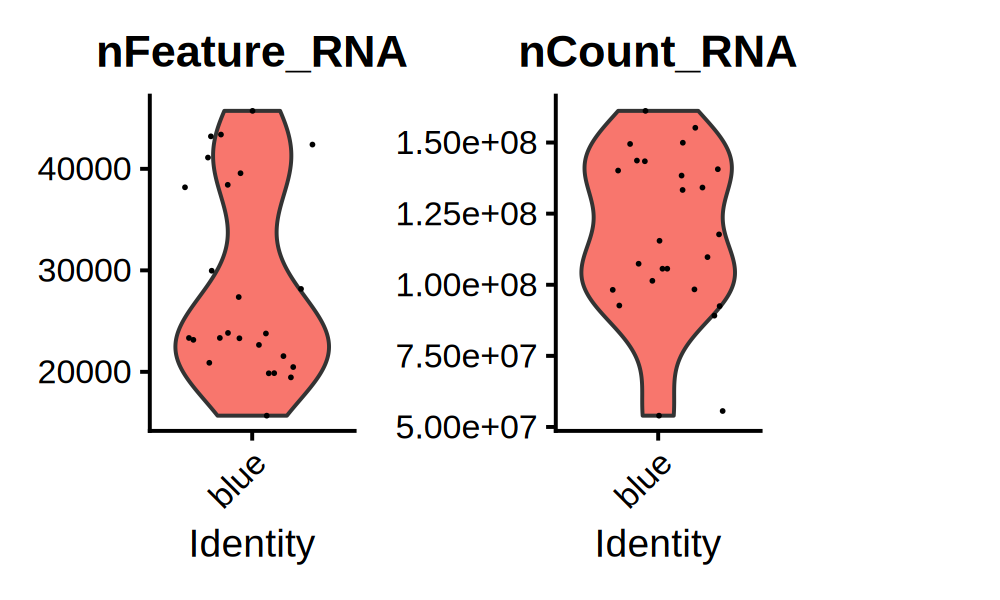

In [208]:
VlnPlot(oo, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"


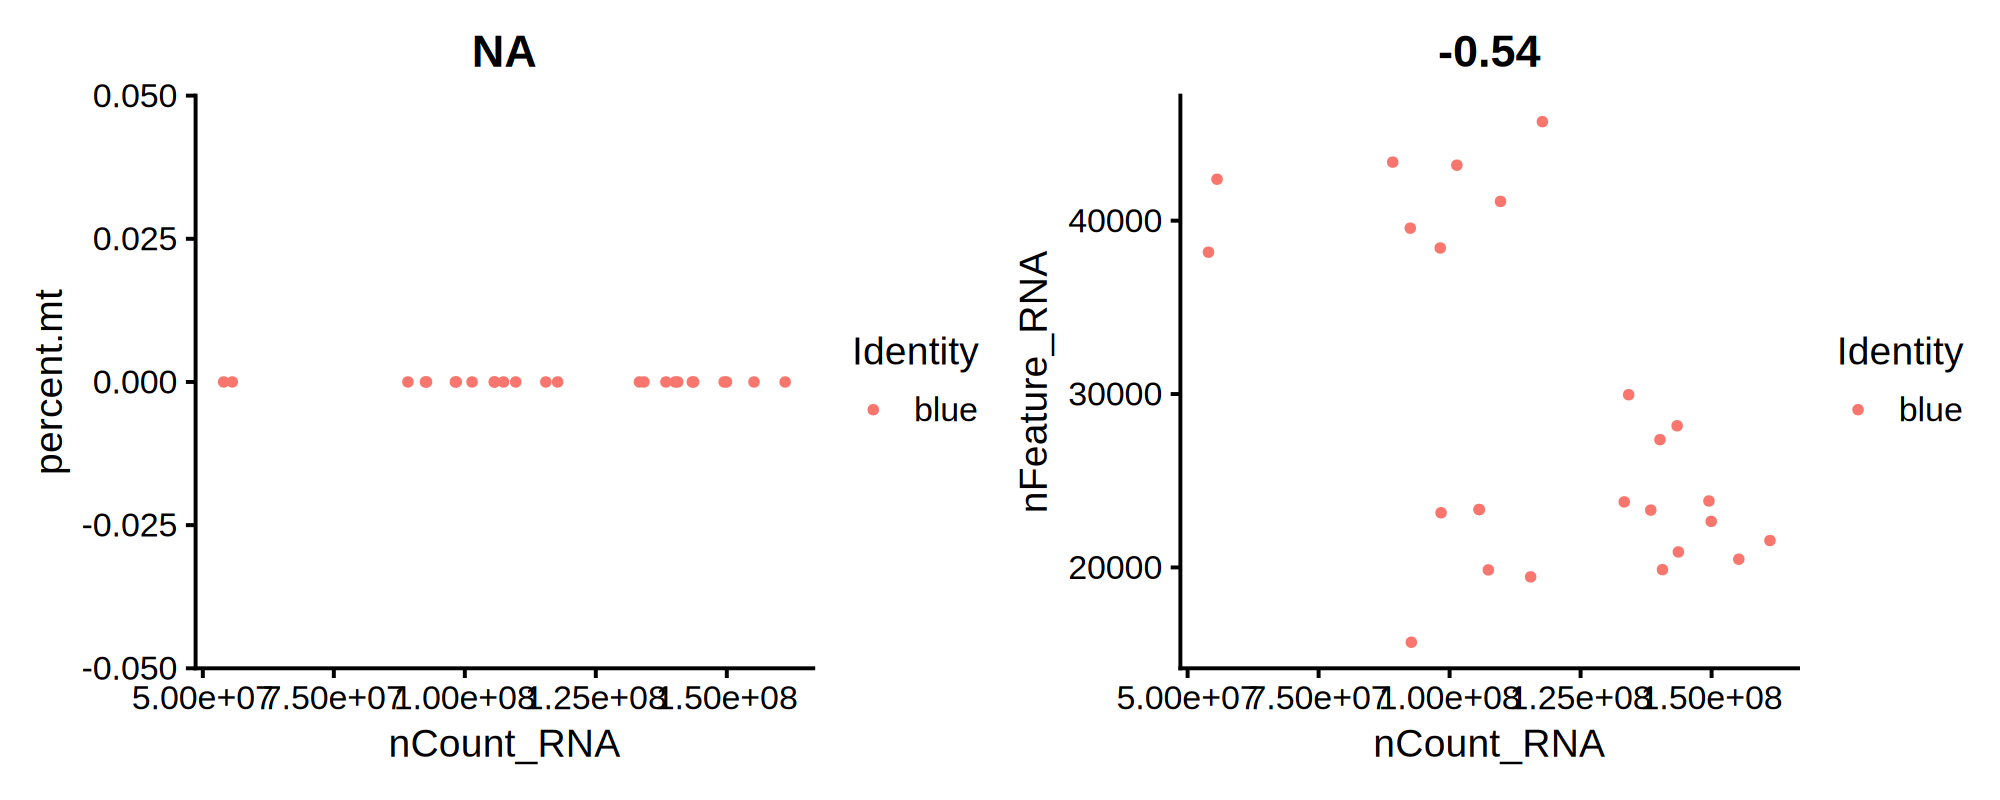

In [214]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
plot1 <- FeatureScatter(oo, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(oo, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2


In [216]:
oo <- NormalizeData(oo, normalization.method = "LogNormalize", scale.factor = 10000)


Normalizing layer: counts



Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


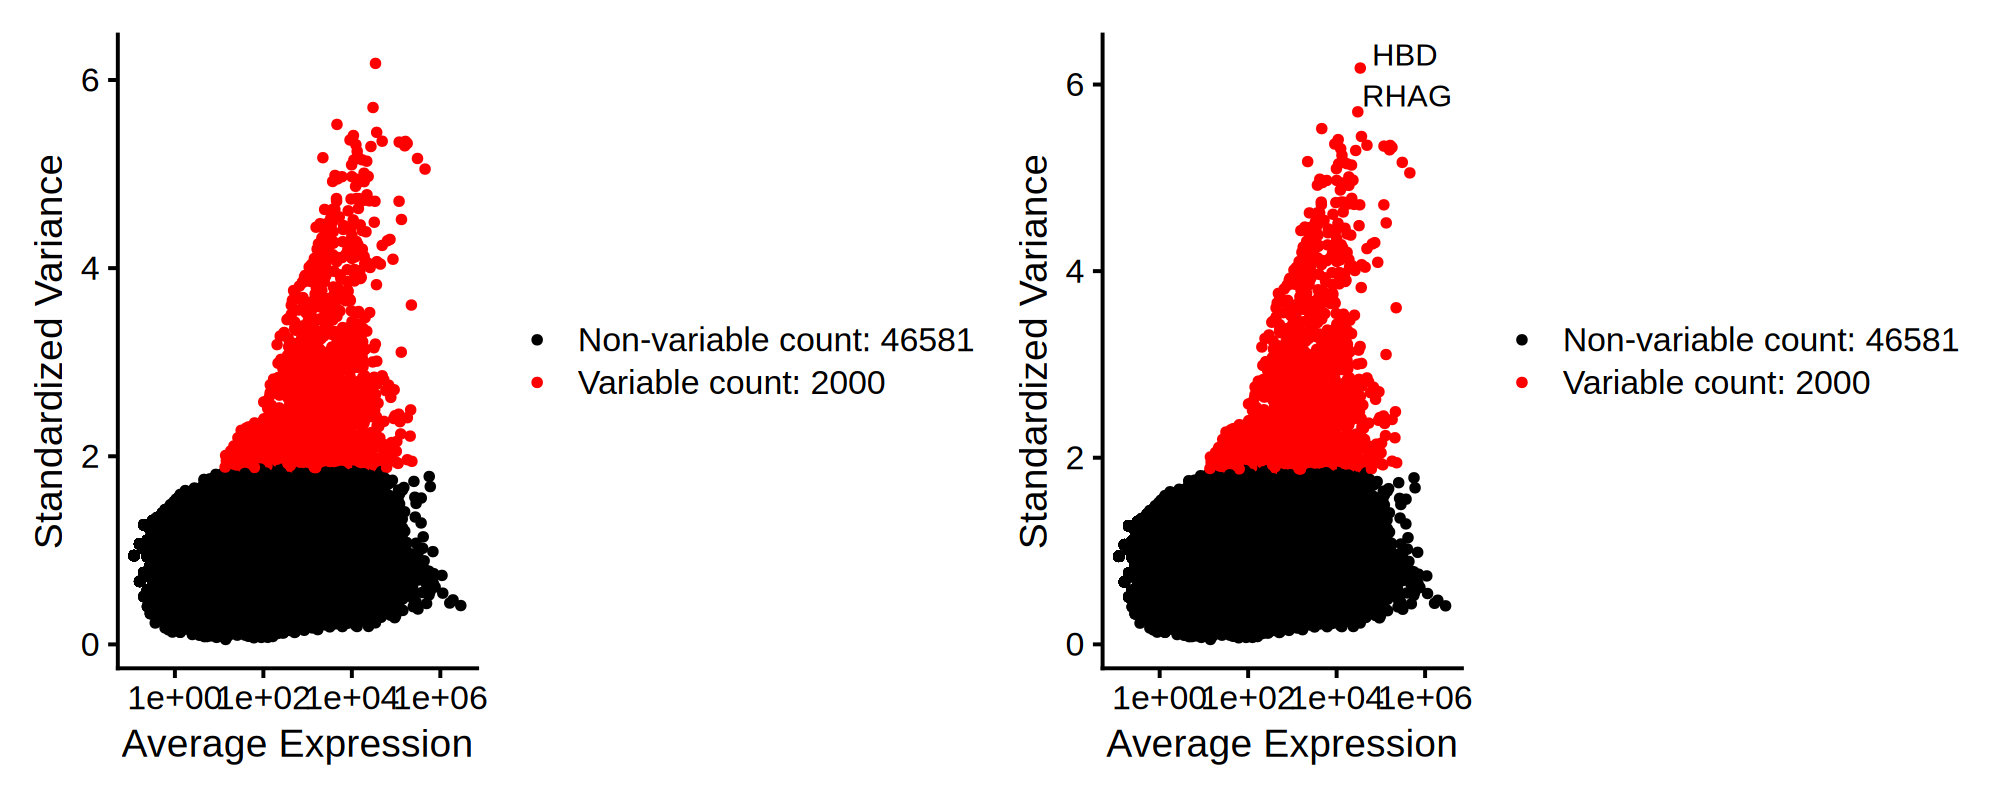

In [217]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
oo <- FindVariableFeatures(oo, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(oo), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(oo)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2


In [218]:
all.genes <- rownames(oo)
oo <- ScaleData(oo, features = all.genes)

Centering and scaling data matrix



In [ ]:
my.contrasts = makeContrasts(MNX1vsCD34=MNX1 - CD34, MNX1vsAML=MNX1 - Others, AMLvsCD34 = Others - CD34, levels=design)
MNX1vsCD34 = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsCD34"])
MNX1vsCD34 = topTags(MNX1vsCD34, n=nrow(MNX1vsCD34$table), adjust.method="fdr")
